In [ ]:
! conda

/bin/bash: conda: command not found


In [ ]:
! pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...


In [ ]:
! conda --version

conda 4.9.2


In [ ]:
! conda init bash
! conda config --add channels conda-forge
! conda create -n nilmtk
# activate environment 然後執行conda install的技巧 -> 要用&&連續執行
!source activate nilmtk && conda install -c nilmtk nilmtk

no change     /usr/local/condabin/conda
no change     /usr/local/bin/conda
no change     /usr/local/bin/conda-env
no change     /usr/local/bin/activate
no change     /usr/local/bin/deactivate
no change     /usr/local/etc/profile.d/conda.sh
no change     /usr/local/etc/fish/conf.d/conda.fish
no change     /usr/local/shell/condabin/Conda.psm1
no change     /usr/local/shell/condabin/conda-hook.ps1
no change     /usr/local/lib/python3.7/site-packages/xontrib/conda.xsh
no change     /usr/local/etc/profile.d/conda.csh
modified      /root/.bashrc

==> For changes to take effect, close and re-open your current shell. <==

Solving environment: / done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /usr/local/envs/nilmtk



Preparing transaction: \ done
Verifying transaction: / done
Executing transaction: \ done
#
# To acti

In [ ]:
from google.colab import drive
import os
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

做CRISP-DM並畫出頭兩天的數據線圖，藉由觀察圖可以比較直觀的理解數據大概的樣子，以利我們選擇ML的演算法。因為數據量很大，考量到Colab的記憶體附載還有避免在數據處理的過程中遇到process當掉的狀況，只先鎖定House1與2的總用電與個別電器用電數據做使用。
這個實驗的目標是希望能做出一個能夠藉由分析總用電數據然後推知個別電器用電歷程的model。產出的model除了觀察MSE等評價指標外，也直接跟ground truth plot在一起，這樣可以更直觀的觀察model的信效度。

In [ ]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = '/content/data/MyDrive/110-1/物聯網/Final/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i])

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}
House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'}
House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18', 19

In [ ]:
def read_merge_data(house):
    path = '/content/data/MyDrive/110-1/物聯網/Final/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,7):
    df[i] = read_merge_data(i)

In [ ]:
for i in range(1,7):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (406748, 20)


mains_1  mains_2  ...  washer_dryer_19  washer_dryer_20
2011-05-24 19:56:27   235.46    38.61  ...              0.0              0.0
2011-05-24 19:56:30   235.98    38.77  ...              0.0              0.0
2011-05-24 19:56:34   235.29    38.83  ...              0.0              0.0

[3 rows x 20 columns]

House 2 data has shape:  (316840, 11)


mains_1  mains_2  ...  dishwaser_10  disposal_11
2011-05-22 23:59:01    10.84   252.61  ...           0.0          0.0
2011-05-22 23:59:04    10.88   253.02  ...           0.0          0.0
2011-05-22 23:59:08    10.84   252.77  ...           0.0          0.0

[3 rows x 11 columns]

House 3 data has shape:  (376150, 22)


mains_1  mains_2  ...  kitchen_outlets_21  kitchen_outlets_22
2011-05-31 00:19:30    15.45     2.23  ...                 0.0                 2.5
2011-05-31 00:19:33    15.42     2.23  ...                 0.0                 2.5
2011-05-31 00:19:36    15.44     2.23  ...                 0.0                 2.5

[3 rows x 22 columns]

House 4 data has shape:  (428076, 20)


mains_1  mains_2  ...  lighting_19  air_conditioning_20
2011-06-04 00:45:31   403.36    94.65  ...          0.0                  0.0
2011-06-04 00:45:35   401.11    94.63  ...          0.0                  0.0
2011-06-04 00:45:38   400.24    94.43  ...          0.0                  0.0

[3 rows x 20 columns]

House 5 data has shape:  (77451, 26)


mains_1  mains_2  ...  kitchen_outlets_25  outdoor_outlets_26
2011-06-01 00:20:07   151.68    37.39  ...                 0.0                 0.0
2011-06-01 00:20:10   150.42    37.21  ...                 0.0                 0.0
2011-06-01 00:20:14   149.29    37.10  ...                 0.0                 0.0

[3 rows x 26 columns]

House 6 data has shape:  (192192, 17)


mains_1  mains_2  ...  air_conditioning_16  air_conditioning_17
2011-06-14 01:12:25    19.82   401.65  ...                  0.0                  0.0
2011-06-14 01:12:33    19.59   400.11  ...                  0.0                  0.0
2011-06-14 01:12:36    19.59   399.47  ...                  0.0                  0.0

[3 rows x 17 columns]

In [ ]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 



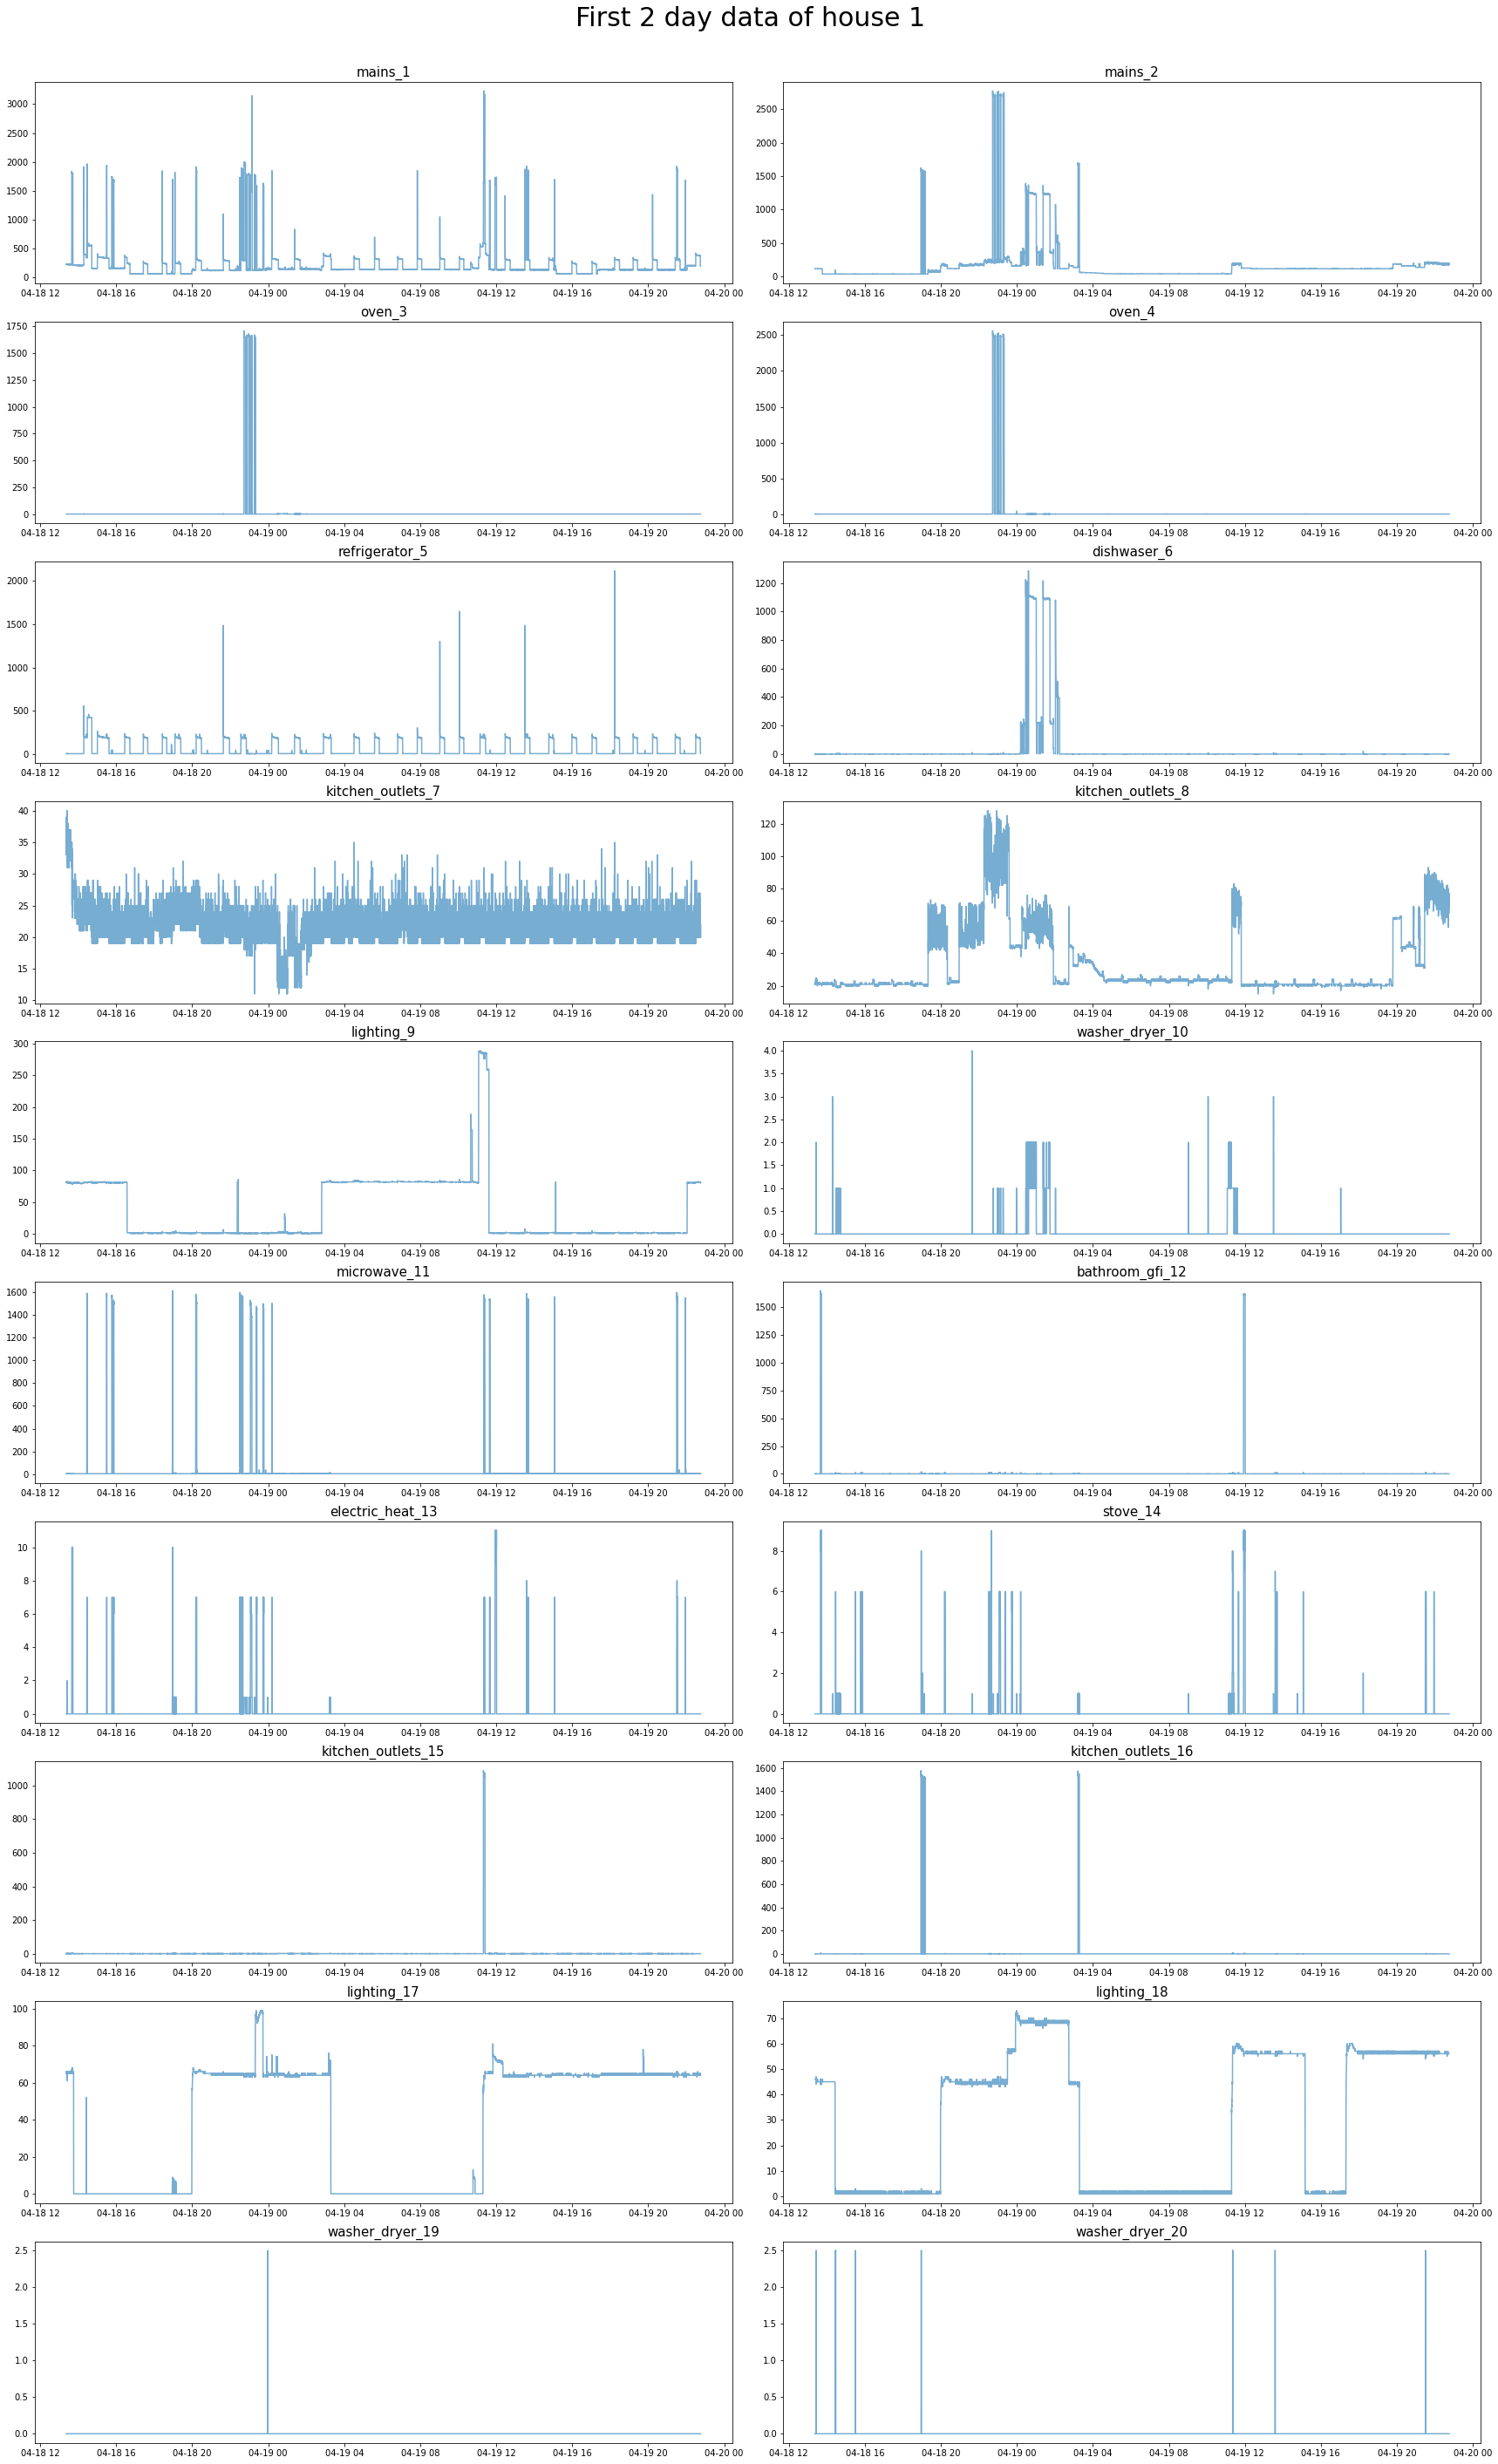

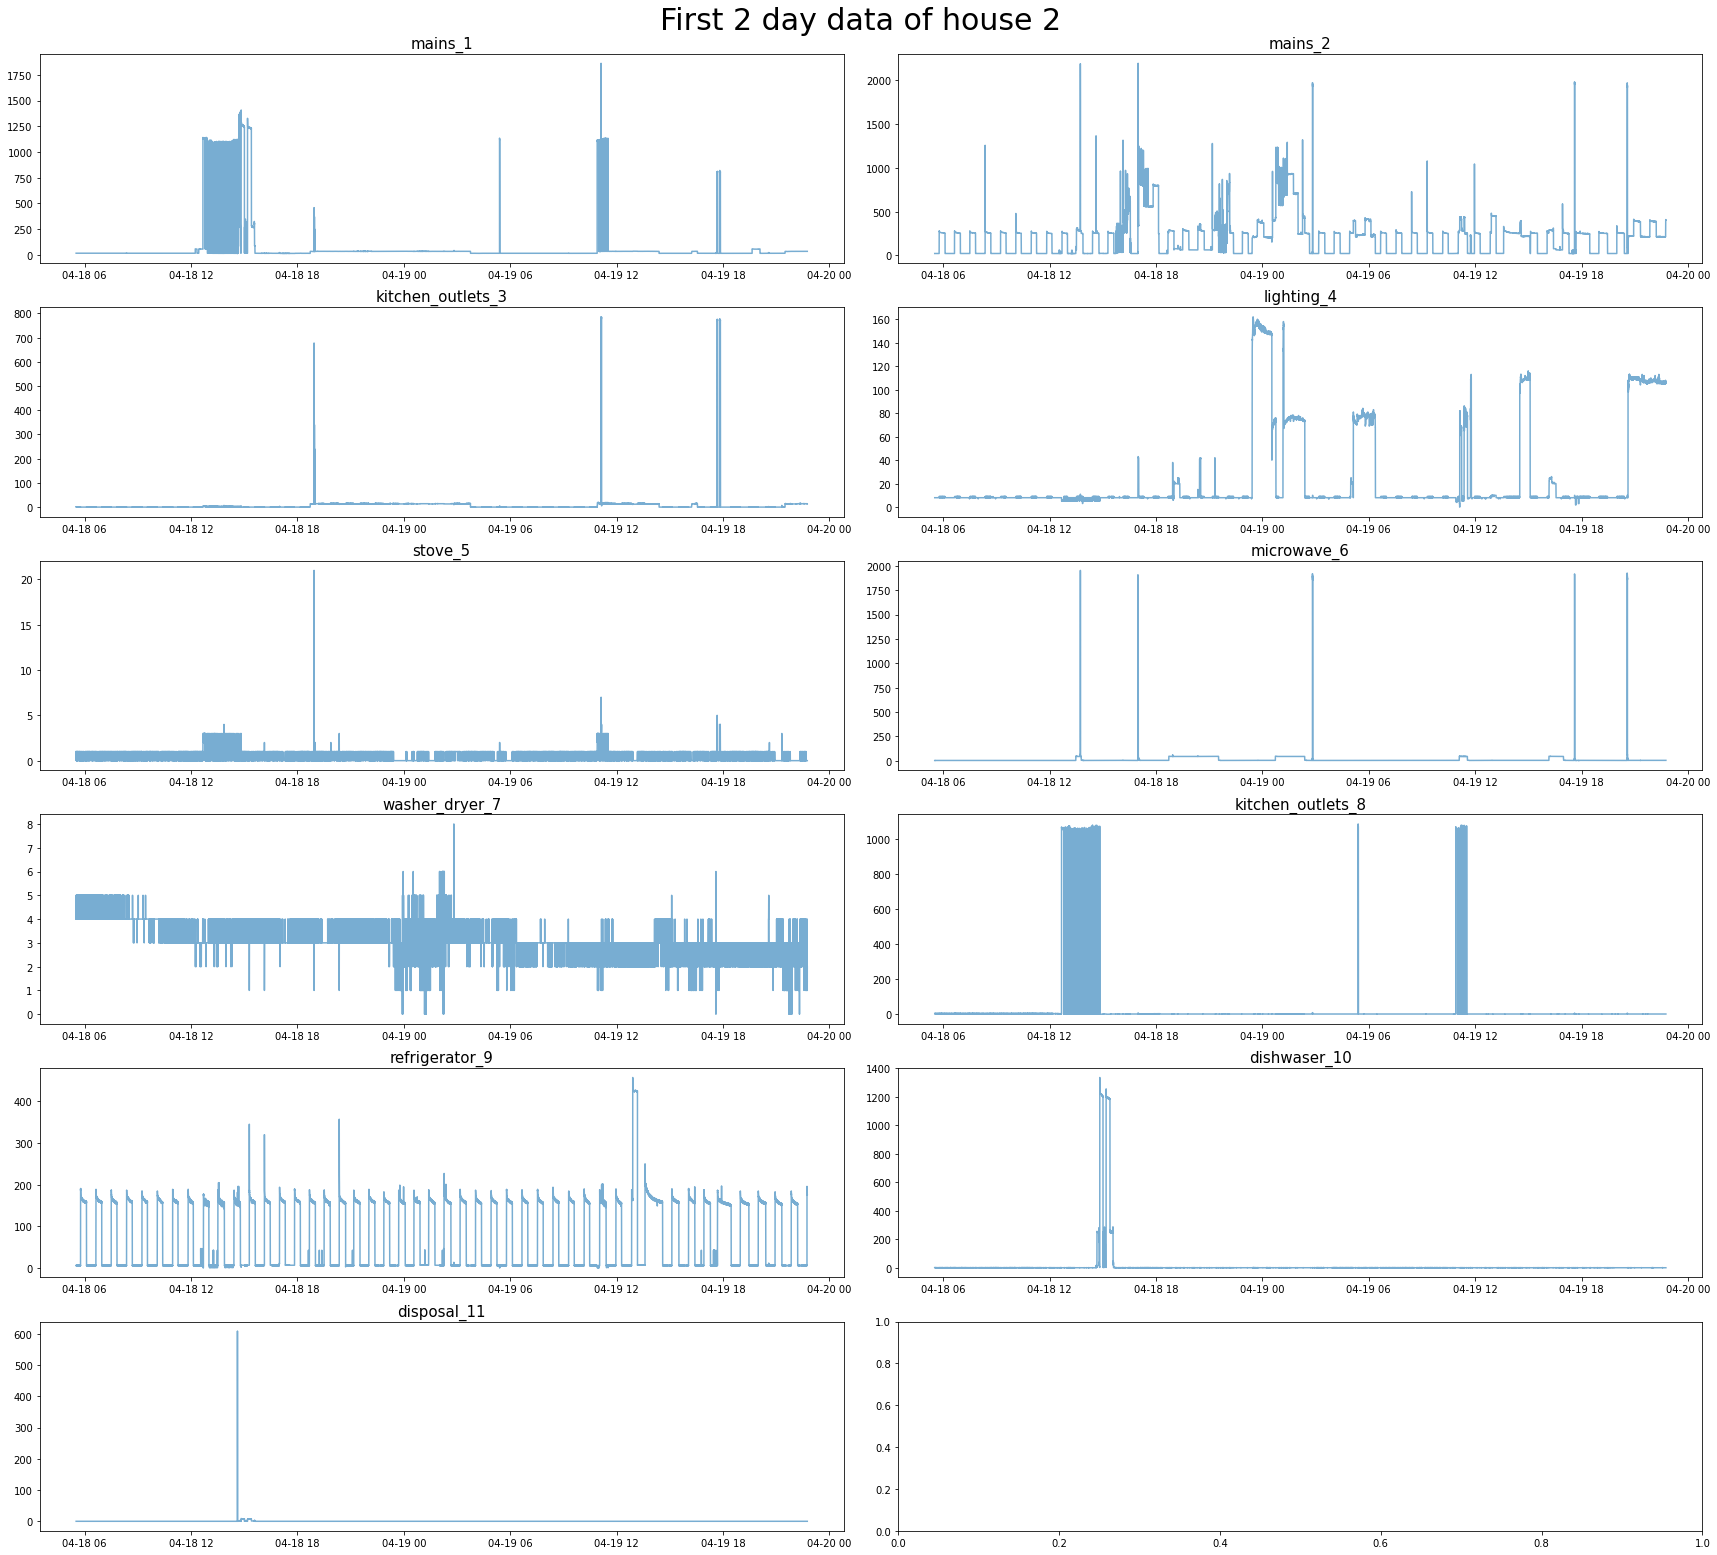

In [ ]:
# 畫出House 1與2頭兩天的總用電與個別電器用電折線圖
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,3):
    plot_df(df[i].loc[:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5, 1.0, 'House 2')

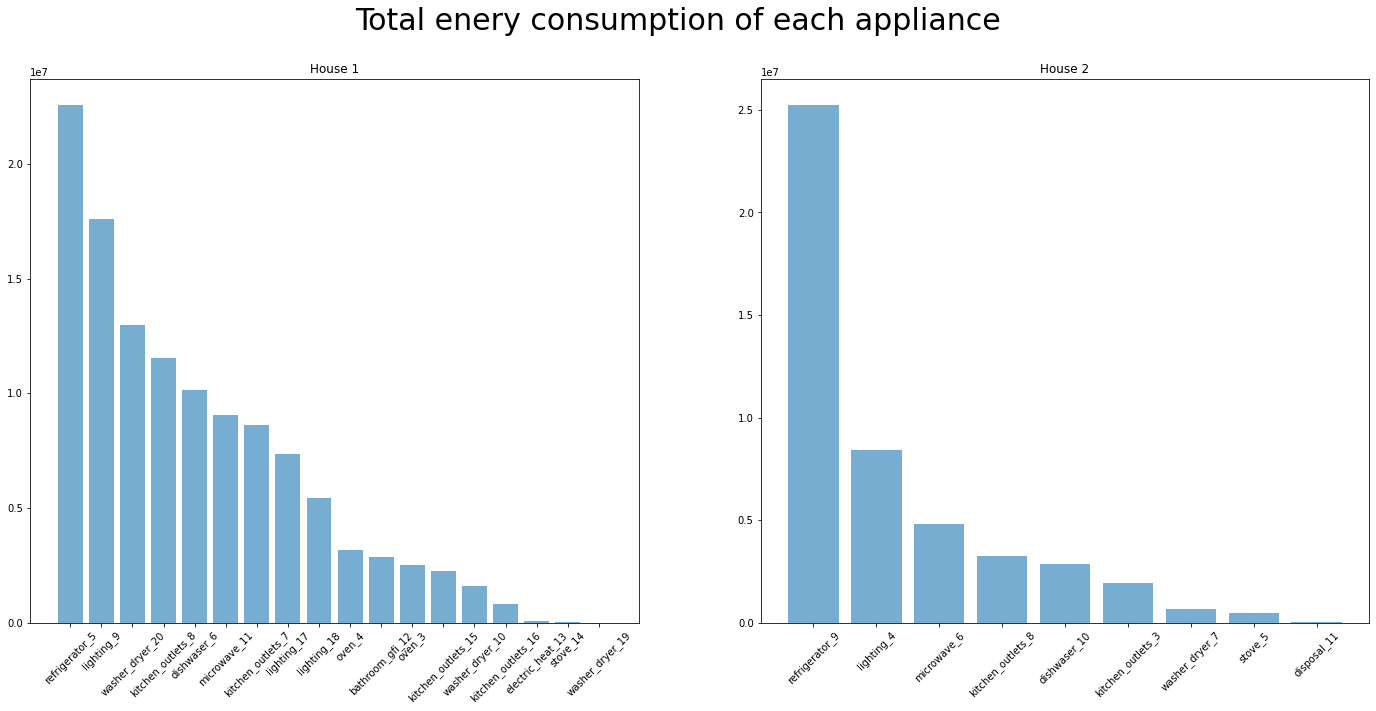

In [ ]:
# 將House 1與2的個別電器用電畫成直方圖，並找出用電最多的電器：冰箱。之後我們會優先觀察冰箱的model預測結果。
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')

In [ ]:
# 把House1的數據拆成train、validation跟test三組
df1_train = df[1].loc[:dates[1][10]]
df1_val = df[1].loc[dates[1][11]:dates[1][16]]
df1_test = df[1].loc[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (214816, 20)
df_val.shape:  (104875, 20)
df_test.shape:  (87057, 20)


In [ ]:
# 用mains_1, mains_2來disaggregate冰箱的用電數據
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


就用電數據的性質來看，屬於連續性輸出數值的一種，因此在ML的部分選用Decision Tree Regression(DTR)。我們希望透過DTR分析同一個時點的總用電與個別電器用電後，讓model基於它對用電數據的理解在只知道總用電數據的情況下disaggregate出個別電器用電。

In [ ]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)
from sklearn.tree import DecisionTreeRegressor
def tree_reg(X_train, y_train, X_val, y_val, min_samples_split):
    clfs = []
    losses = []
    start = time.time()
    for split in min_samples_split:
        clf = DecisionTreeRegressor(min_samples_split = split)
        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)
        clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
    print('Trainning time: ', time.time() - start)
    return clfs, losses
tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1, min_samples_split)

Trainning time:  30.25093984603882


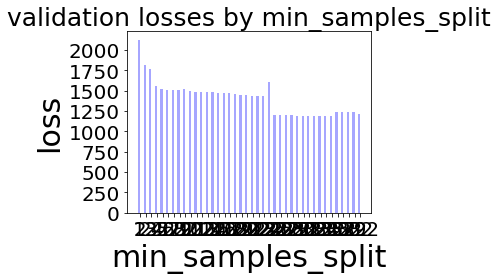

In [ ]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.4
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()

plot_losses(tree_losses_1, min_samples_split)

In [ ]:
# 用best model來預測在test dataset的電冰箱用電數據C
ind = np.argmin(tree_losses_1)
tree_clf_1 = tree_clfs_1[ind]
y_test_predict_1 = tree_clf_1.predict(X_test1)
mse_tree_1 = mse_loss(y_test_predict_1, y_test1)
mae_tree_1 = mae_loss(y_test_predict_1, y_test1)
print('Mean square error on test set: ', mse_tree_1)
print('Mean absolute error on the test set: ', mae_tree_1)

Mean square error on test set:  1634.5797666188705
Mean absolute error on the test set:  12.686127417077758


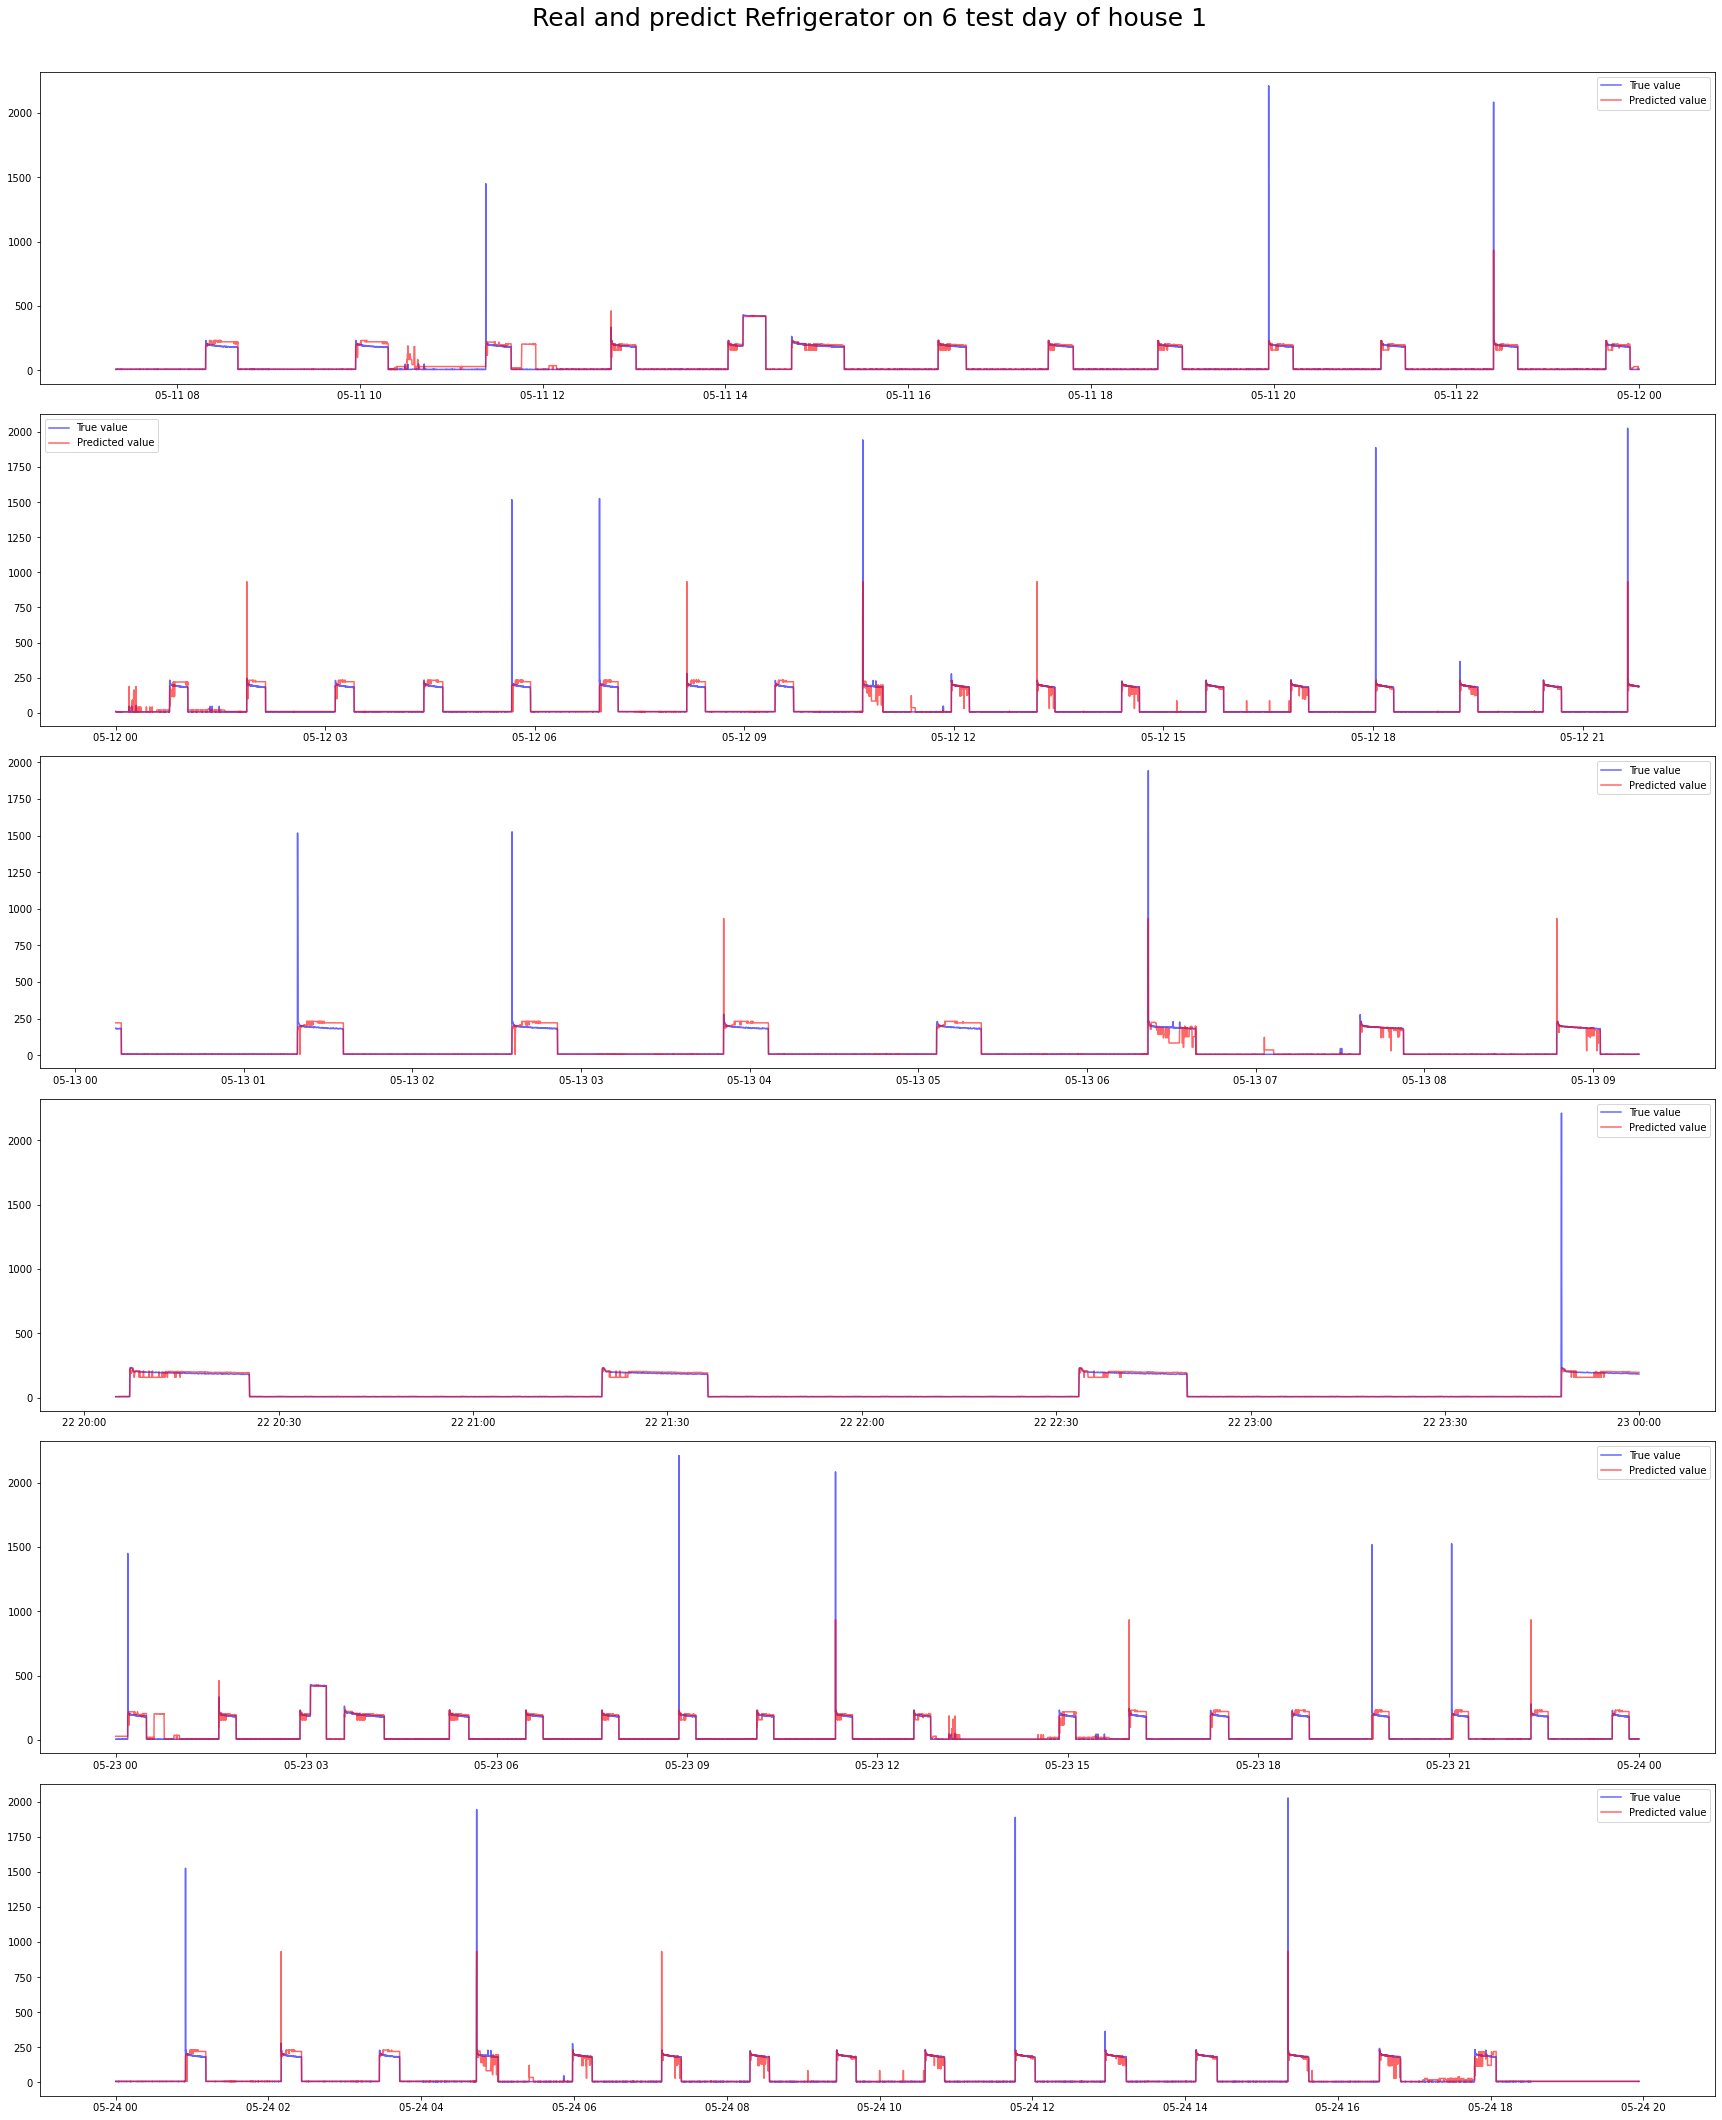

In [ ]:
# 畫出冰箱前6日用電的ground truth跟預測值：看起來除了細微的變化跟啟動電流所造成的surge以外，效果還不錯
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

In [ ]:
X_2 = df[2][['mains_2','mains_1']].values
y_2 = df[2]['refrigerator_9'].values
print(X_2.shape, y_2.shape)

(316840, 2) (316840,)


In [ ]:
y_predict_2 = tree_clf_1.predict(X_2)
mse_tree_2 = mse_loss(y_predict_2, y_2)
mae_tree_2 = mae_loss(y_predict_2, y_2)
print('Mean square error on test set: ', mse_tree_2)
print('Mean absolute error on the test set: ', mae_tree_2)

Mean square error on test set:  32245.25362228206
Mean absolute error on the test set:  64.75419454670589


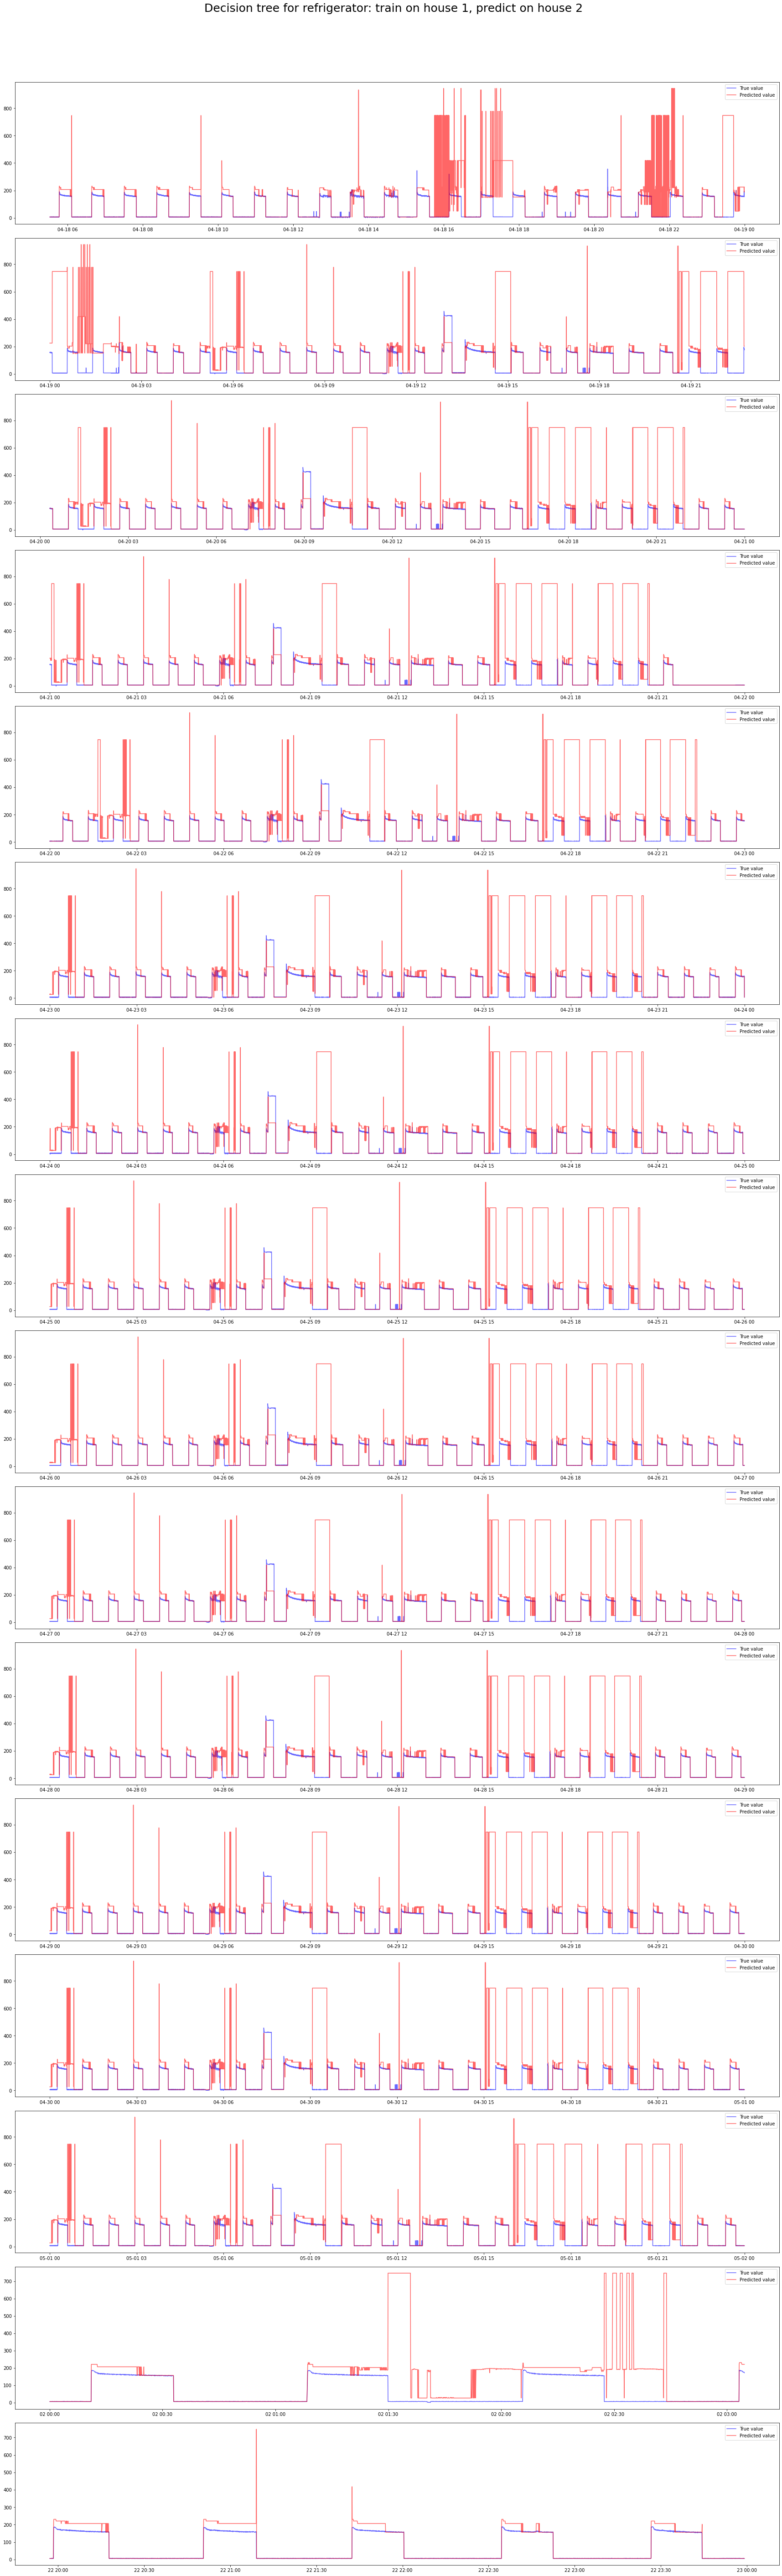

In [ ]:
plot_each_app(df[2], dates[2], y_predict_2, y_2, 'Decision tree for refrigerator: train on house 1, predict on house 2')

In [ ]:
# 列出House 1其他電器
appliances = list(df[1].columns.values[2:])
appliances.pop(2)
print(appliances)

['oven_3', 'oven_4', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']


In [ ]:
# 用模型來預測其他電器的用電數據
def tree_reg_mult_apps():
    start = time.time()
    min_samples_split=np.arange(2, 400, 10)
    pred = {}
    for app in appliances:
        list_clfs = []
        losses = []
        y_train = df1_train[app].values
        y_val = df1_val[app].values
        for split in min_samples_split:
            clf = DecisionTreeRegressor(min_samples_split = split)
            clf.fit(X_train1, y_train)
            y_predict_val = clf.predict(X_val1)
            list_clfs.append(clf)
            losses.append( mse_loss(y_predict_val, y_val) )
        ind = np.argmin(losses)
        pred[app] = list_clfs[ind].predict(X_test1)
    print('Trainning time: ', time.time() - start)
    return pred

mul_pred = tree_reg_mult_apps()

Trainning time:  353.74992847442627


In [ ]:
def error_mul_app(mul_pred):
    mse_losses = {}
    mae_losses = {}
    for app in appliances:
        mse_losses[app] = mse_loss(mul_pred[app], df1_test[app].values)
        mae_losses[app] = mae_loss(mul_pred[app], df1_test[app].values)
    return mse_losses, mae_losses

mul_mse_tree, mul_mae_tree = error_mul_app(mul_pred)

In [ ]:
for app in appliances:
    m = np.mean(df1_test[app].values)
    print('mean of {0}: {1:.2f} - mse: {2:.2f} - mae: {3:.2f}'.format(app, m ,mul_mse_tree[app], mul_mae_tree[app]))

mean of oven_3: 15.63 - mse: 18555.07 - mae: 11.29
mean of oven_4: 17.11 - mse: 7454.75 - mae: 4.92
mean of dishwaser_6: 25.35 - mse: 831.49 - mae: 3.38
mean of kitchen_outlets_7: 21.25 - mse: 4.54 - mae: 1.59
mean of kitchen_outlets_8: 27.71 - mse: 99.51 - mae: 3.43
mean of lighting_9: 28.29 - mse: 1574.76 - mae: 24.09
mean of washer_dryer_10: 3.07 - mse: 934.44 - mae: 2.44
mean of microwave_11: 18.92 - mse: 12442.92 - mae: 13.00
mean of bathroom_gfi_12: 6.73 - mse: 3471.07 - mae: 3.44
mean of electric_heat_13: 0.11 - mse: 0.53 - mae: 0.05
mean of stove_14: 0.10 - mse: 0.23 - mae: 0.04
mean of kitchen_outlets_15: 5.34 - mse: 832.75 - mae: 1.63
mean of kitchen_outlets_16: 1.93 - mse: 718.63 - mae: 0.65
mean of lighting_17: 18.97 - mse: 136.66 - mae: 3.18
mean of lighting_18: 15.68 - mse: 383.82 - mae: 13.12
mean of washer_dryer_19: 0.00 - mse: 0.00 - mae: 0.00
mean of washer_dryer_20: 27.54 - mse: 2087.58 - mae: 1.79


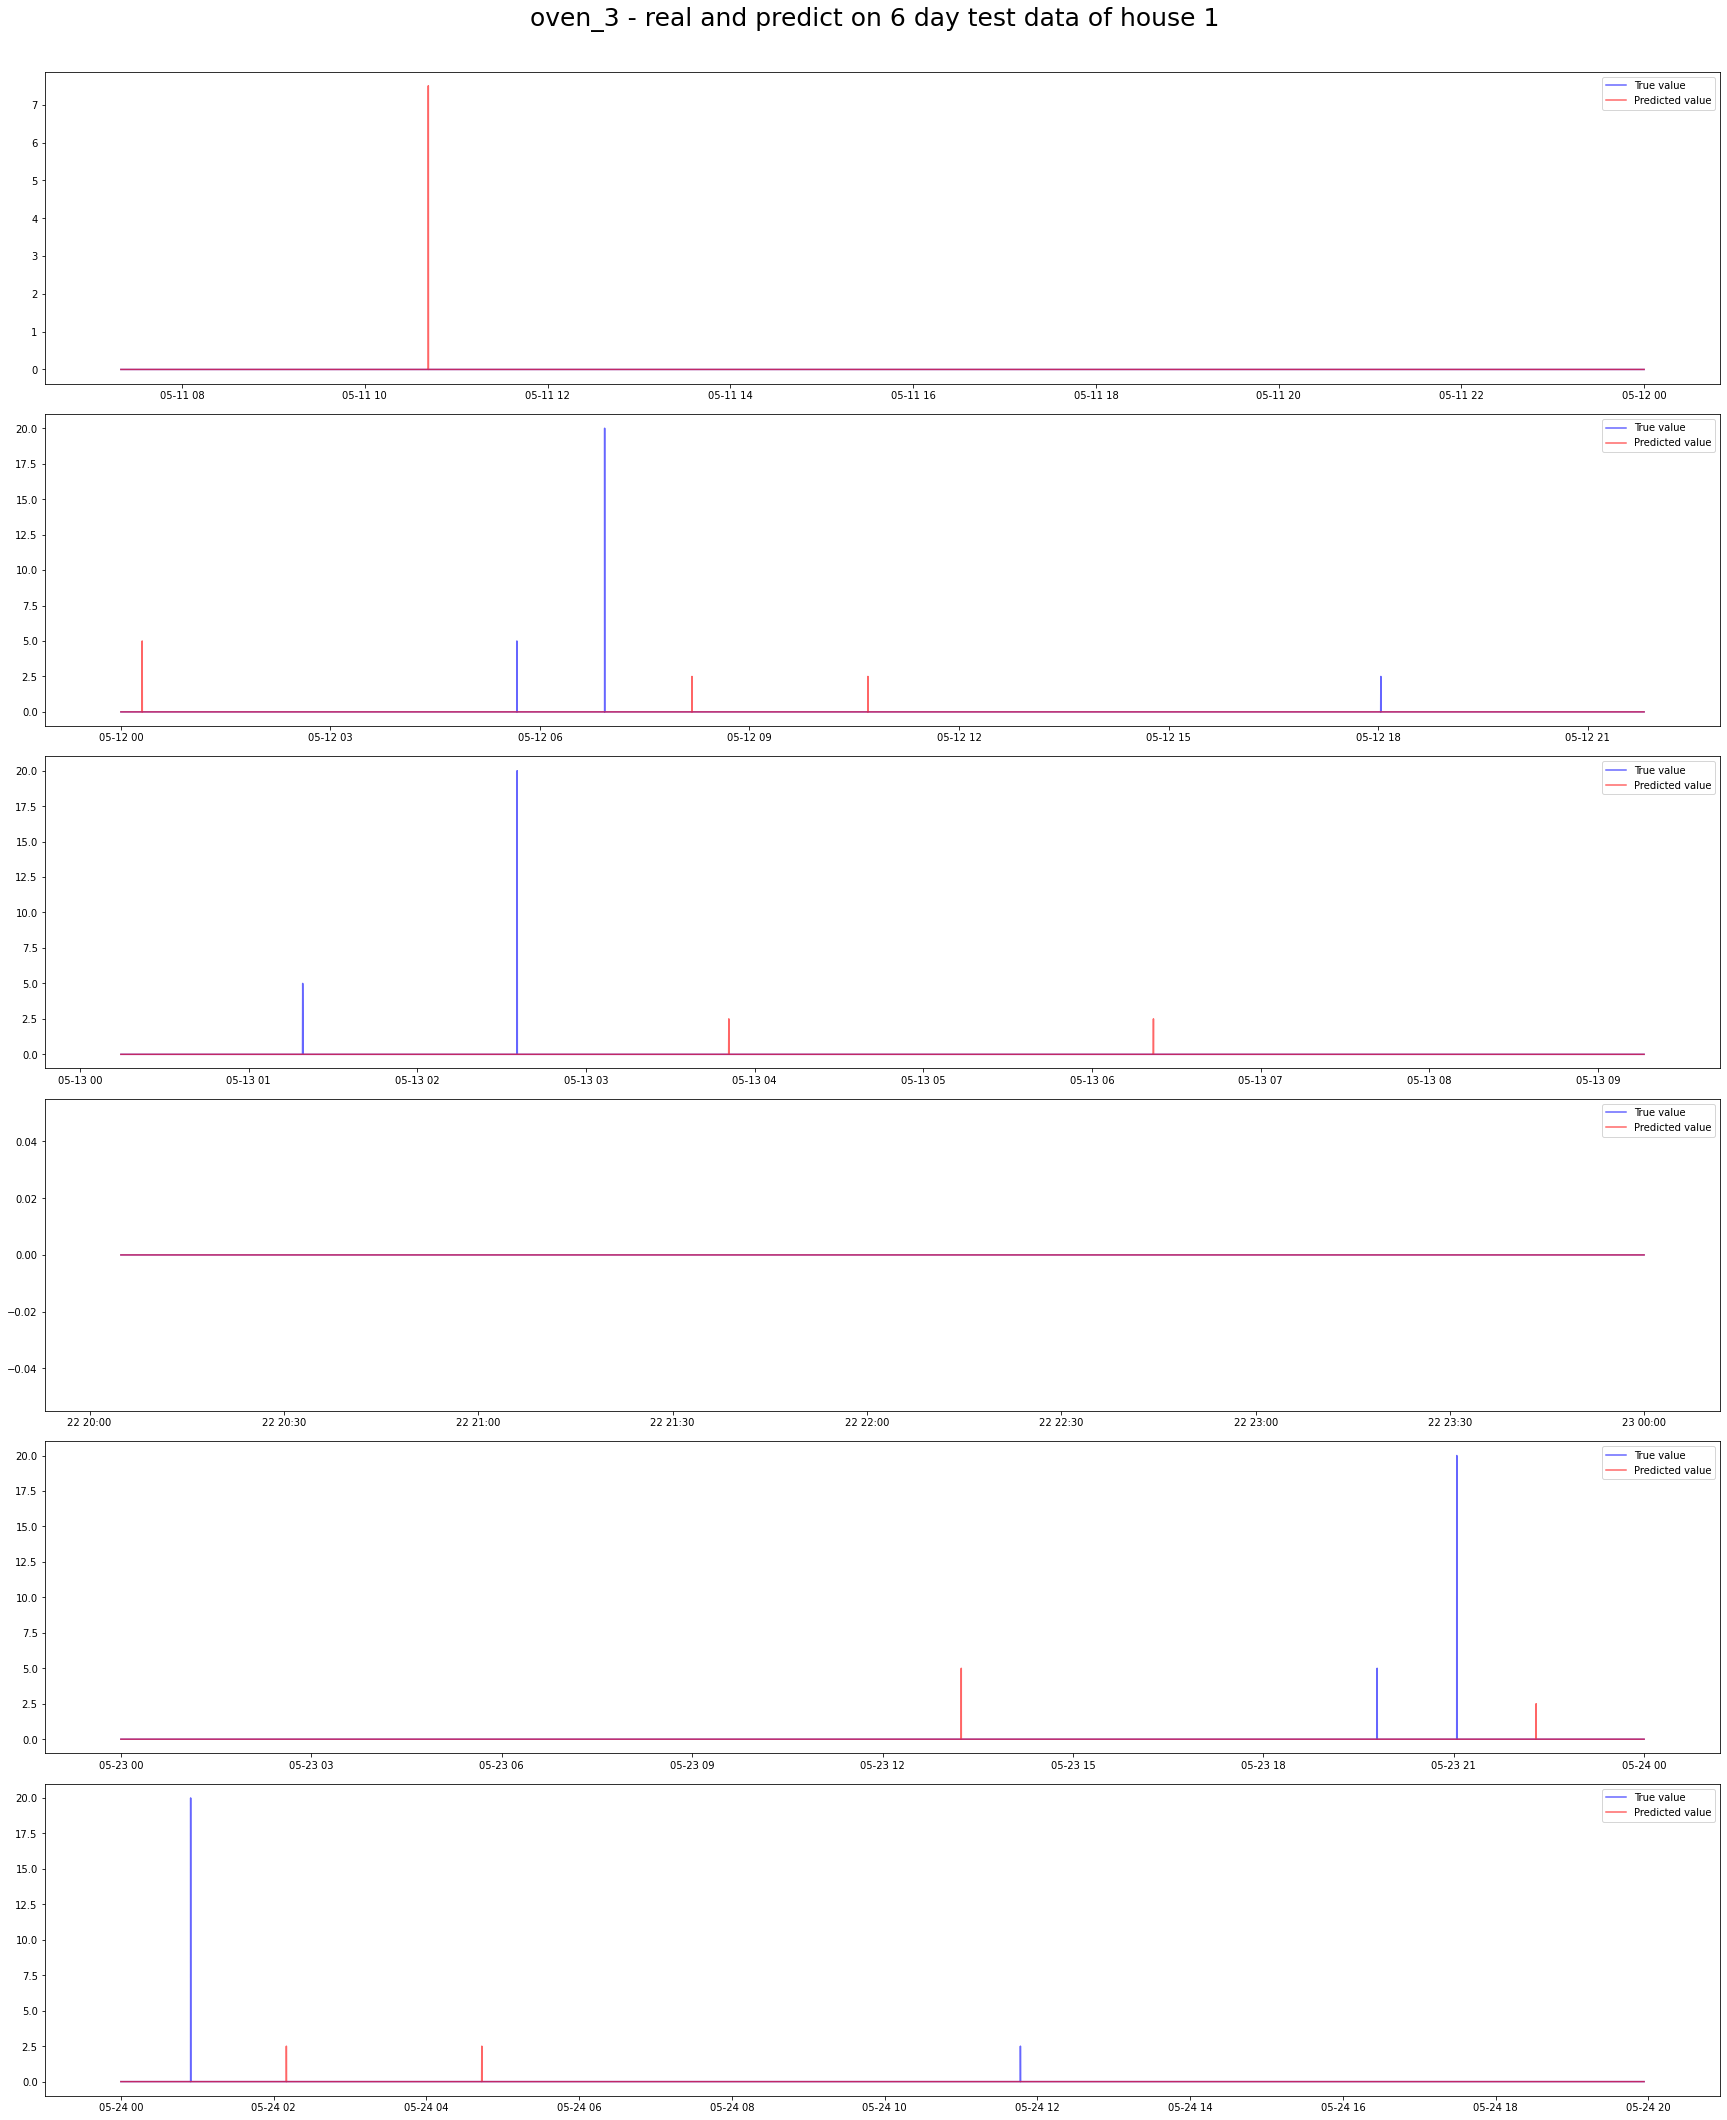

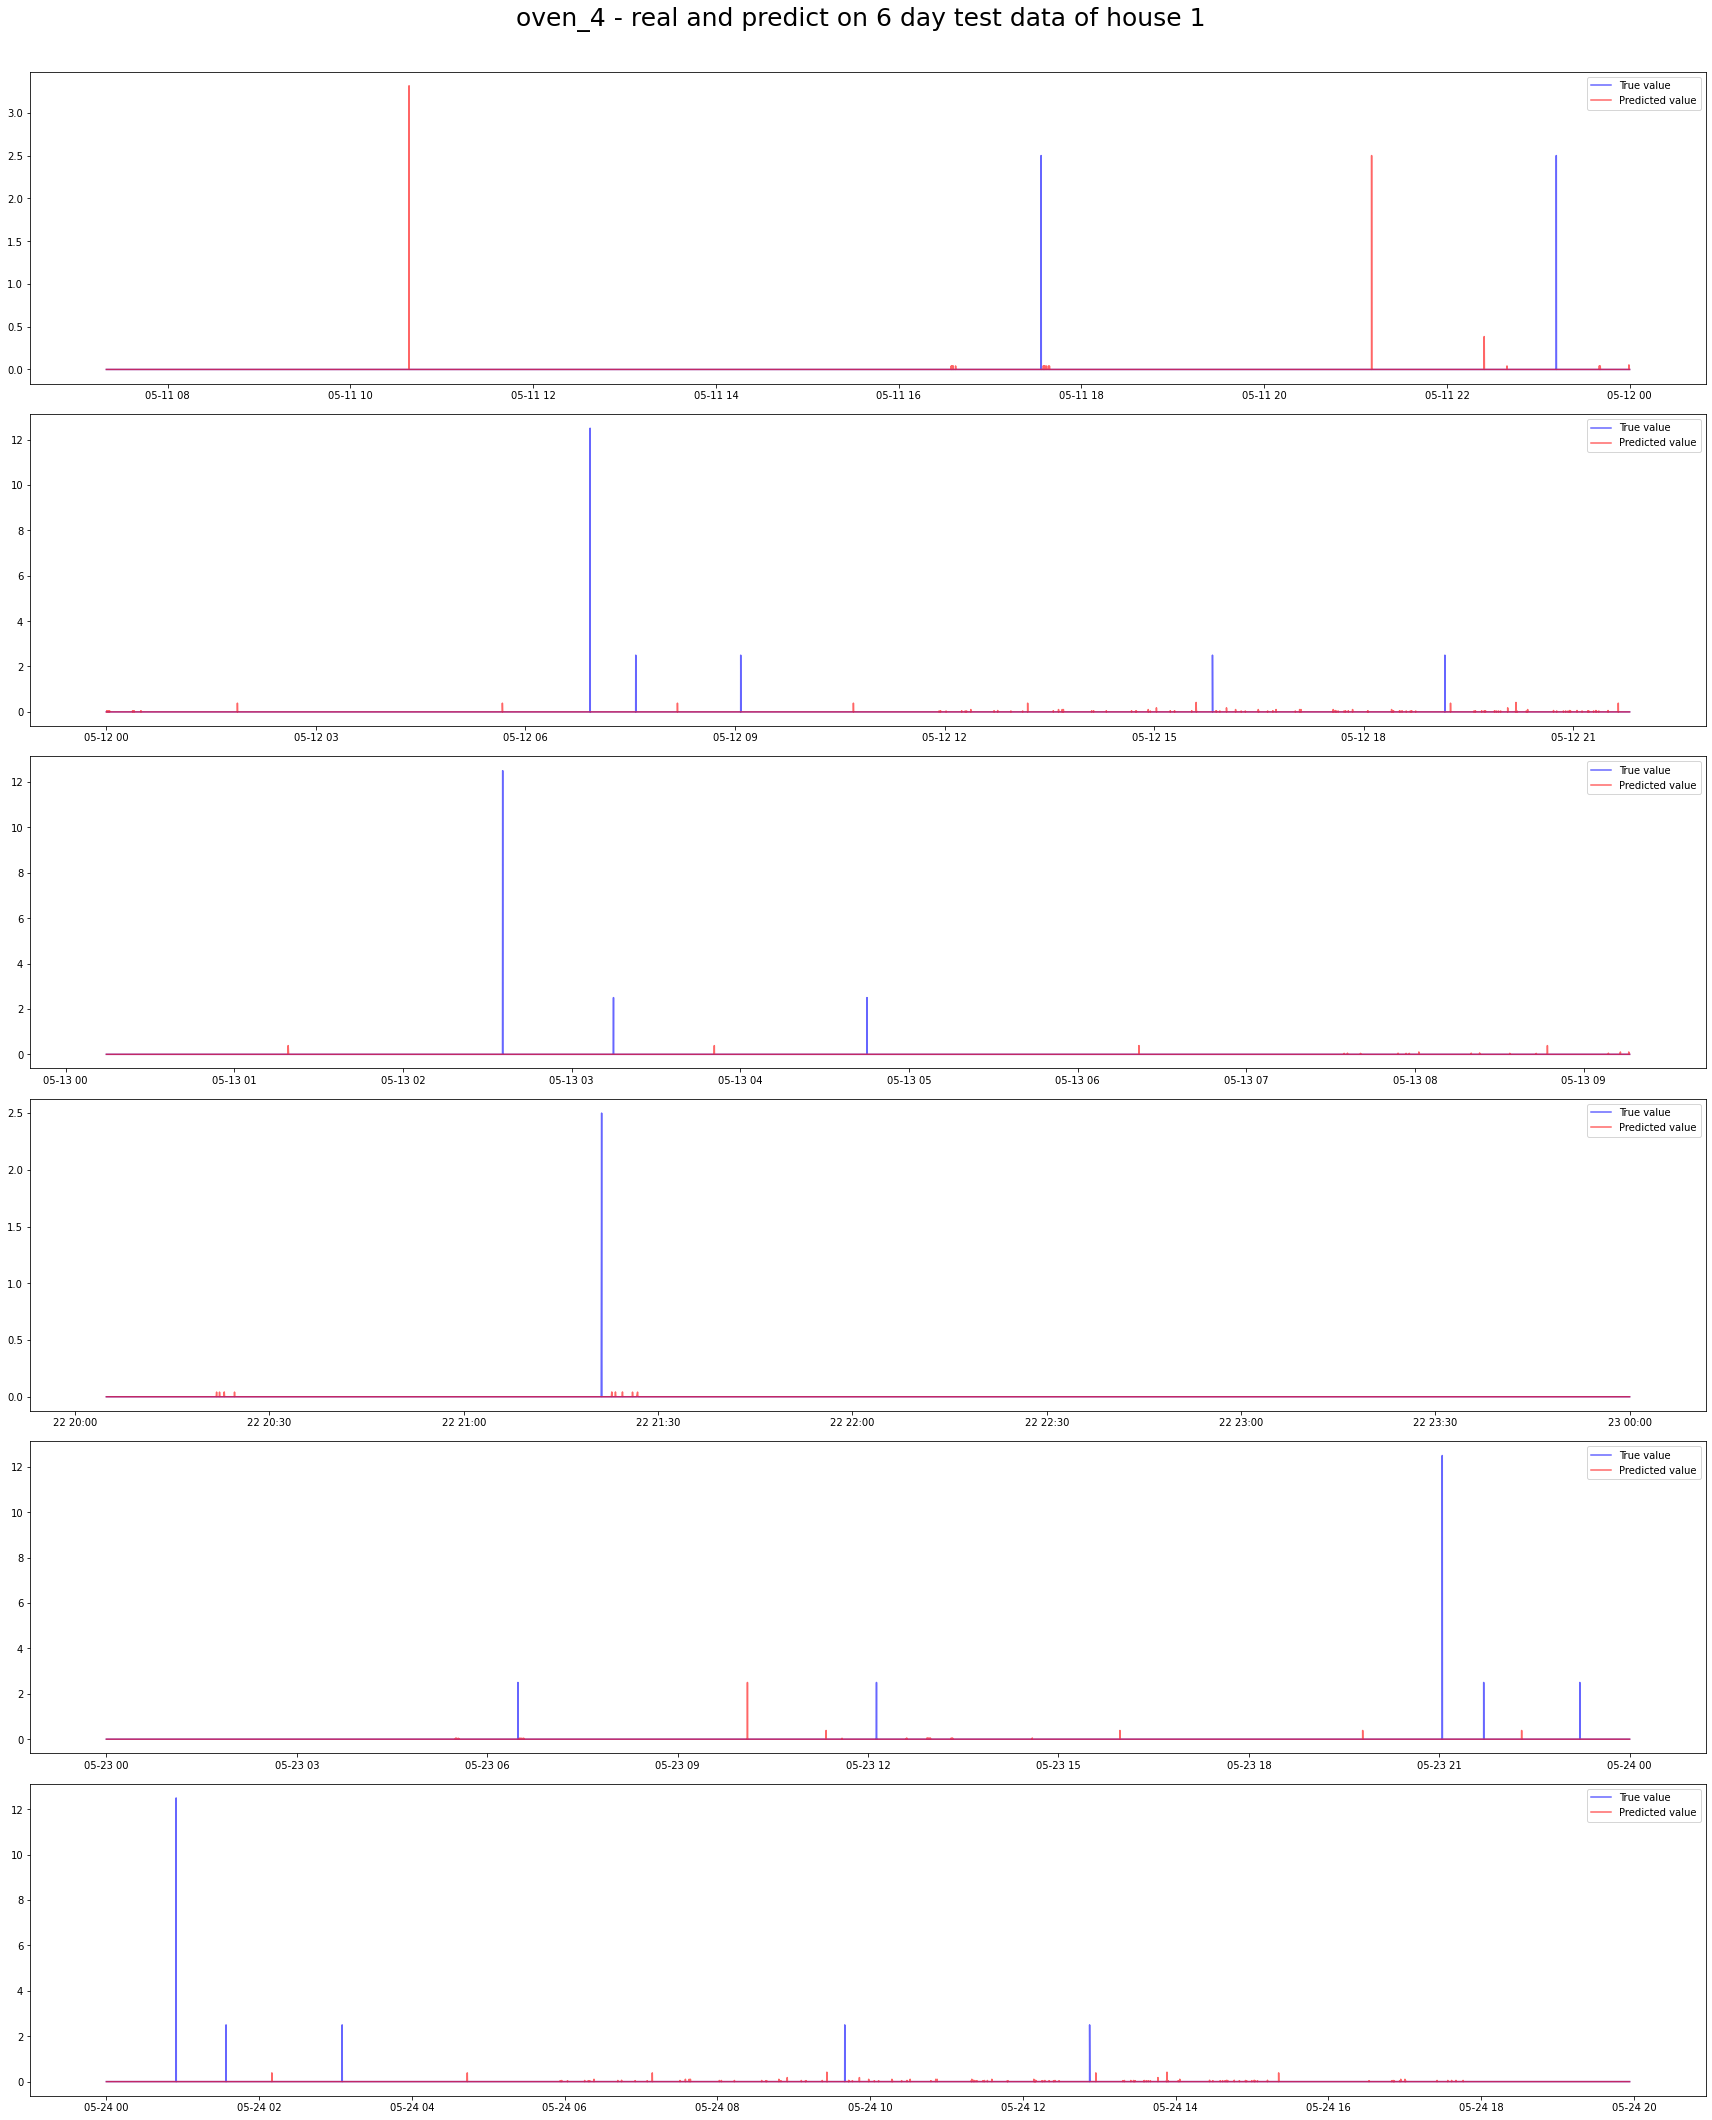

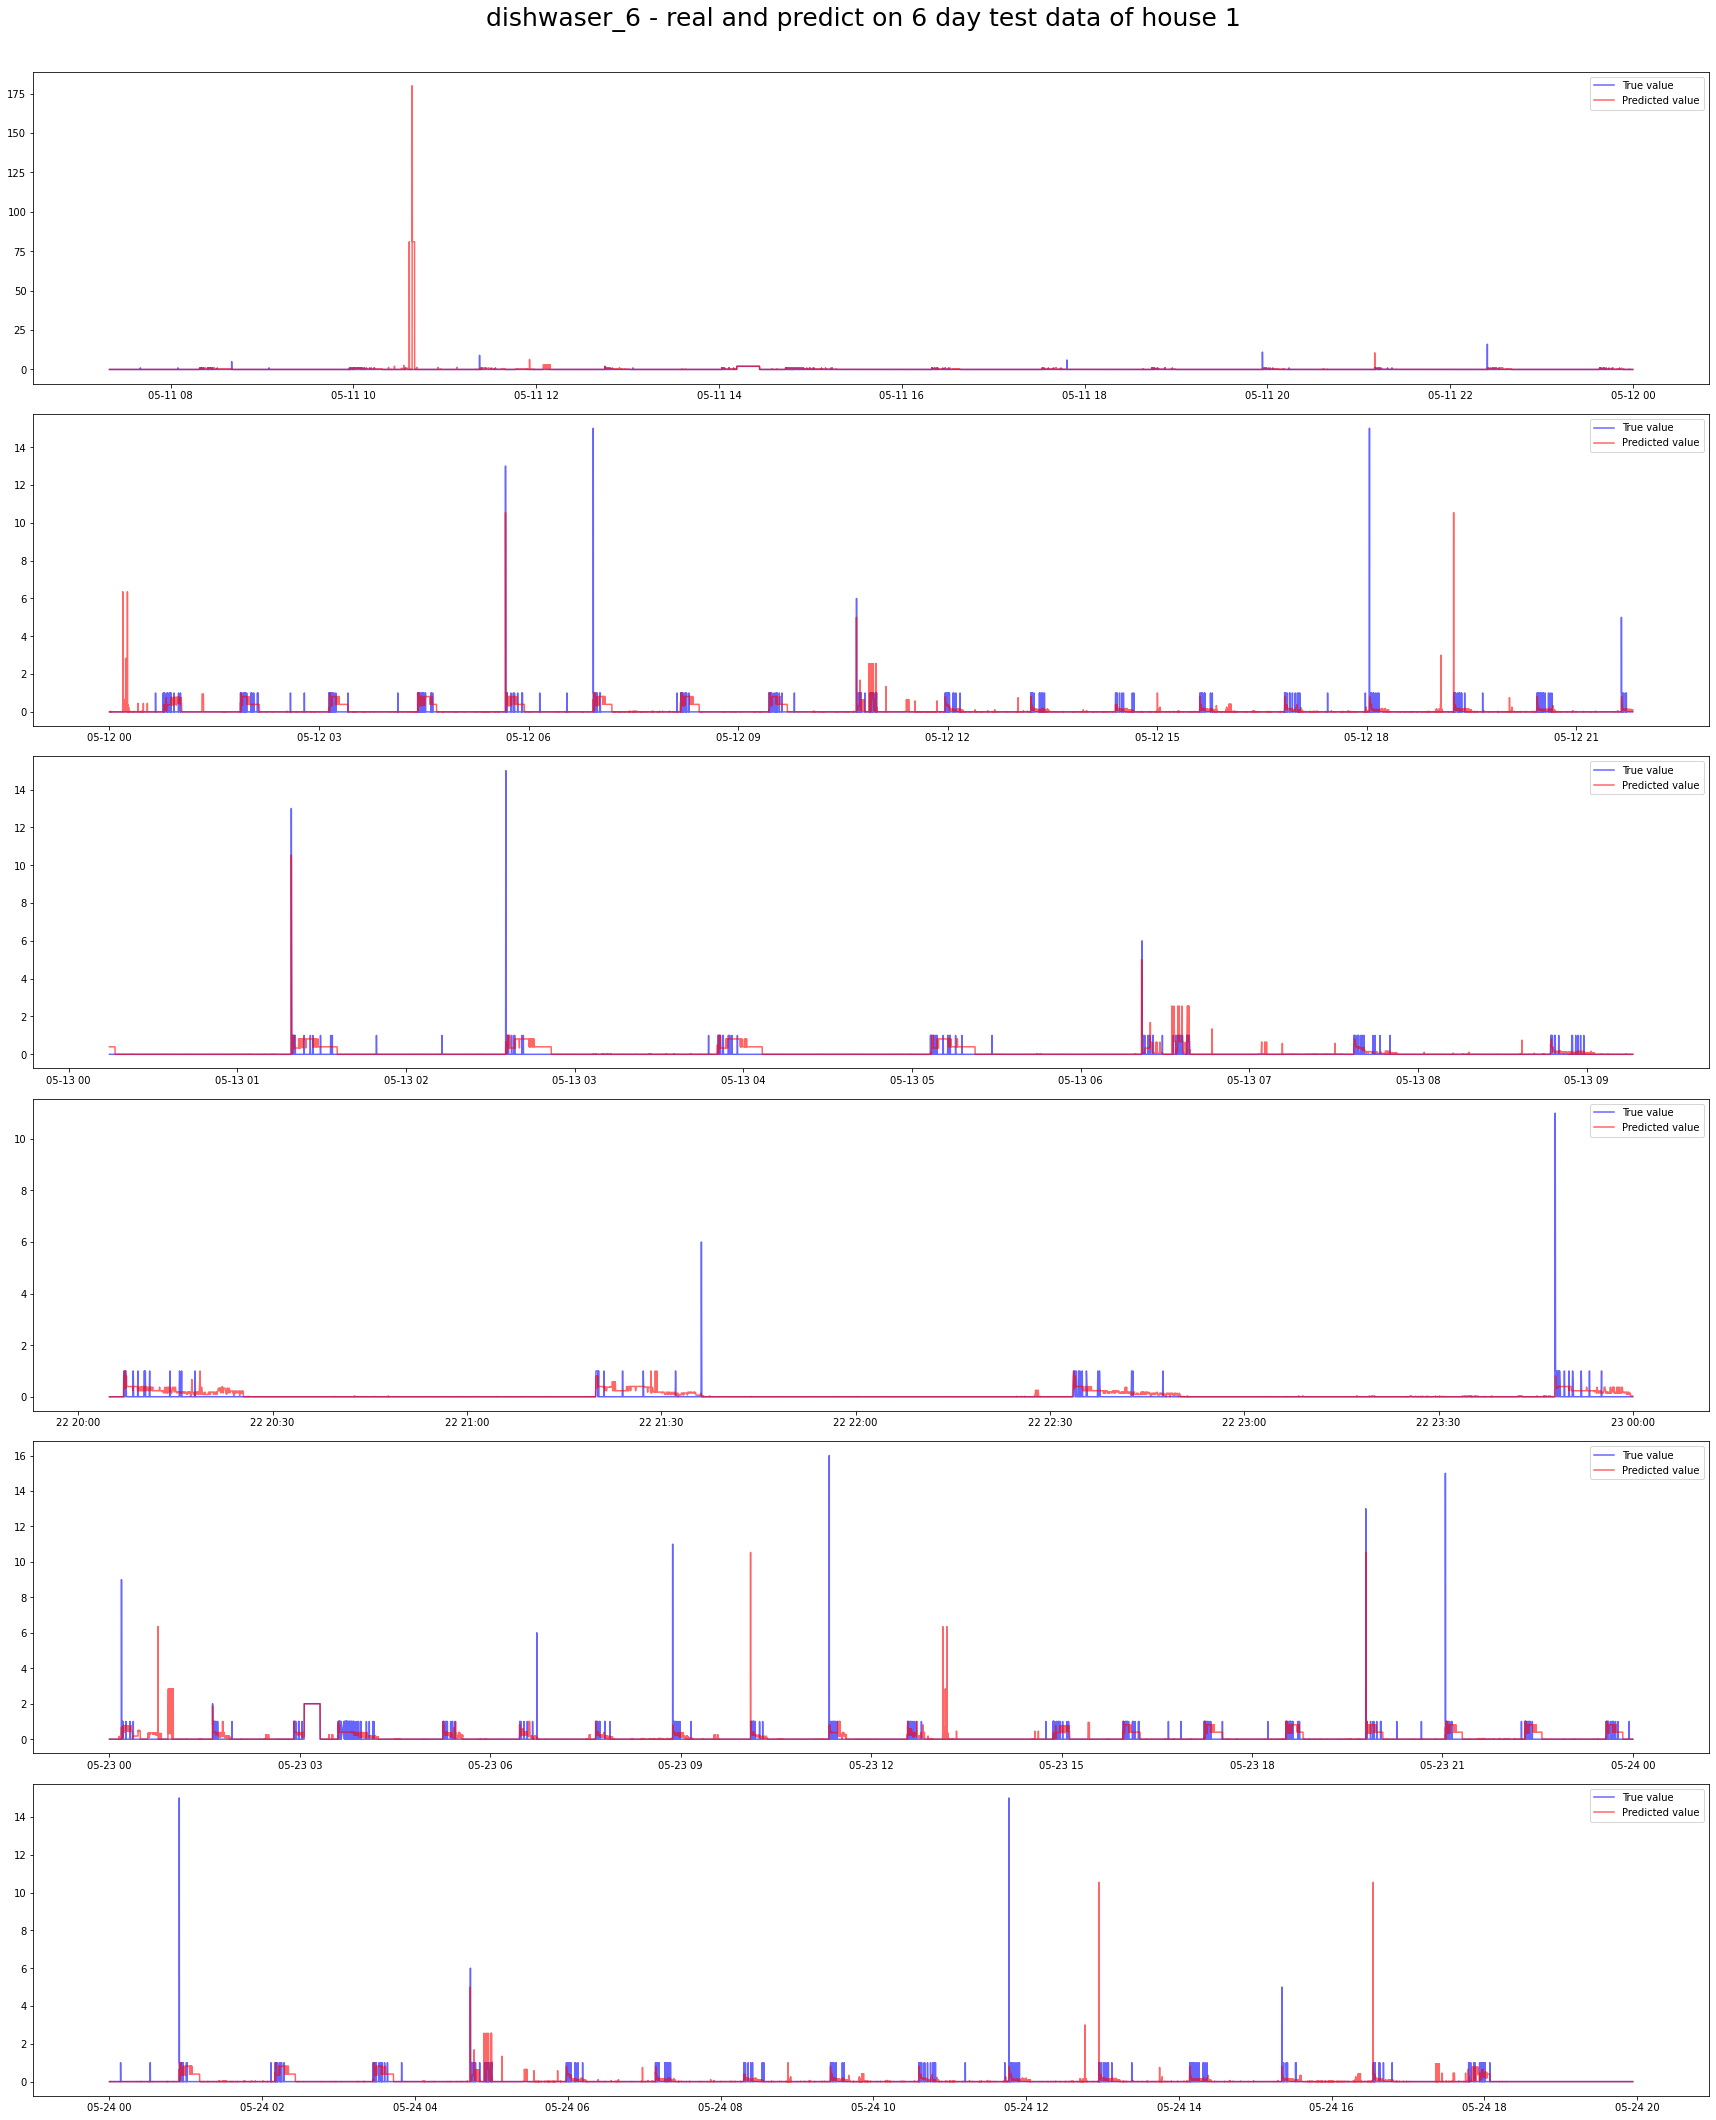

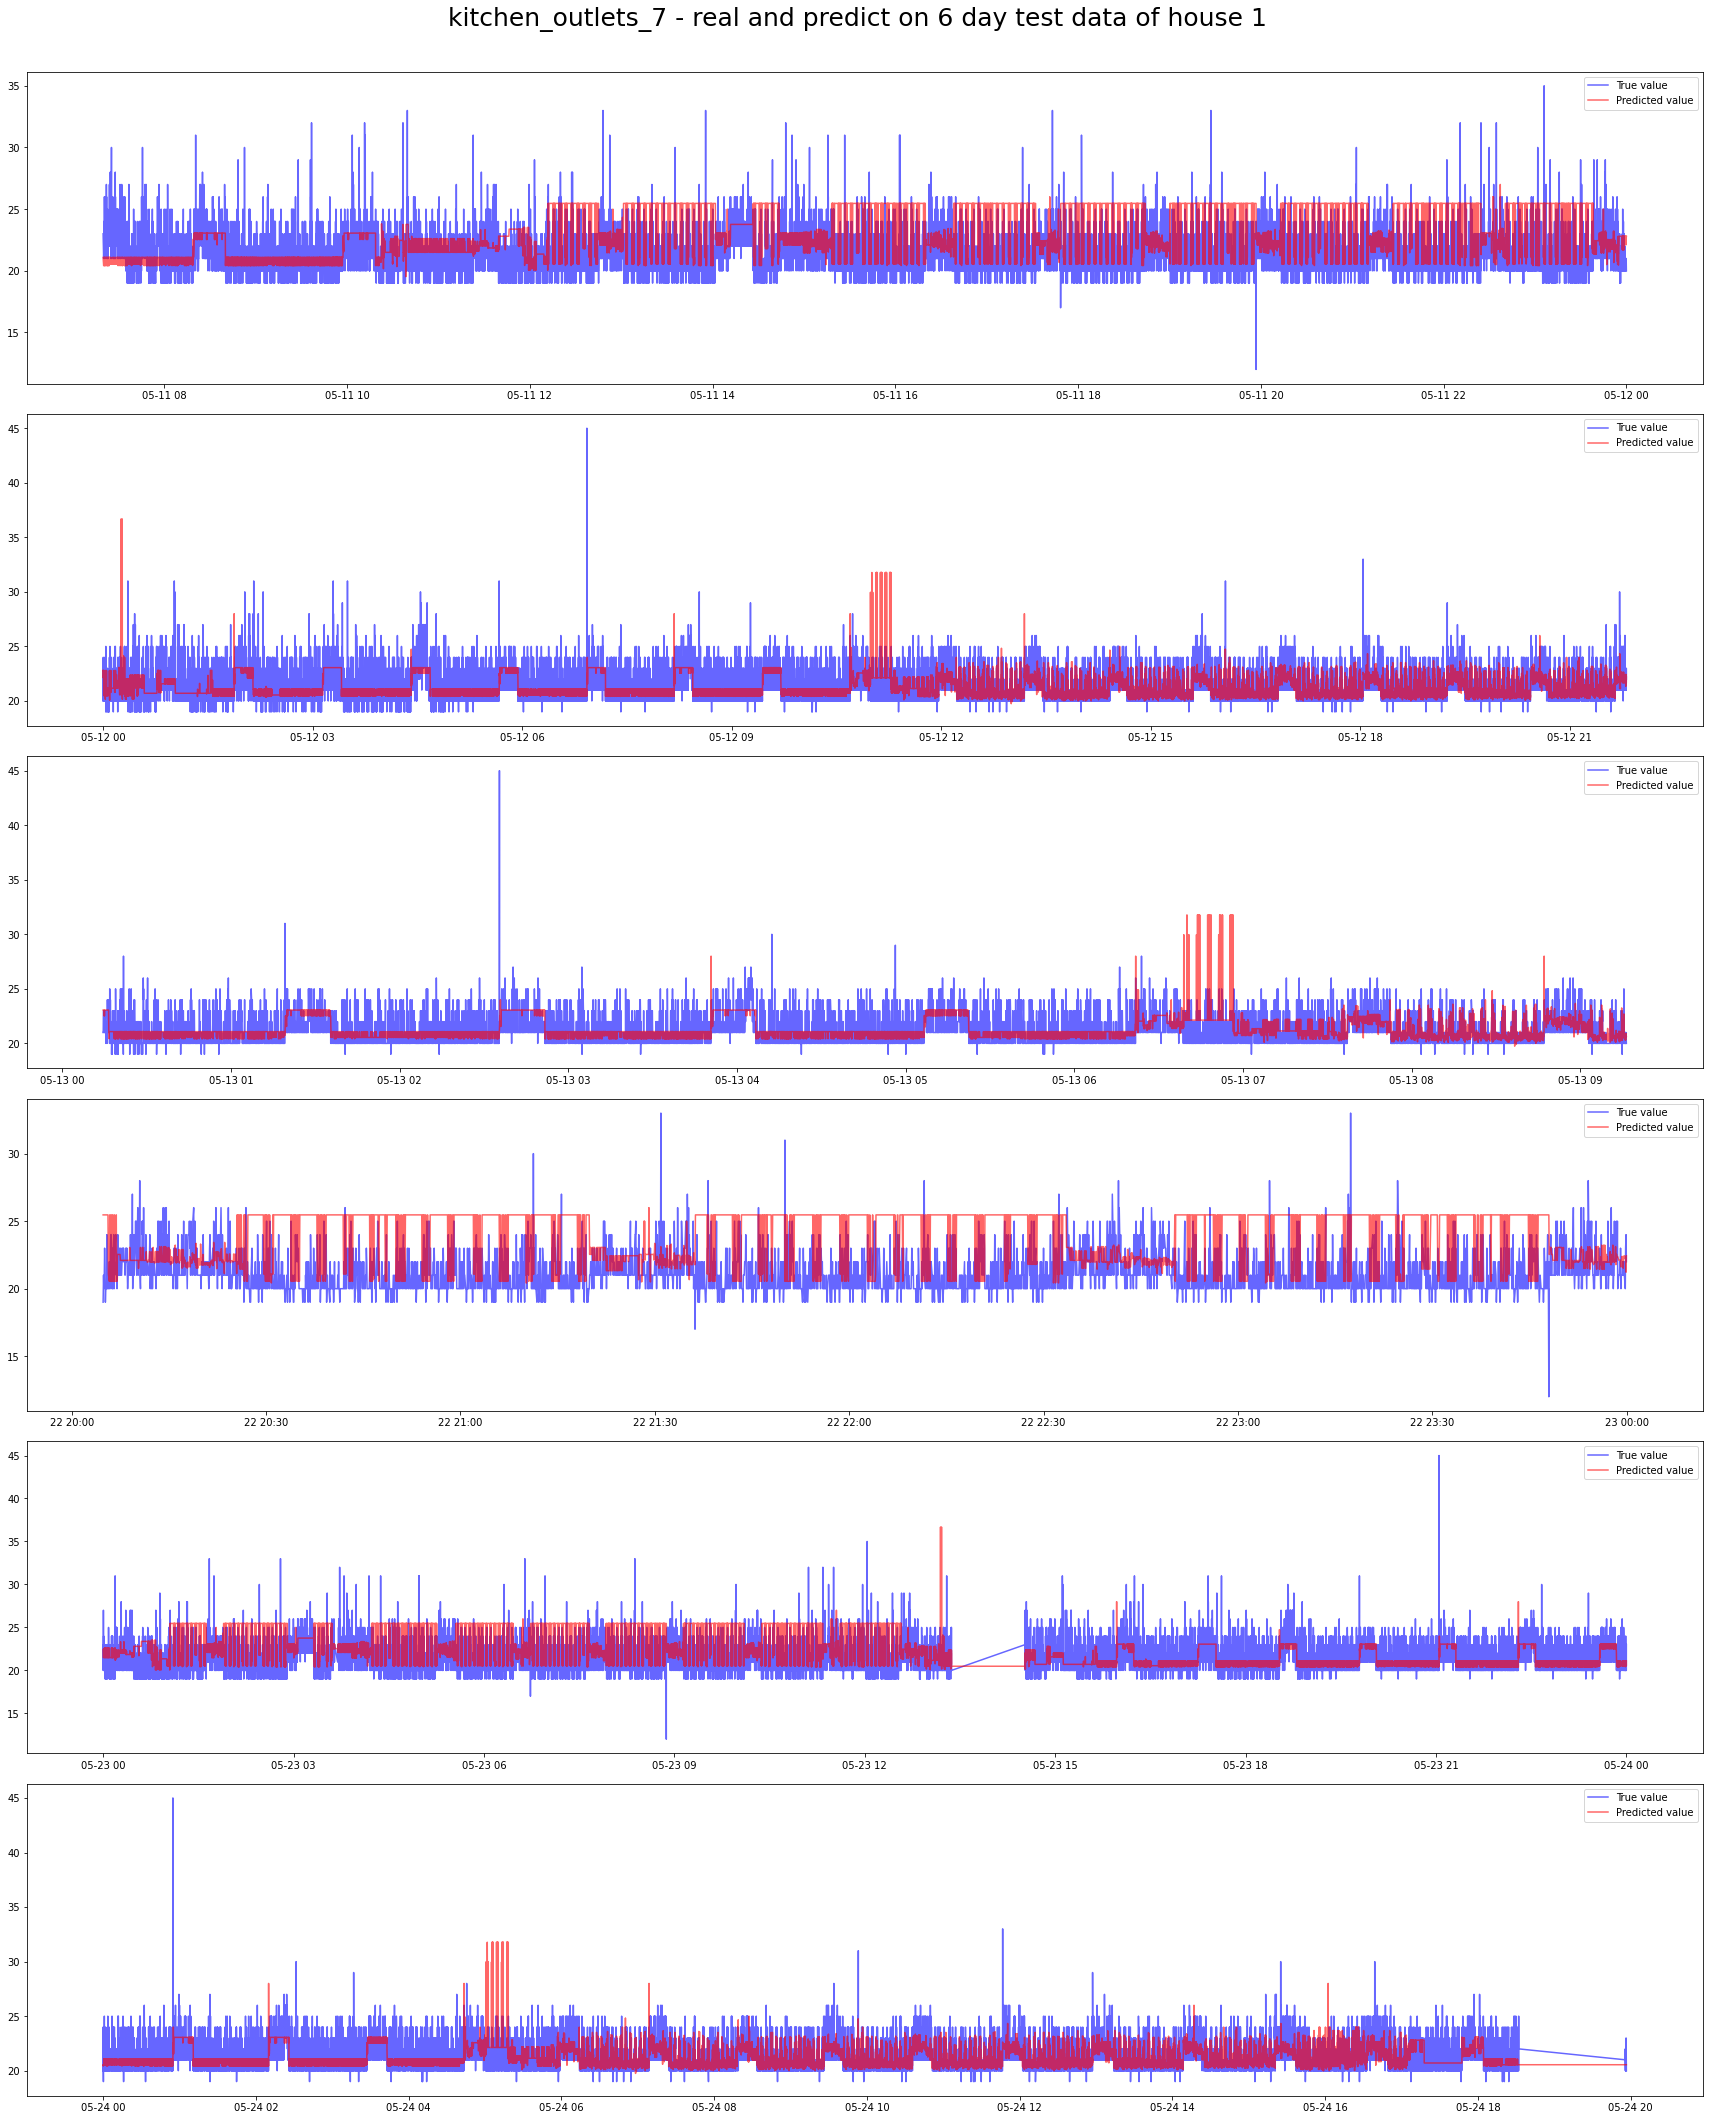

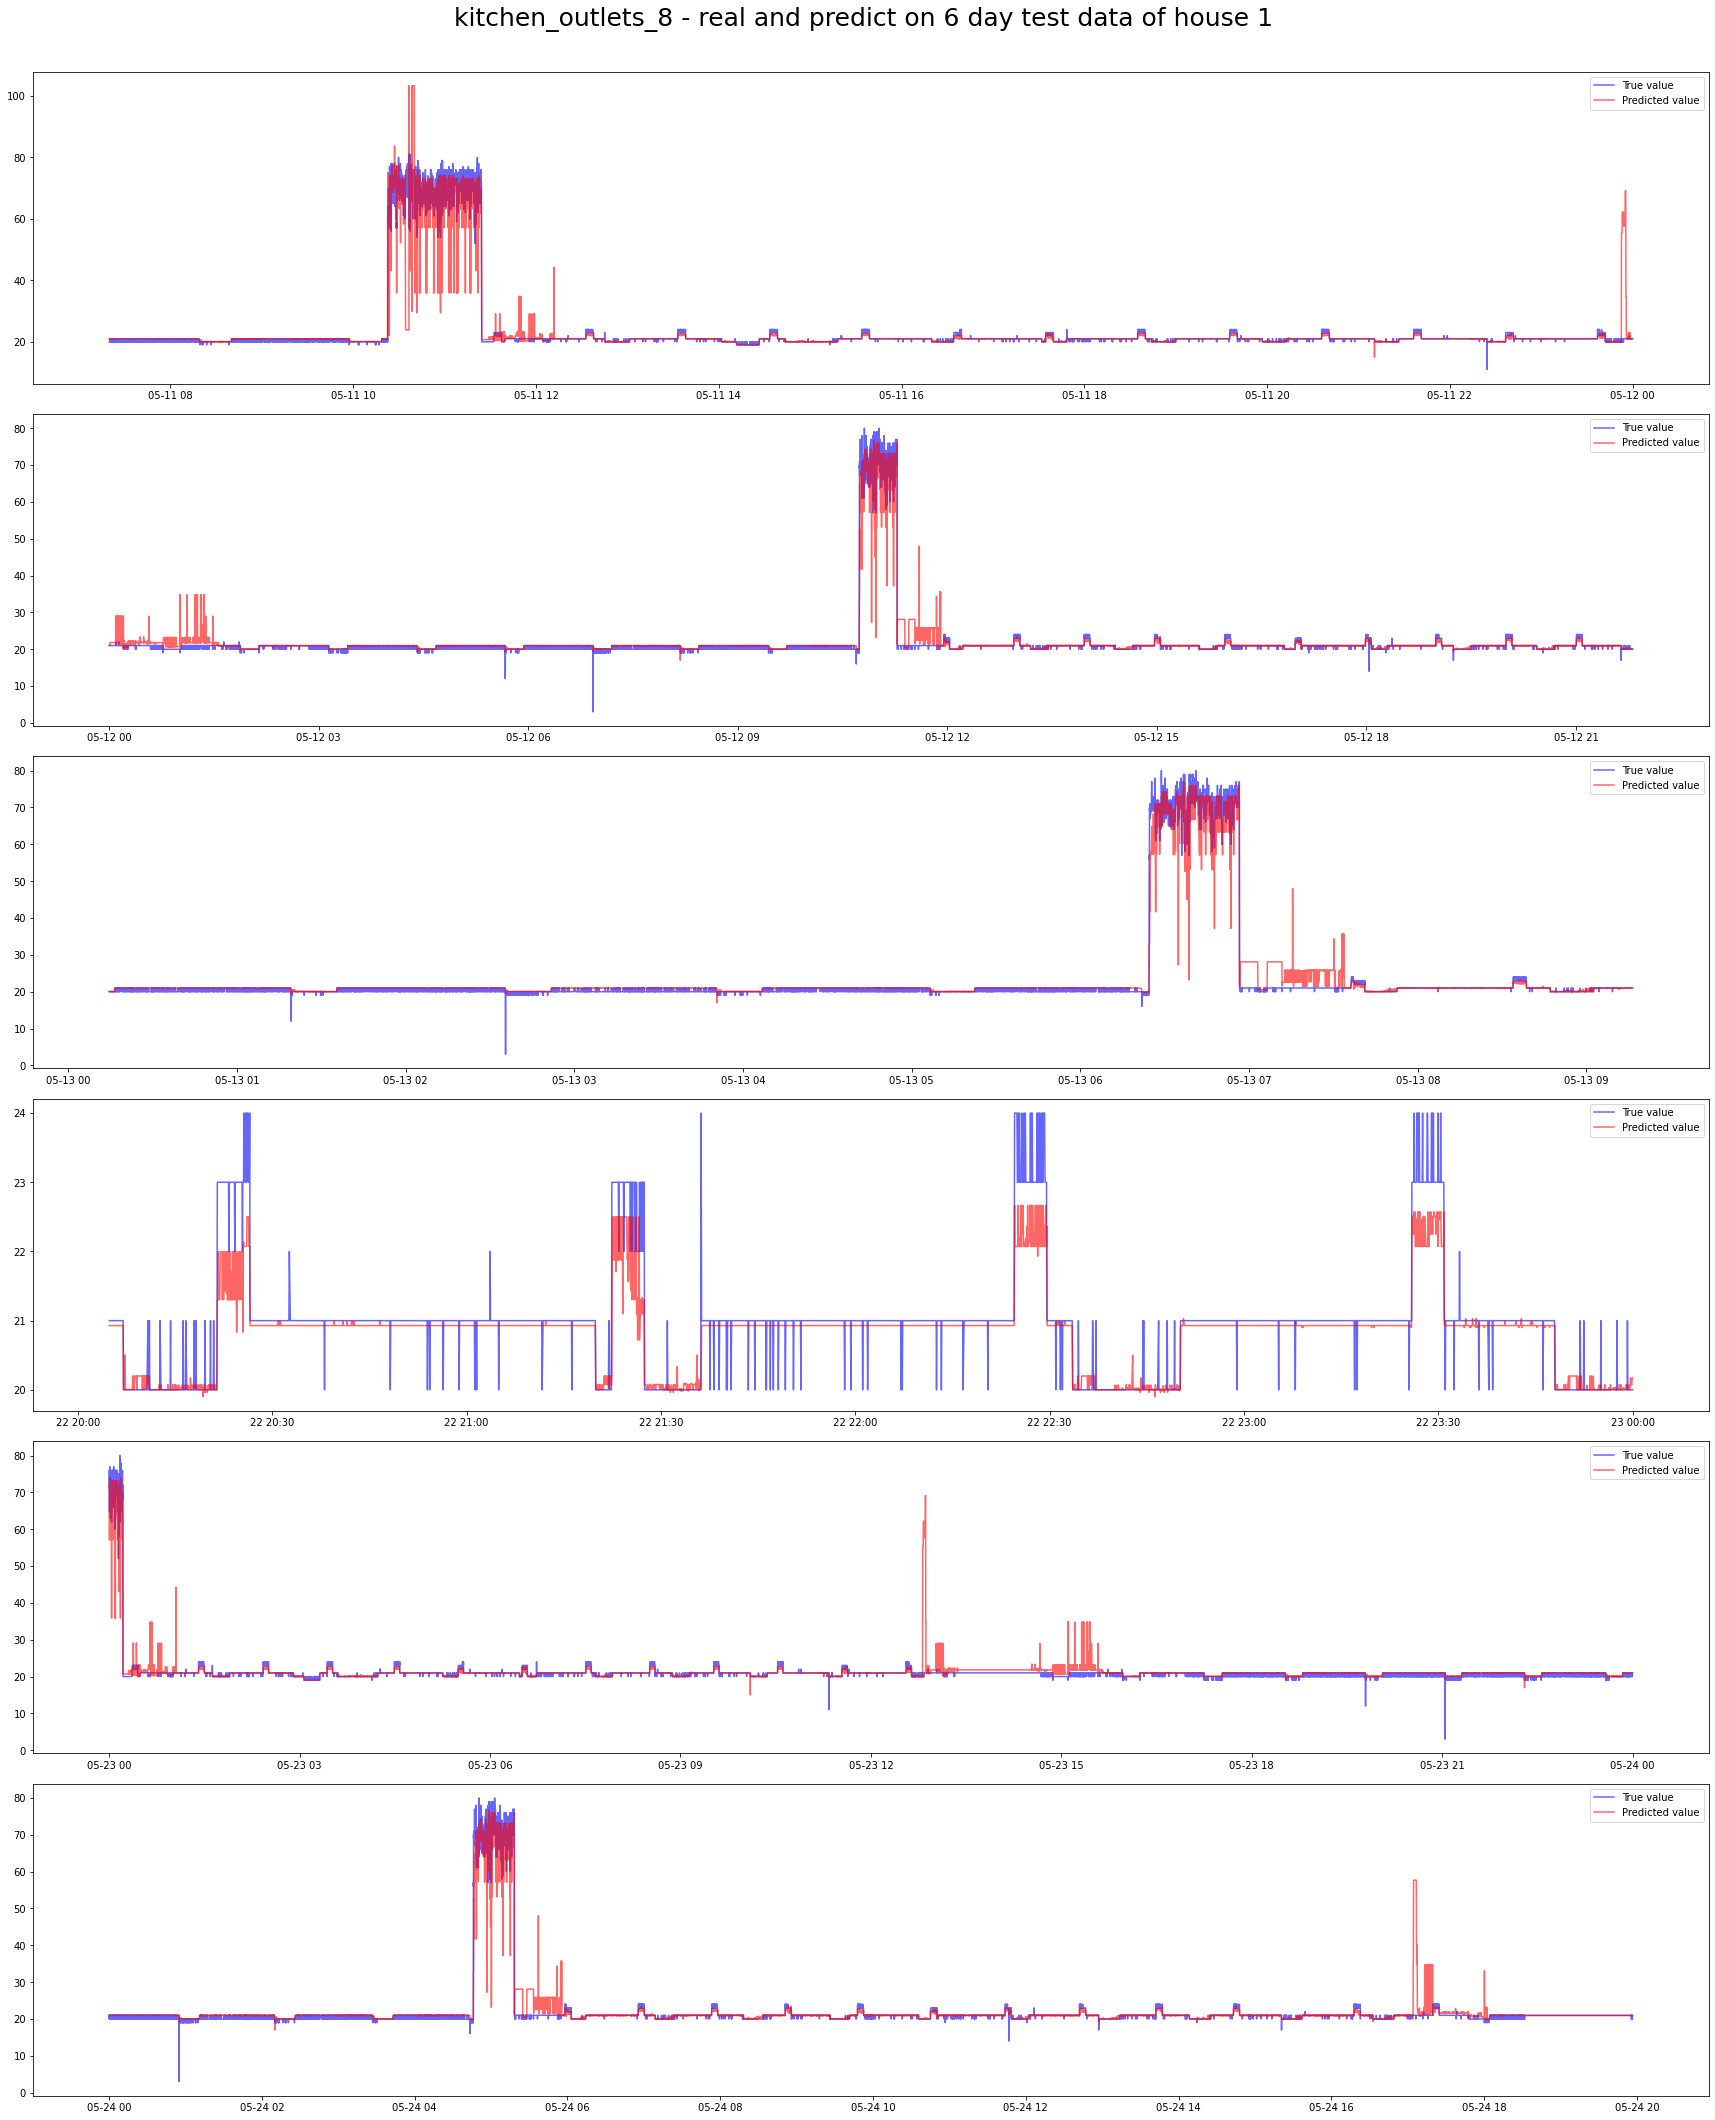

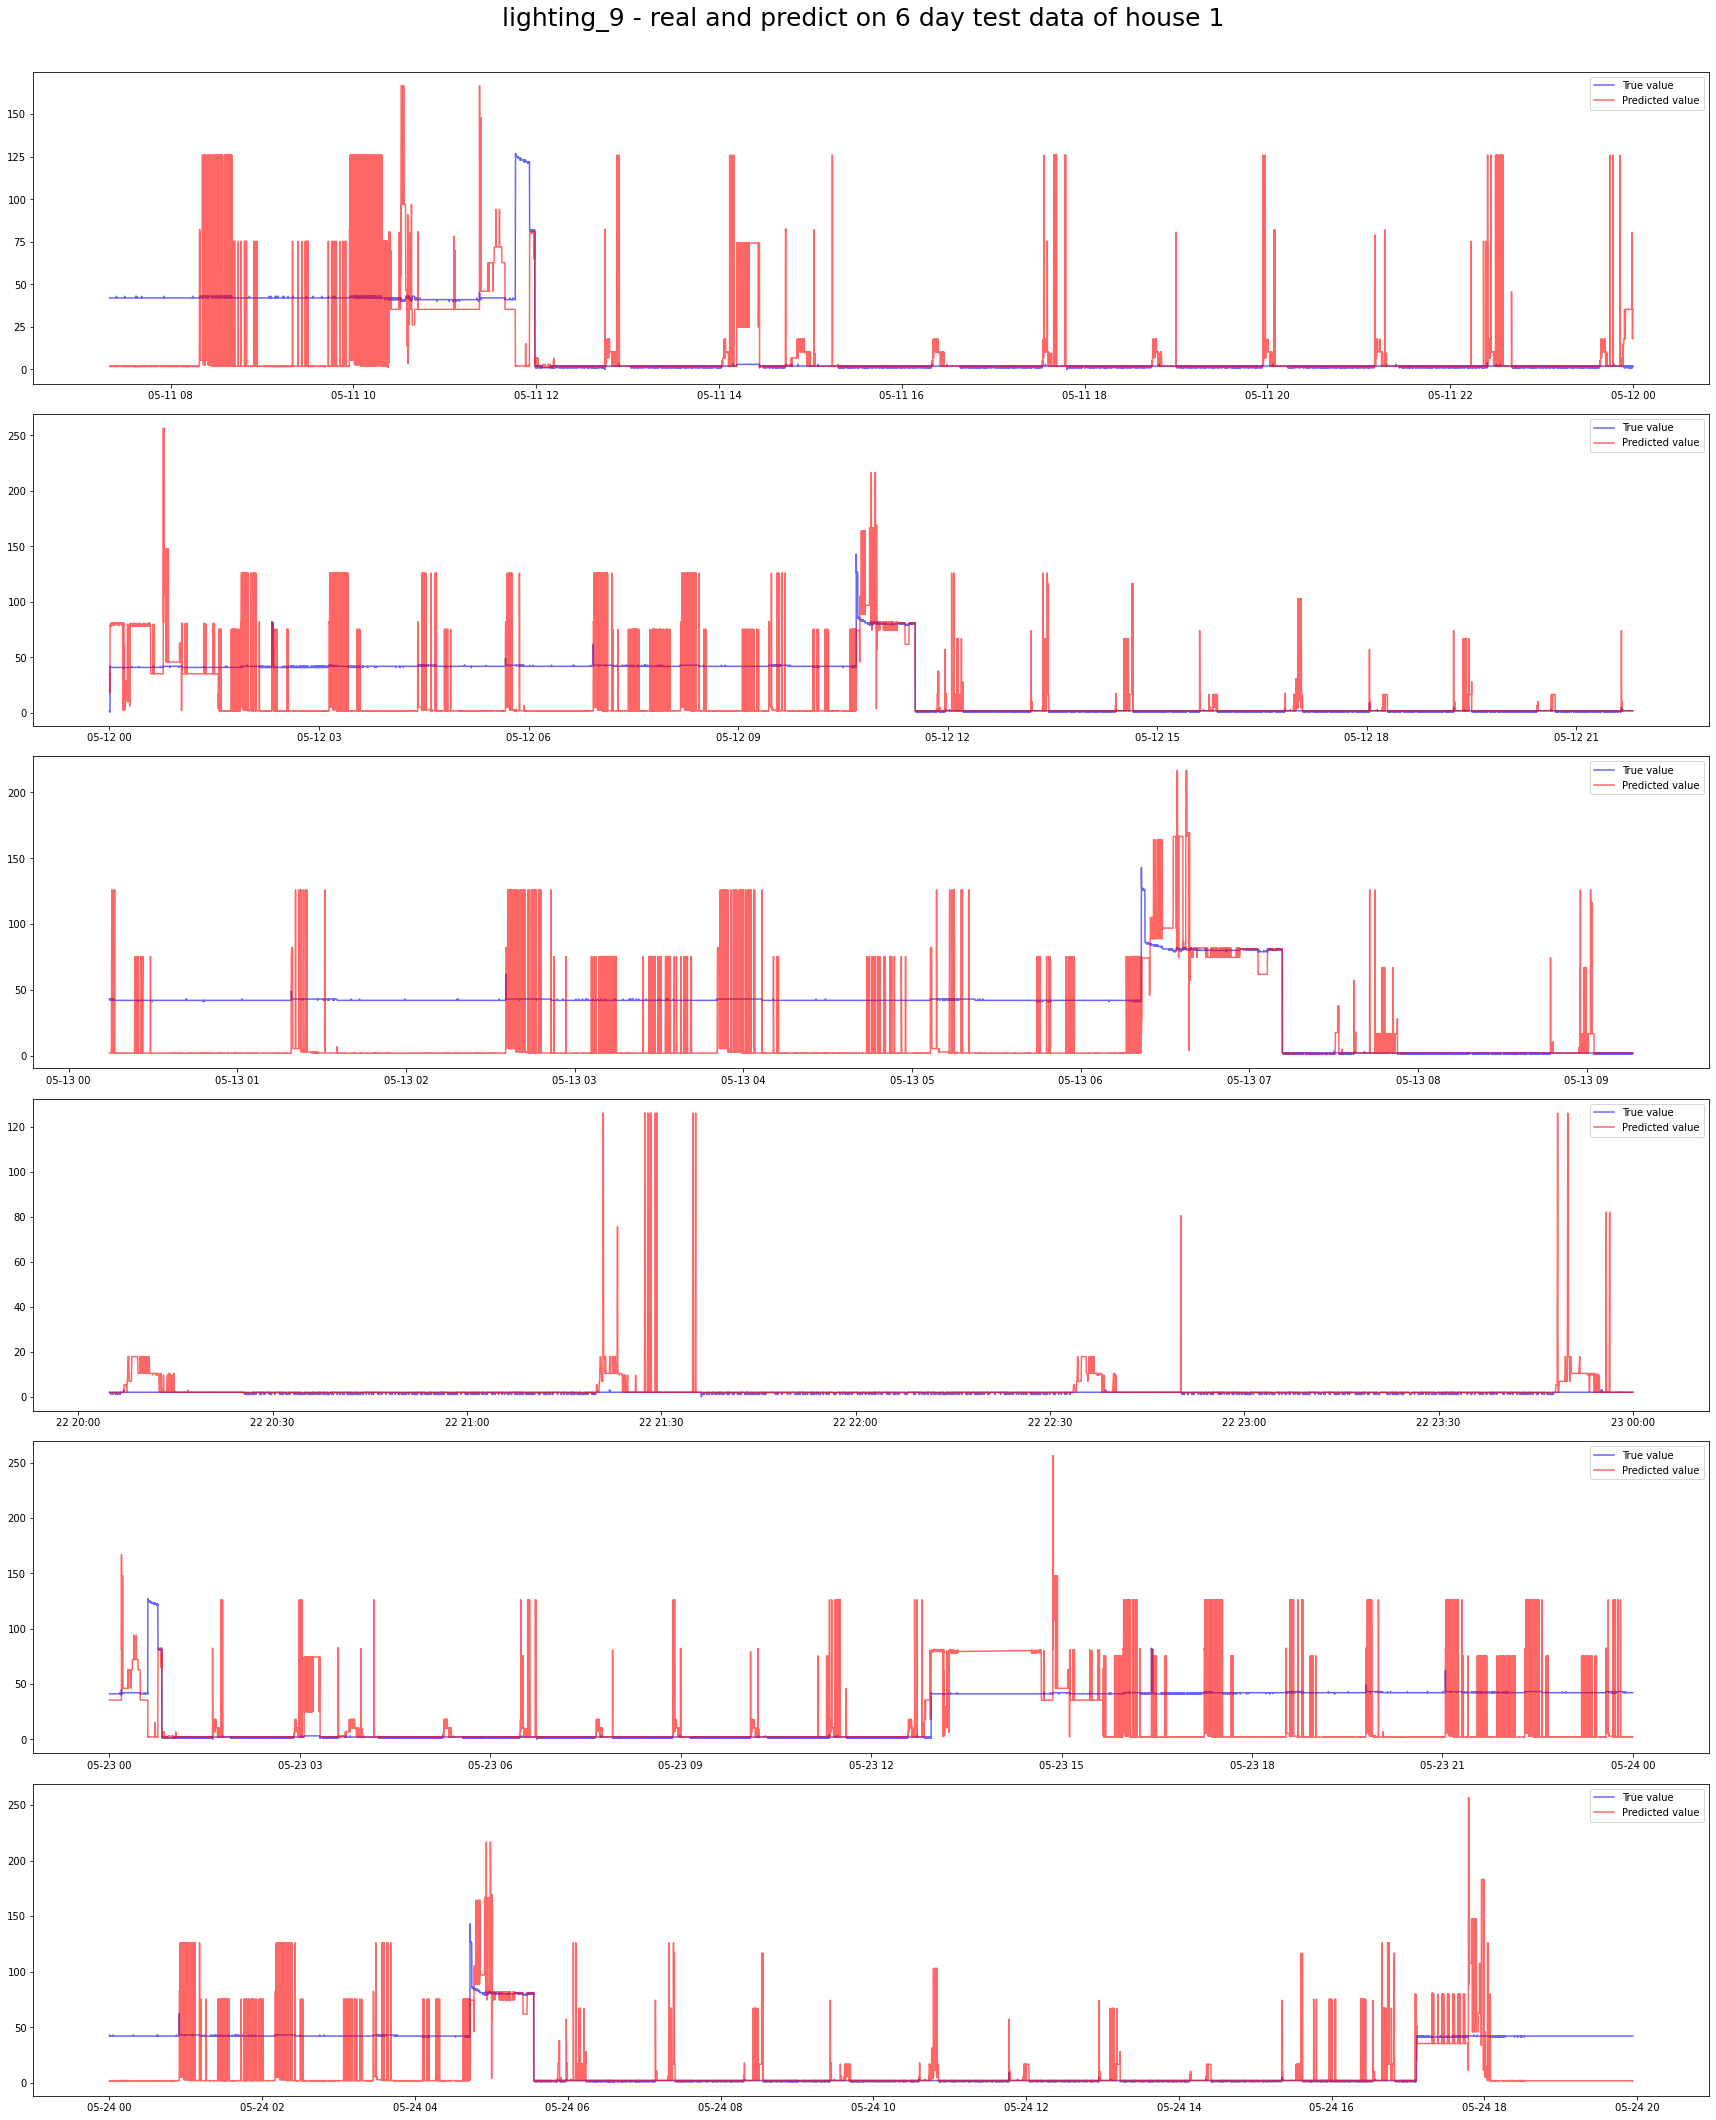

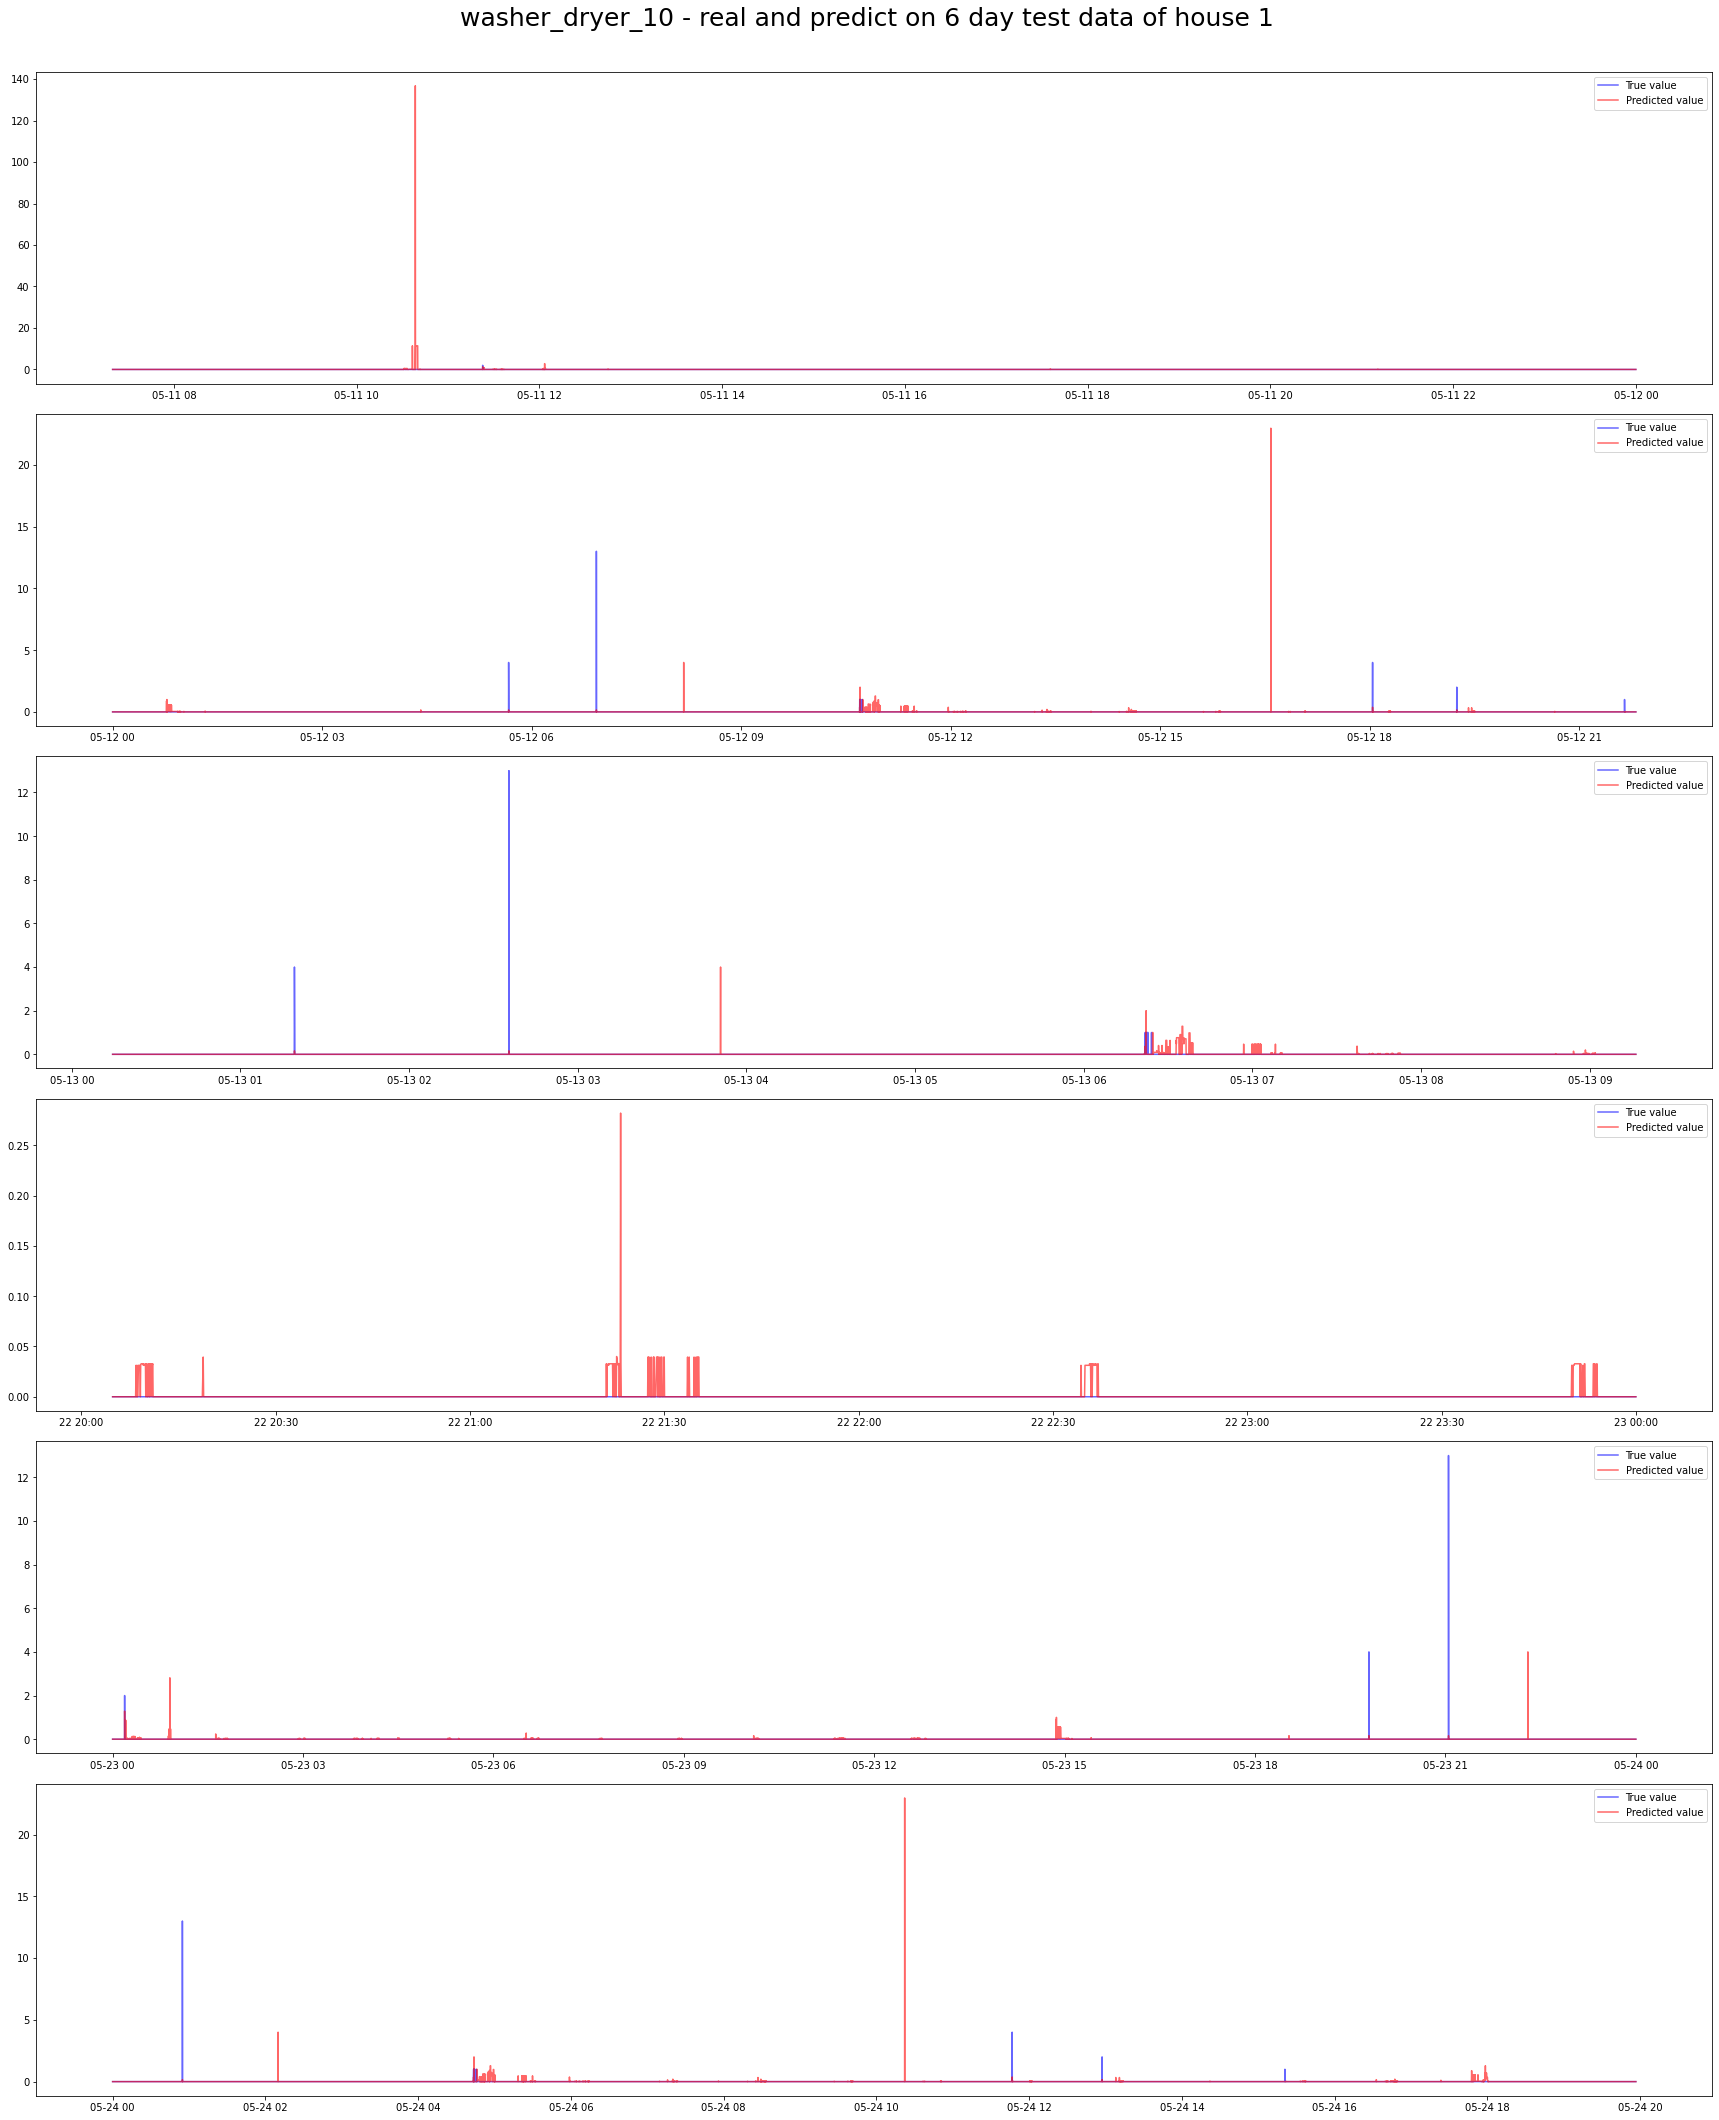

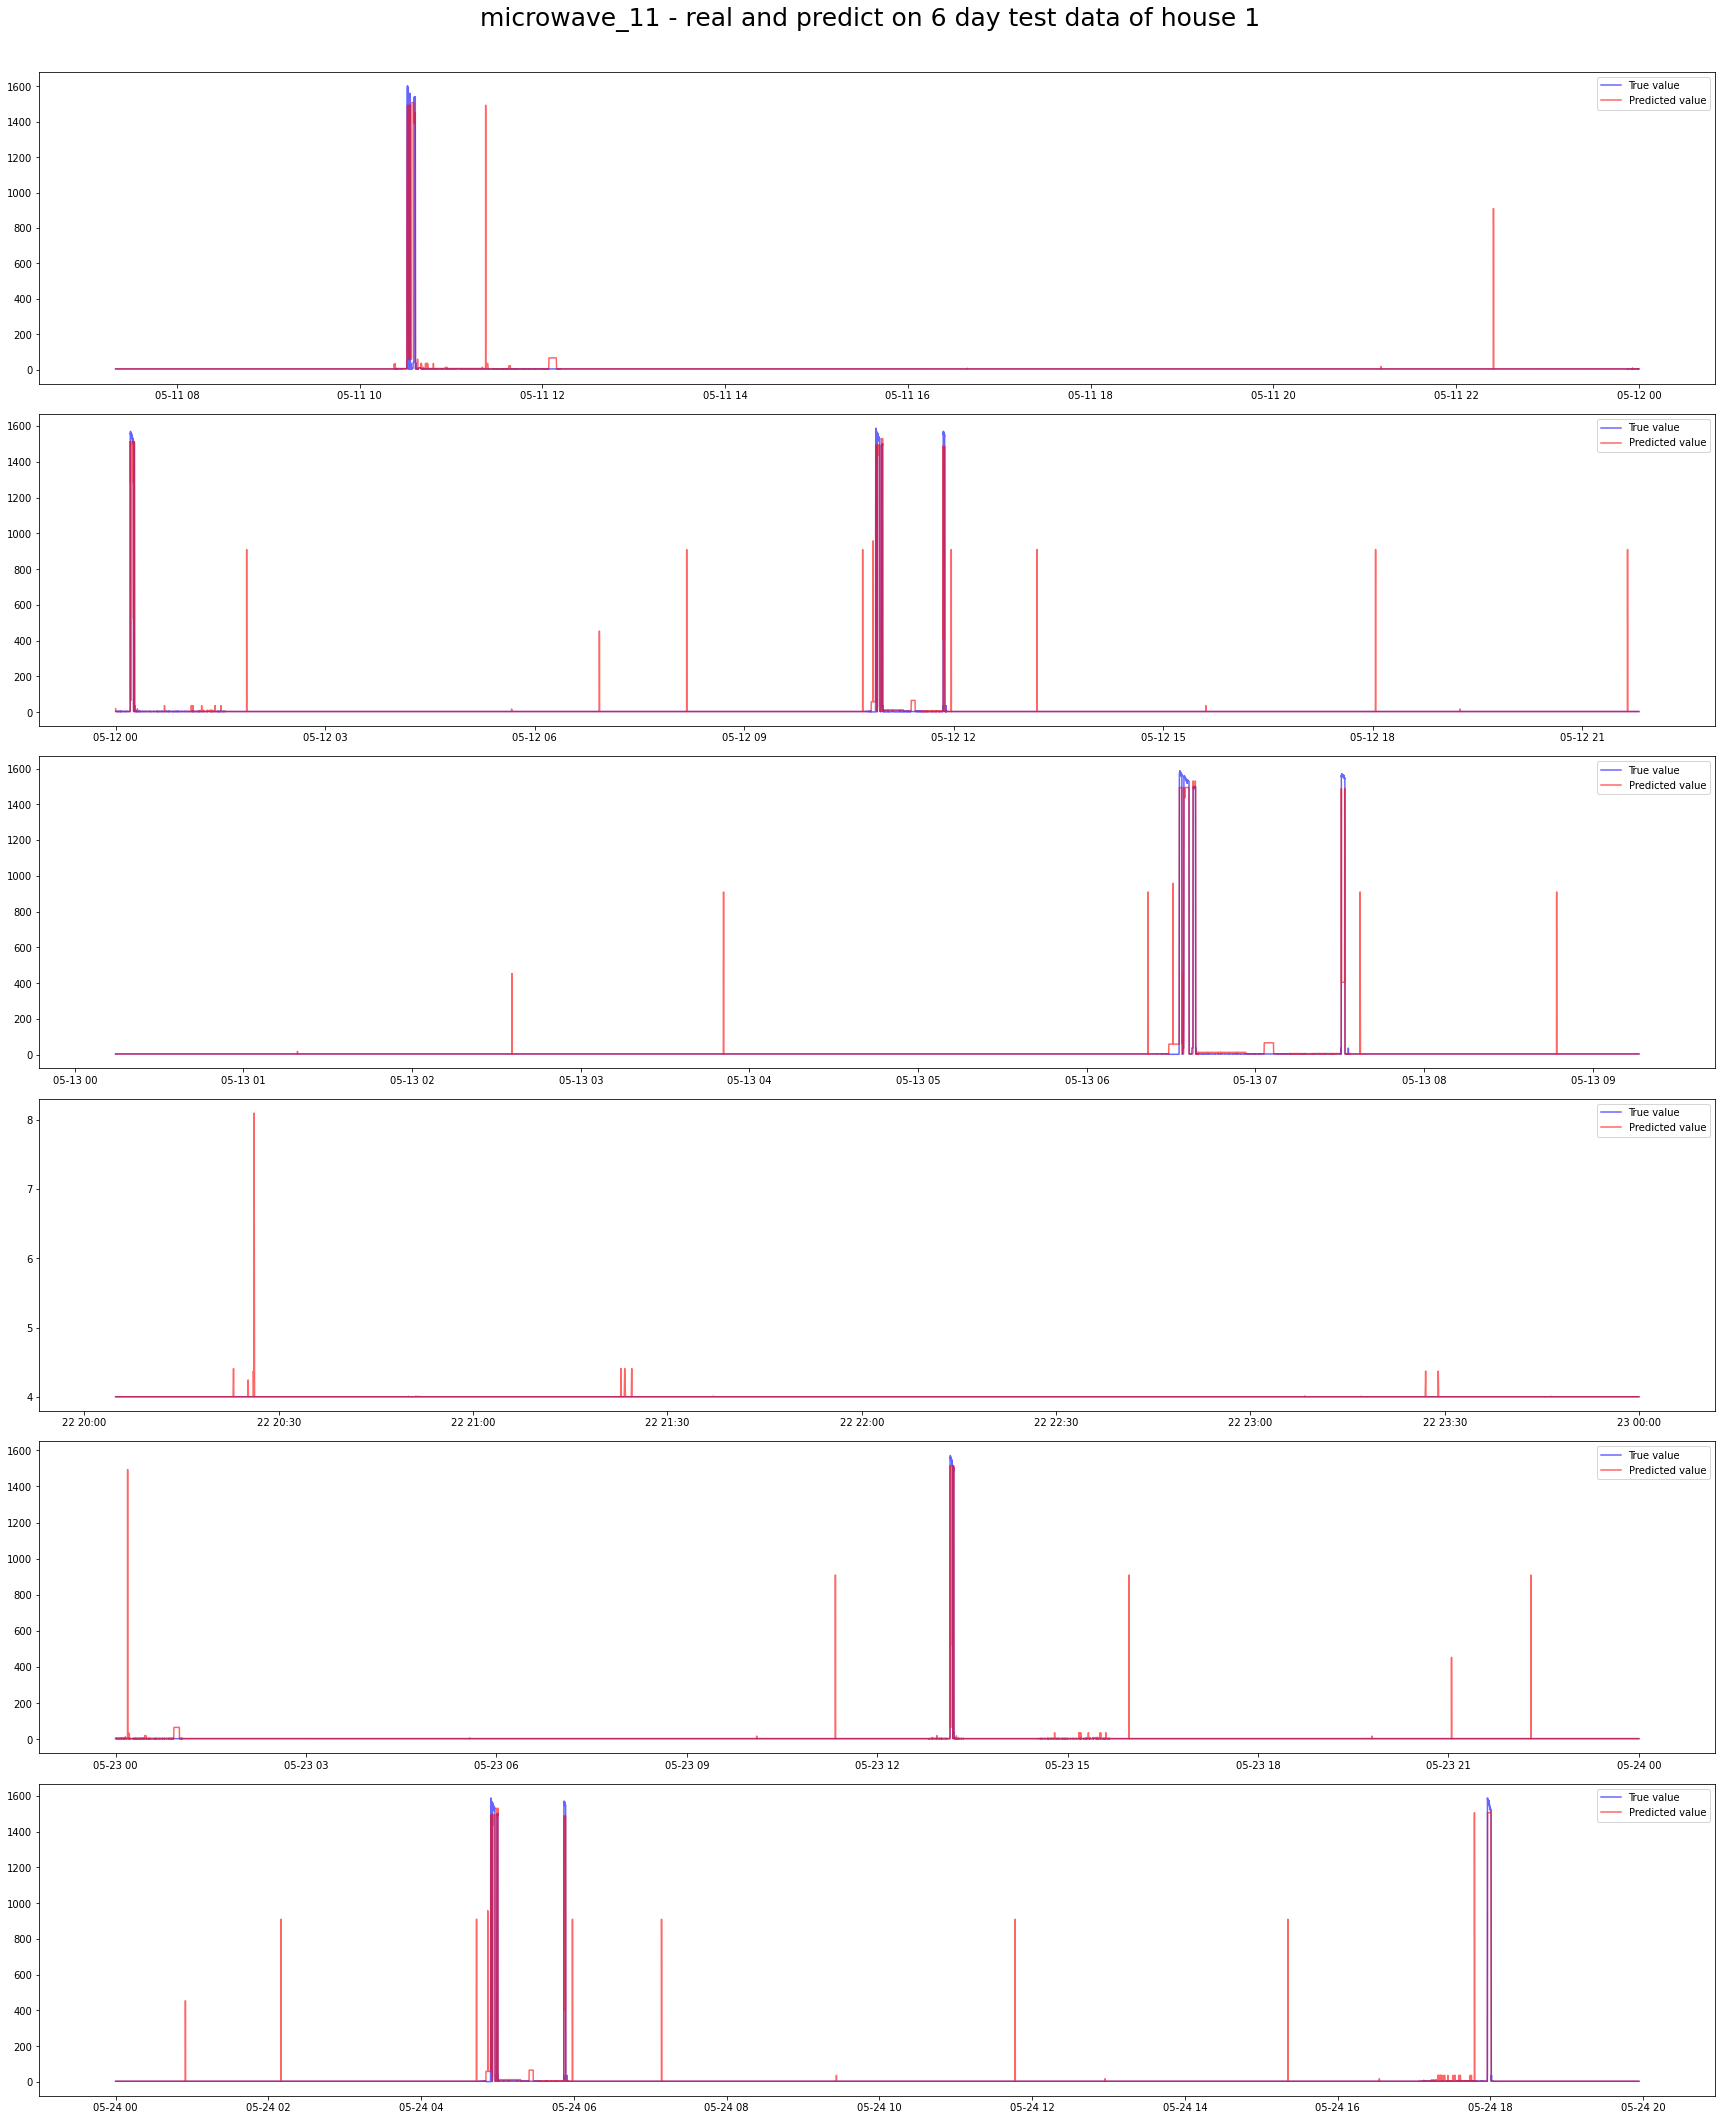

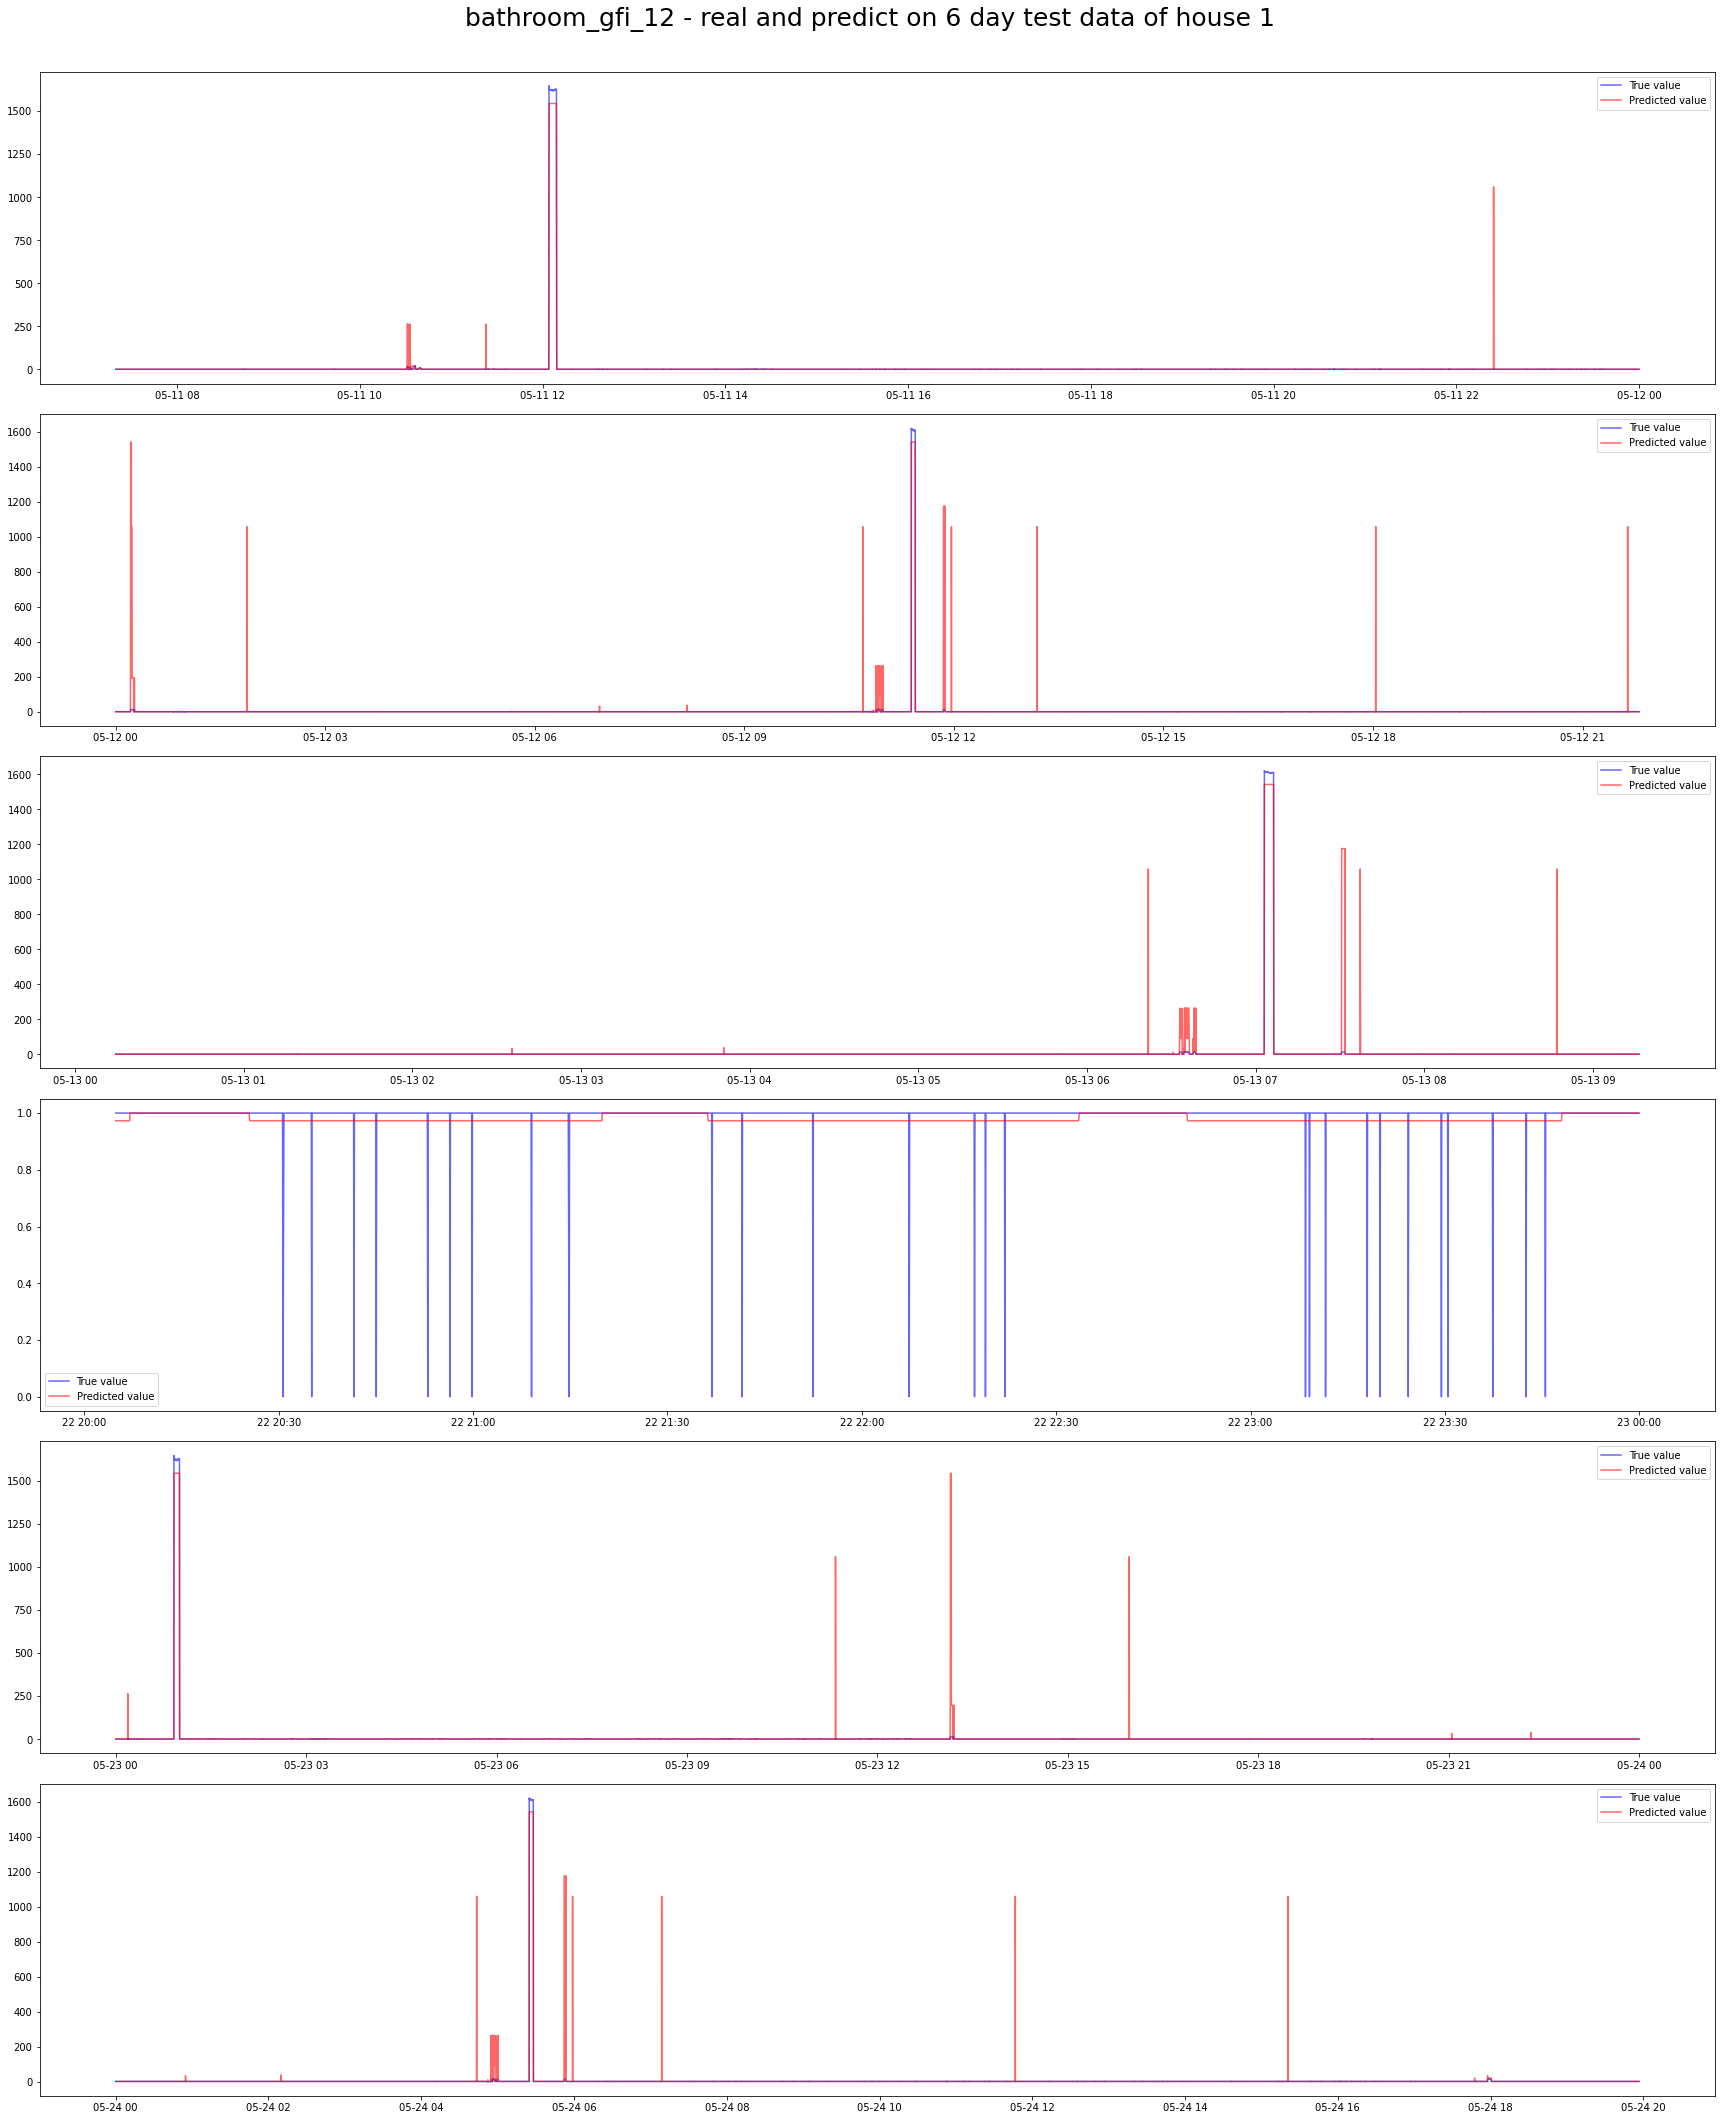

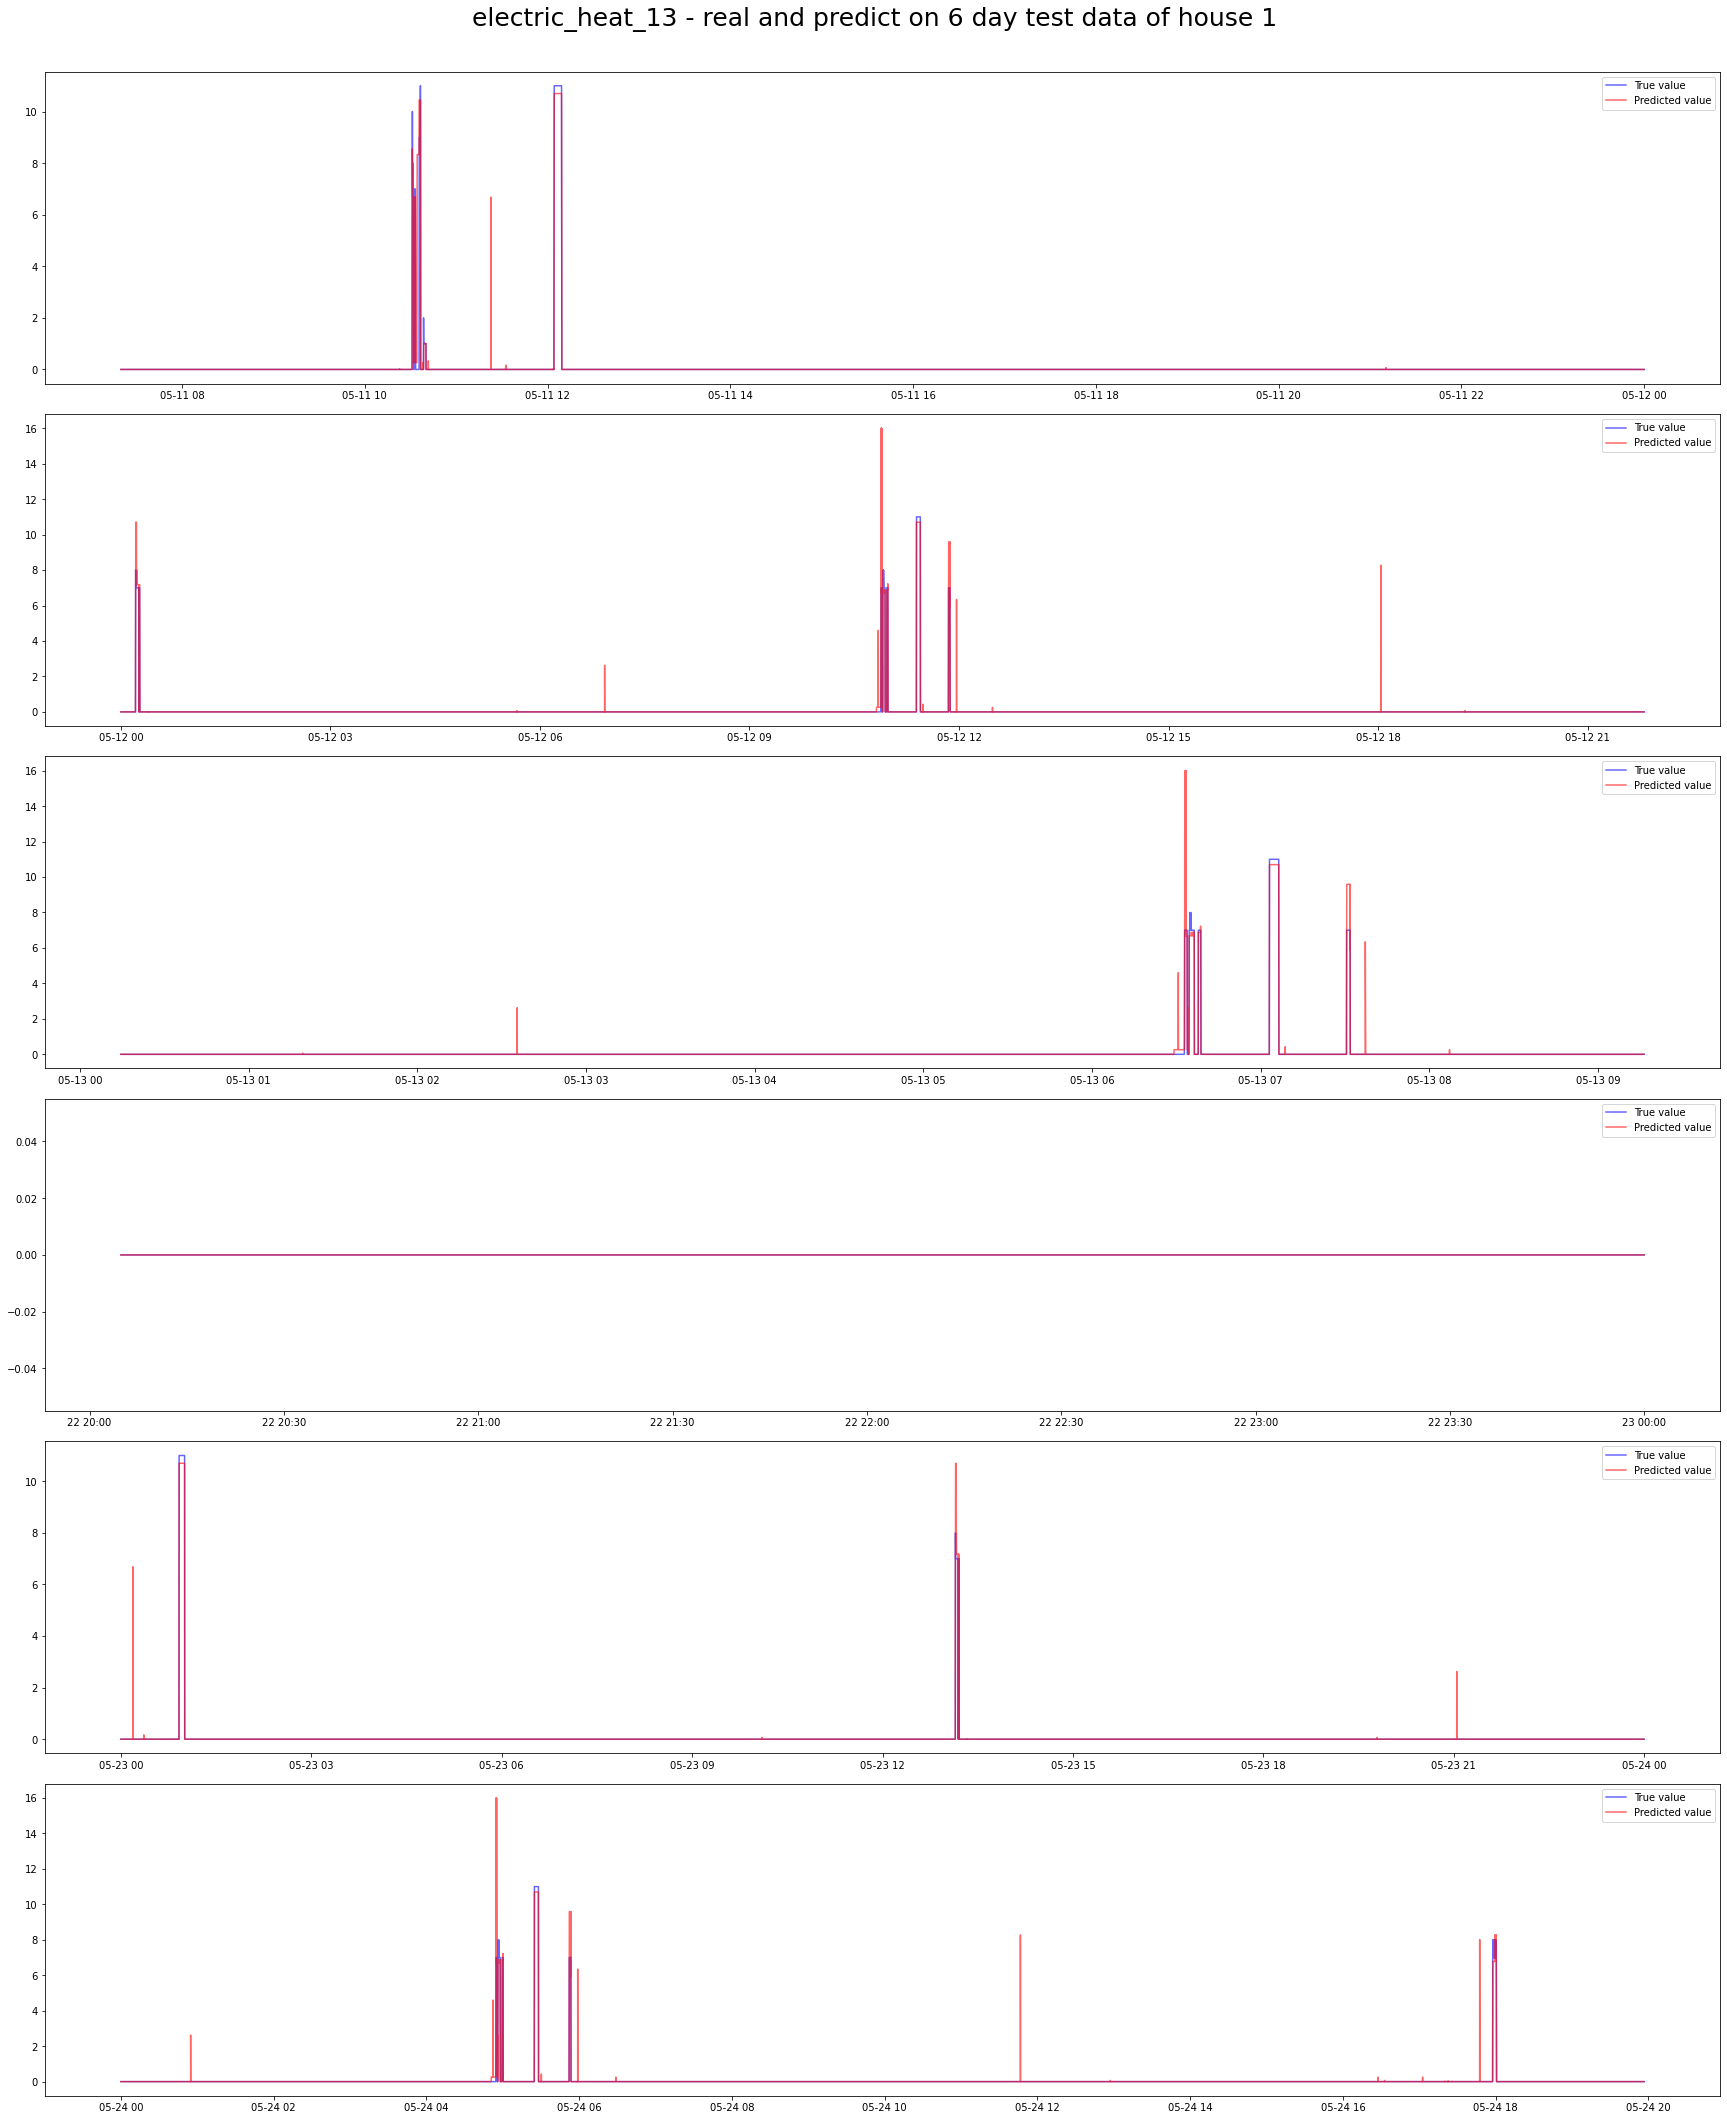

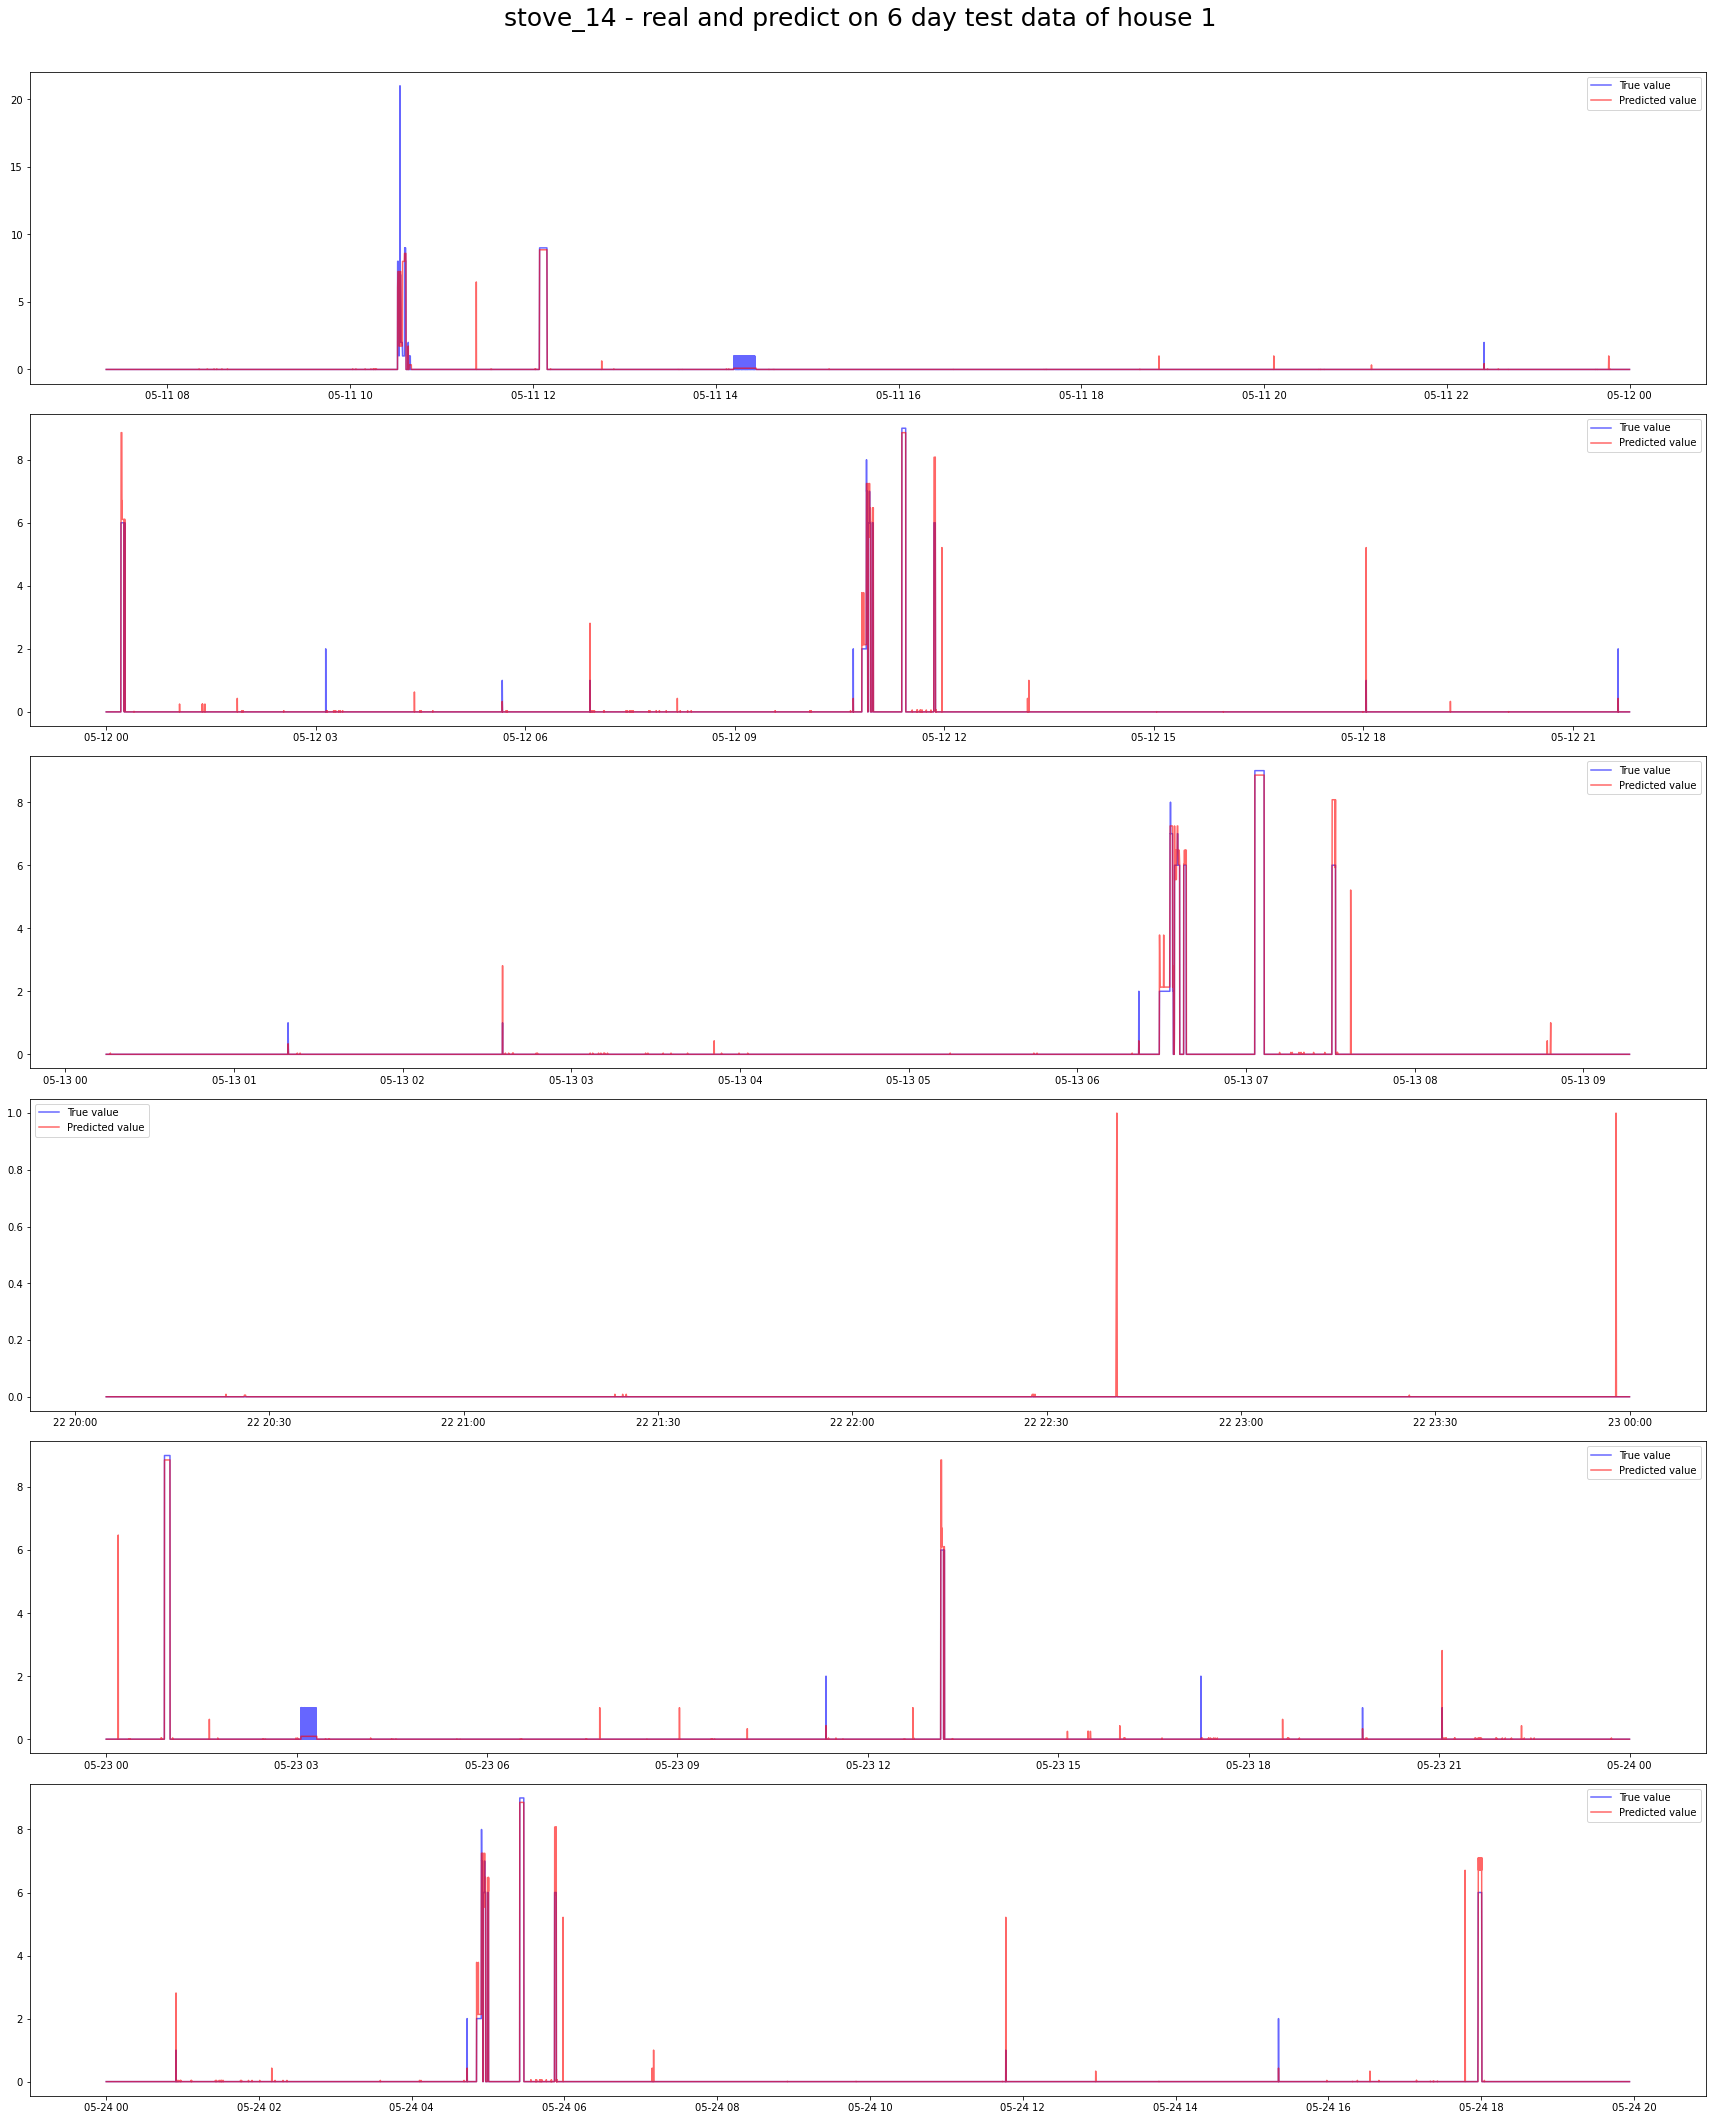

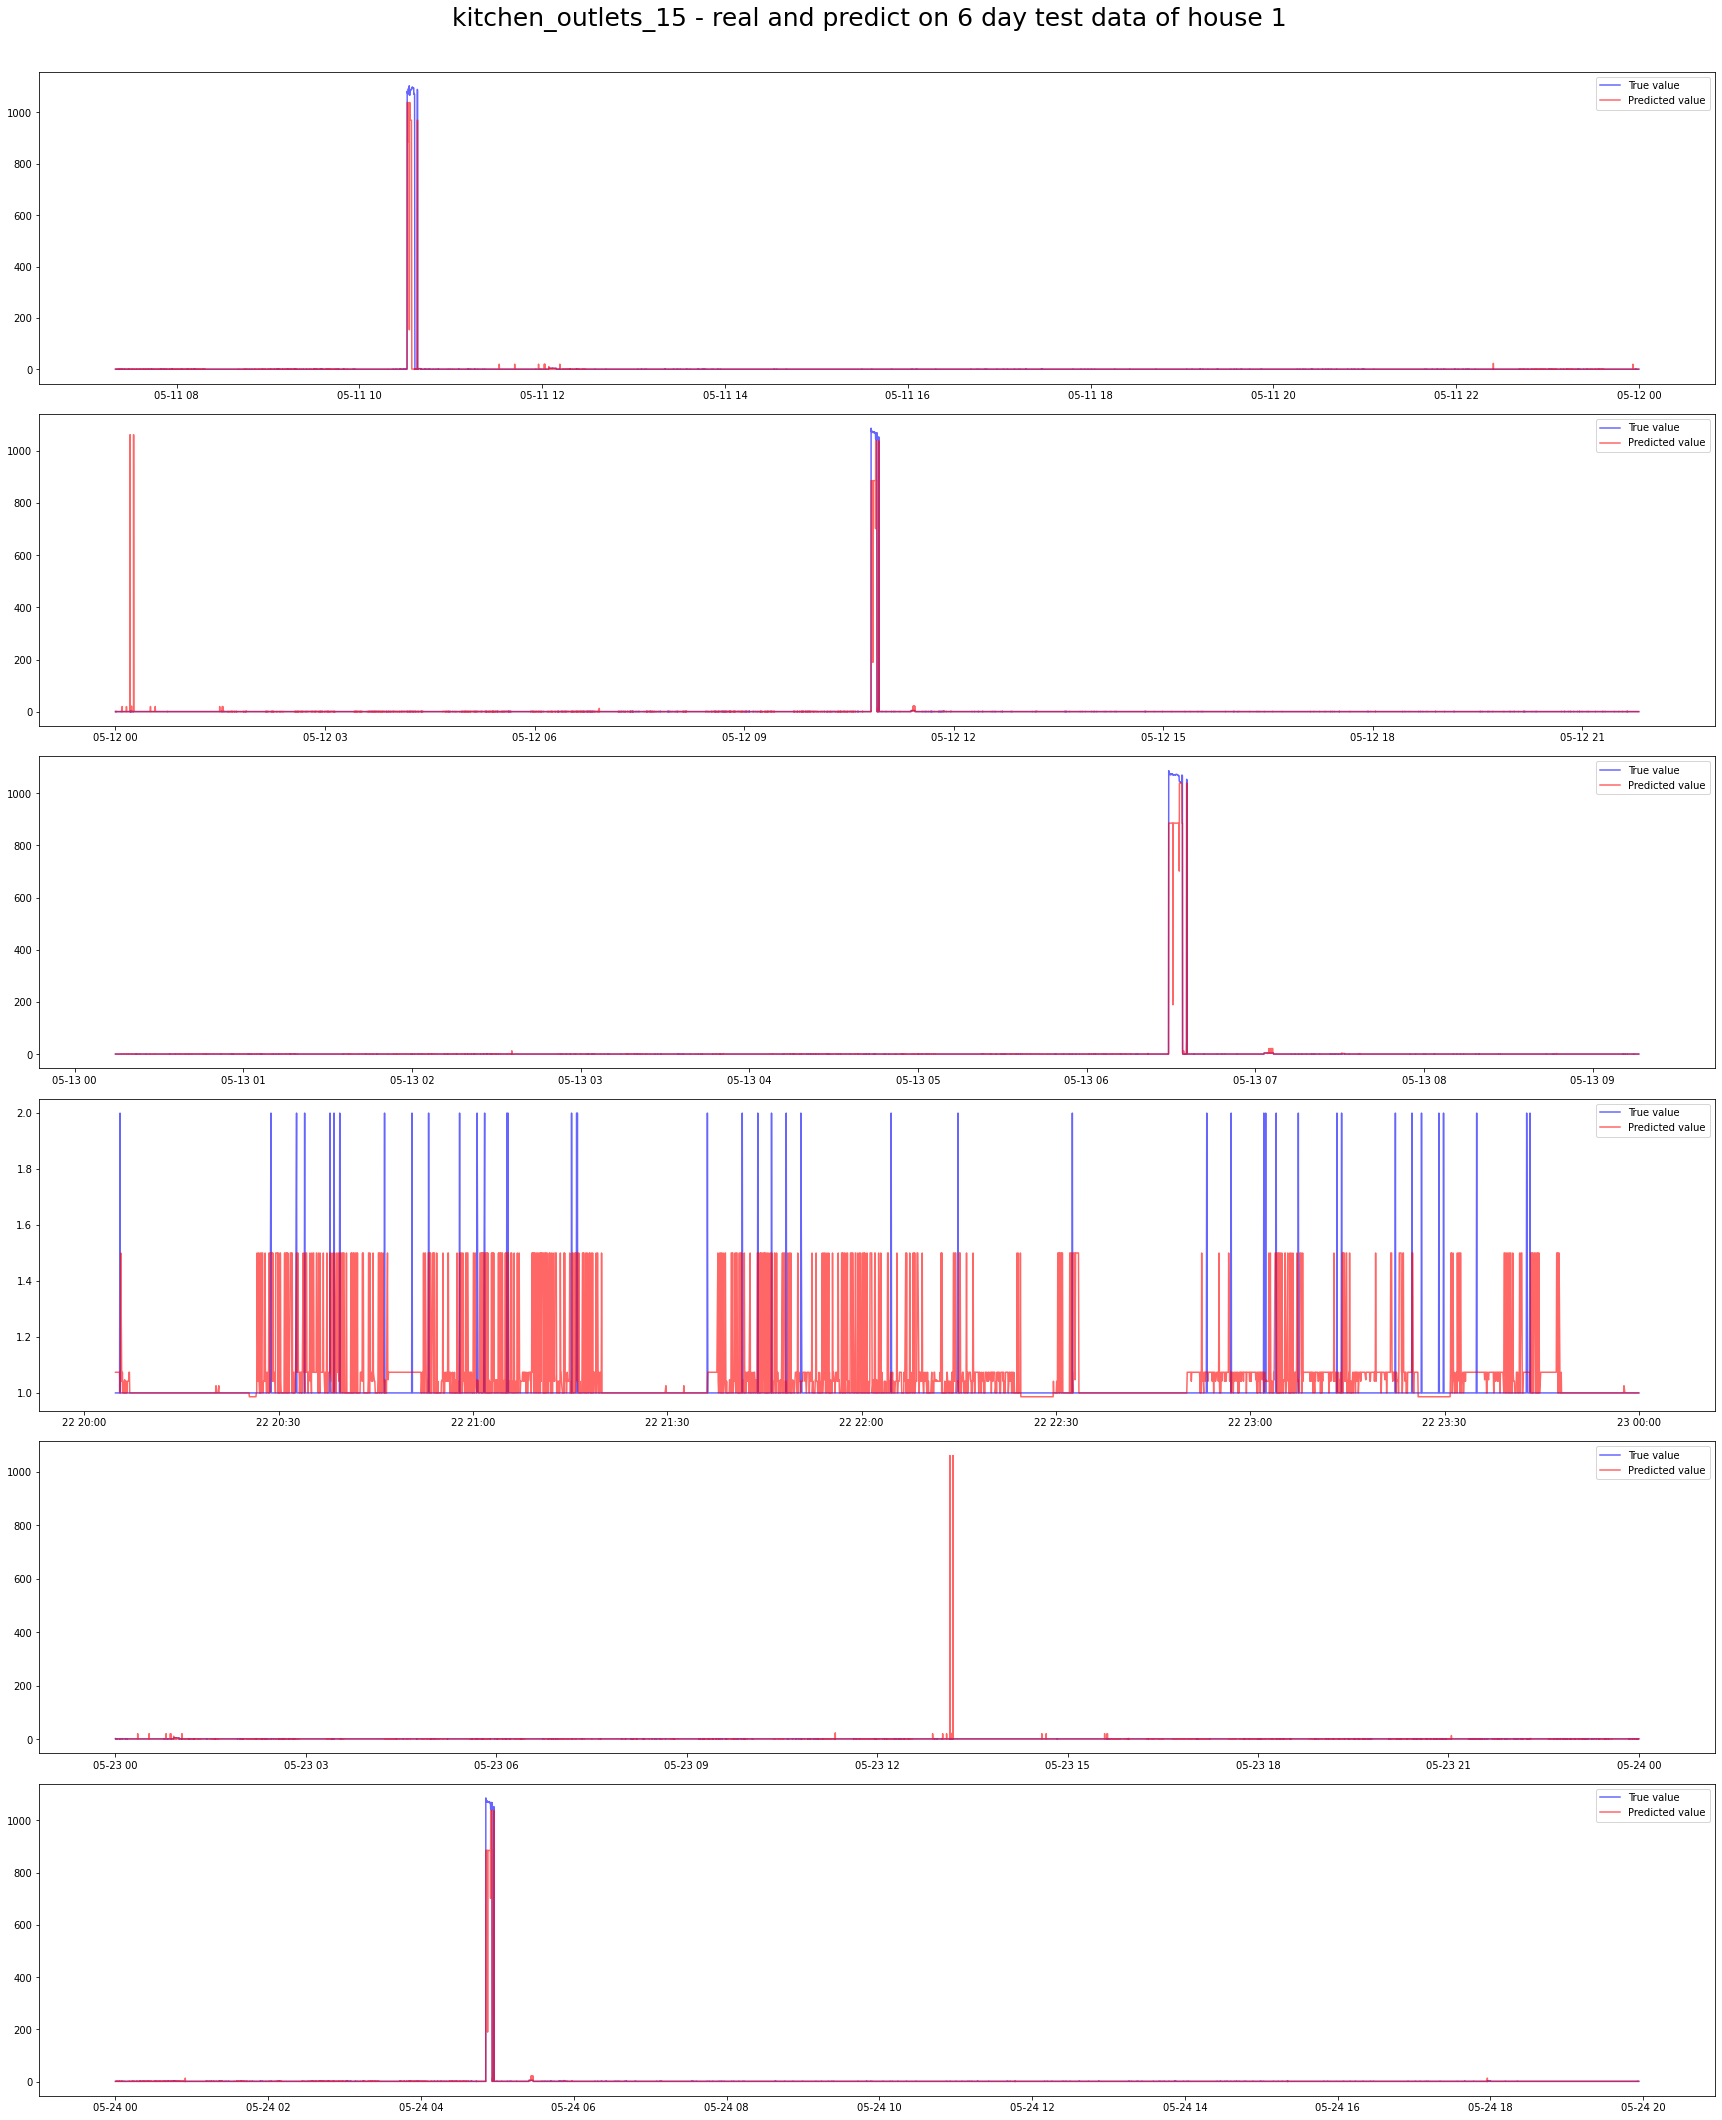

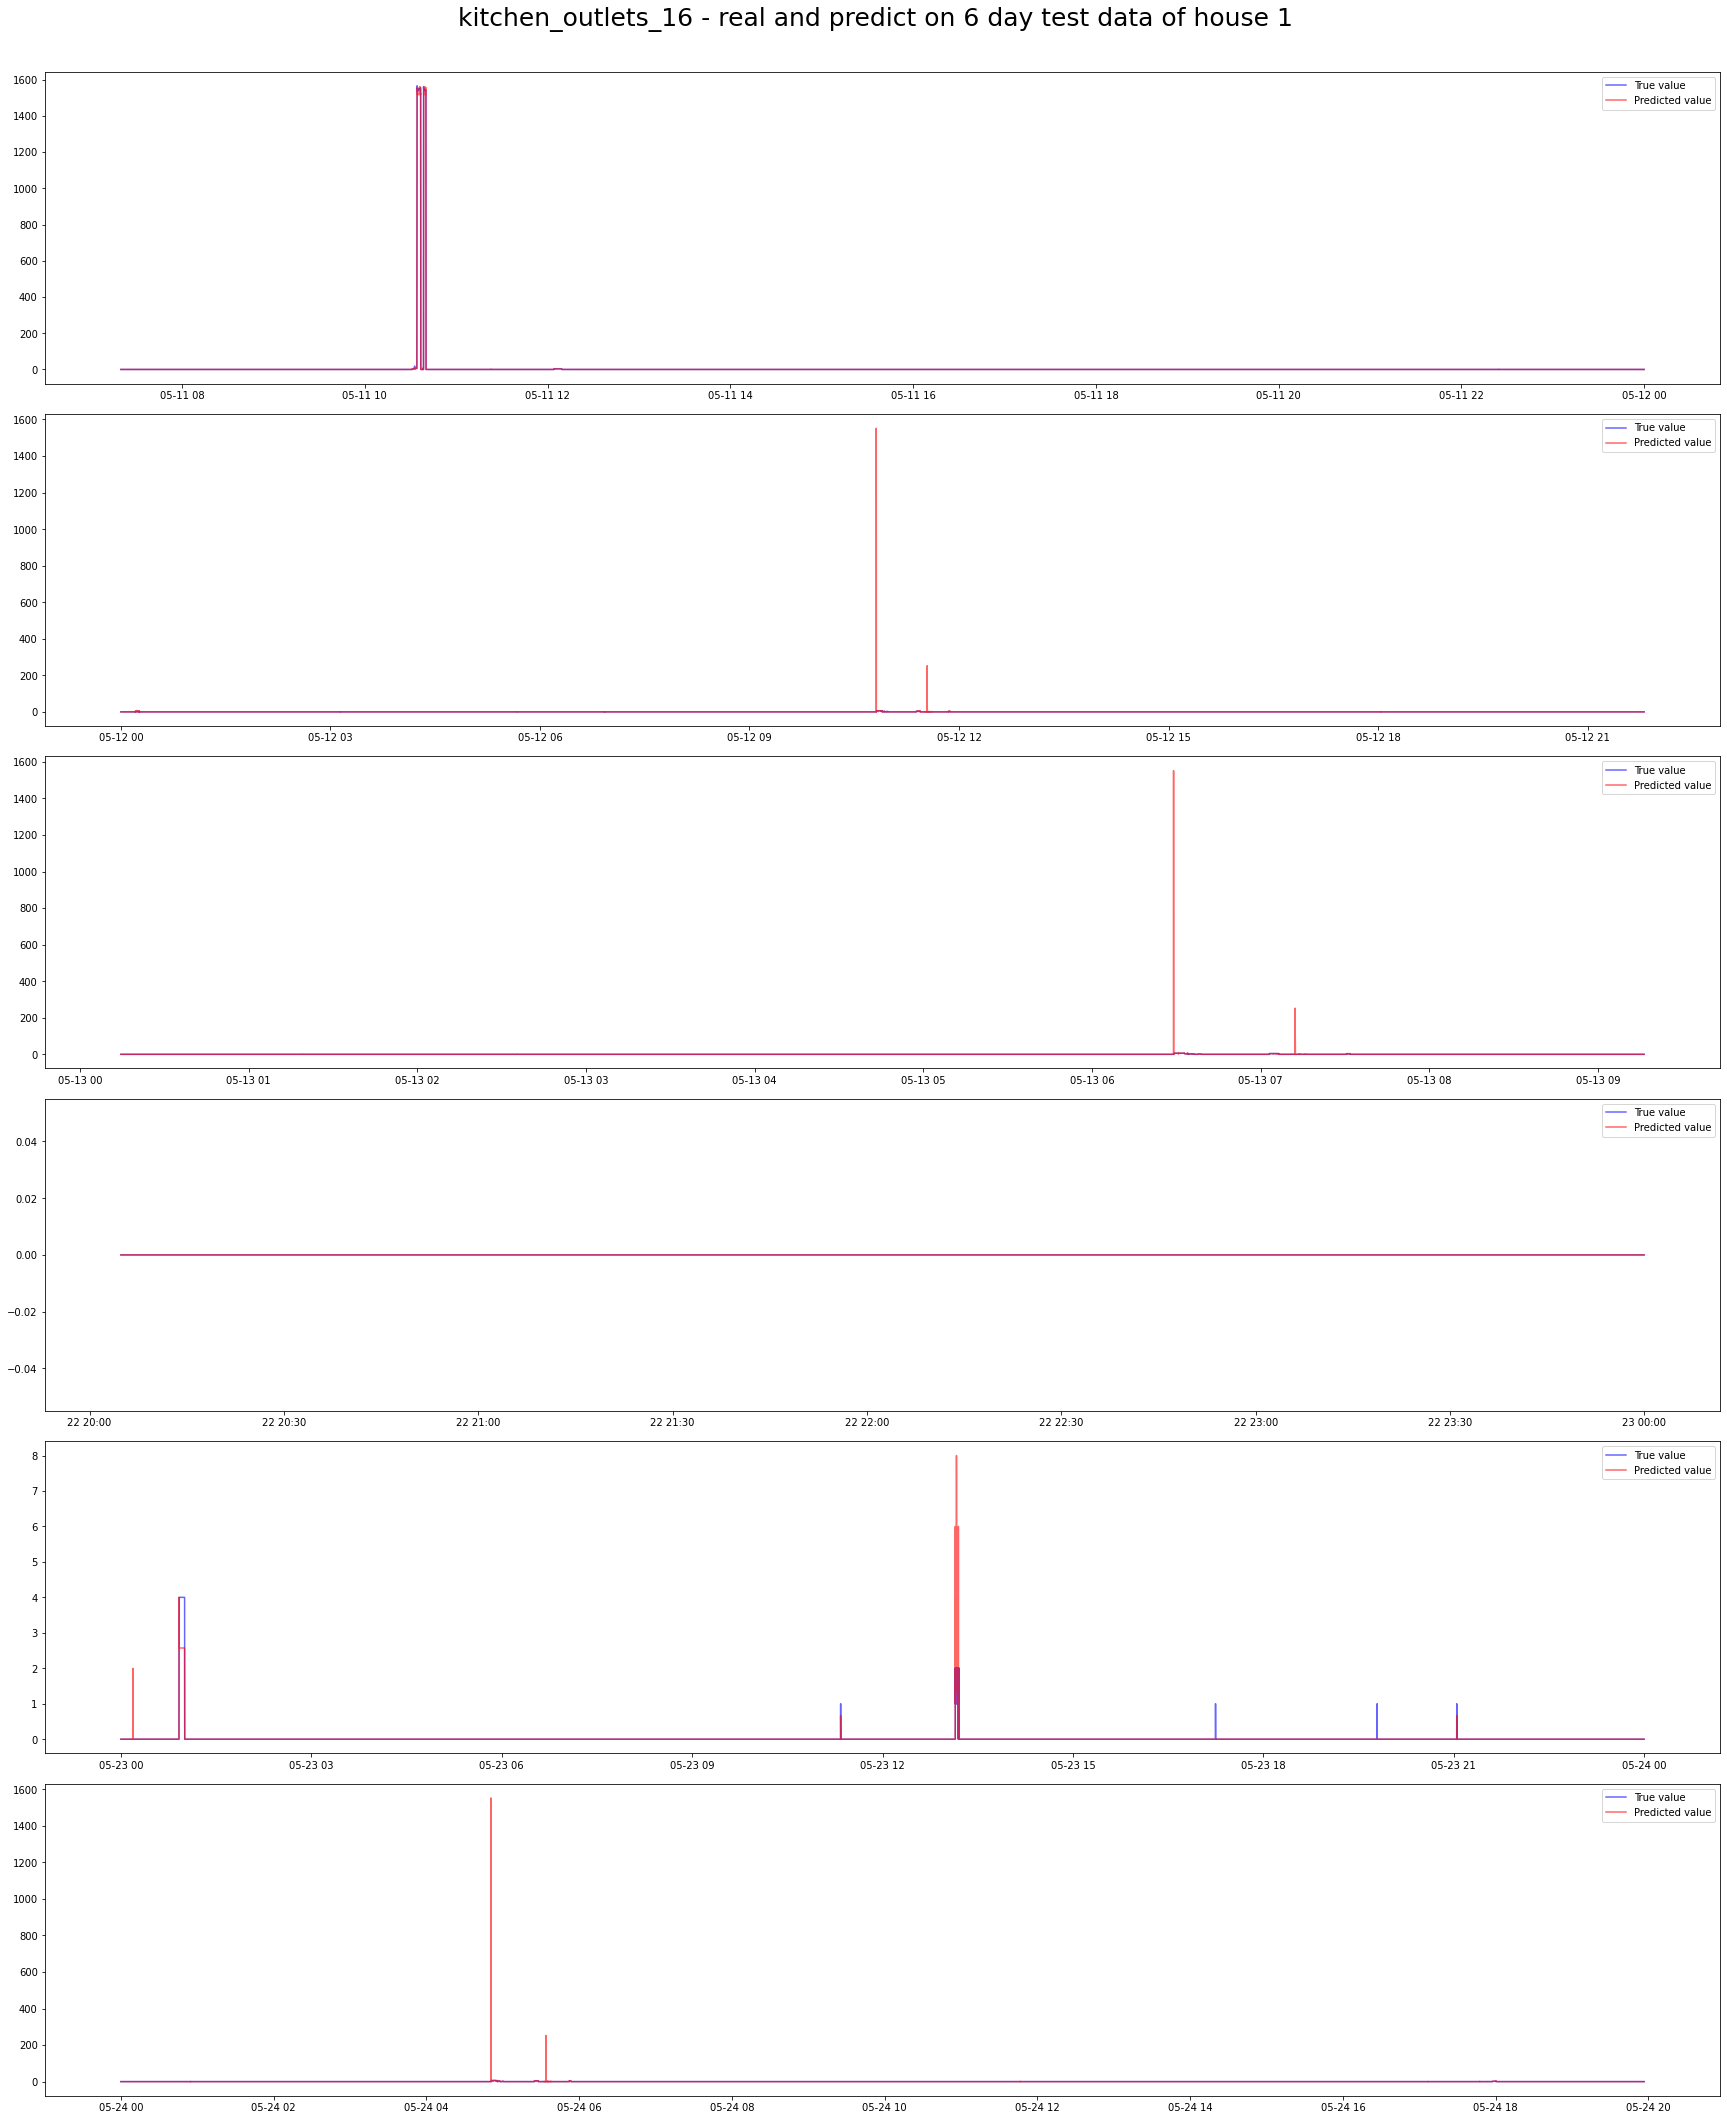

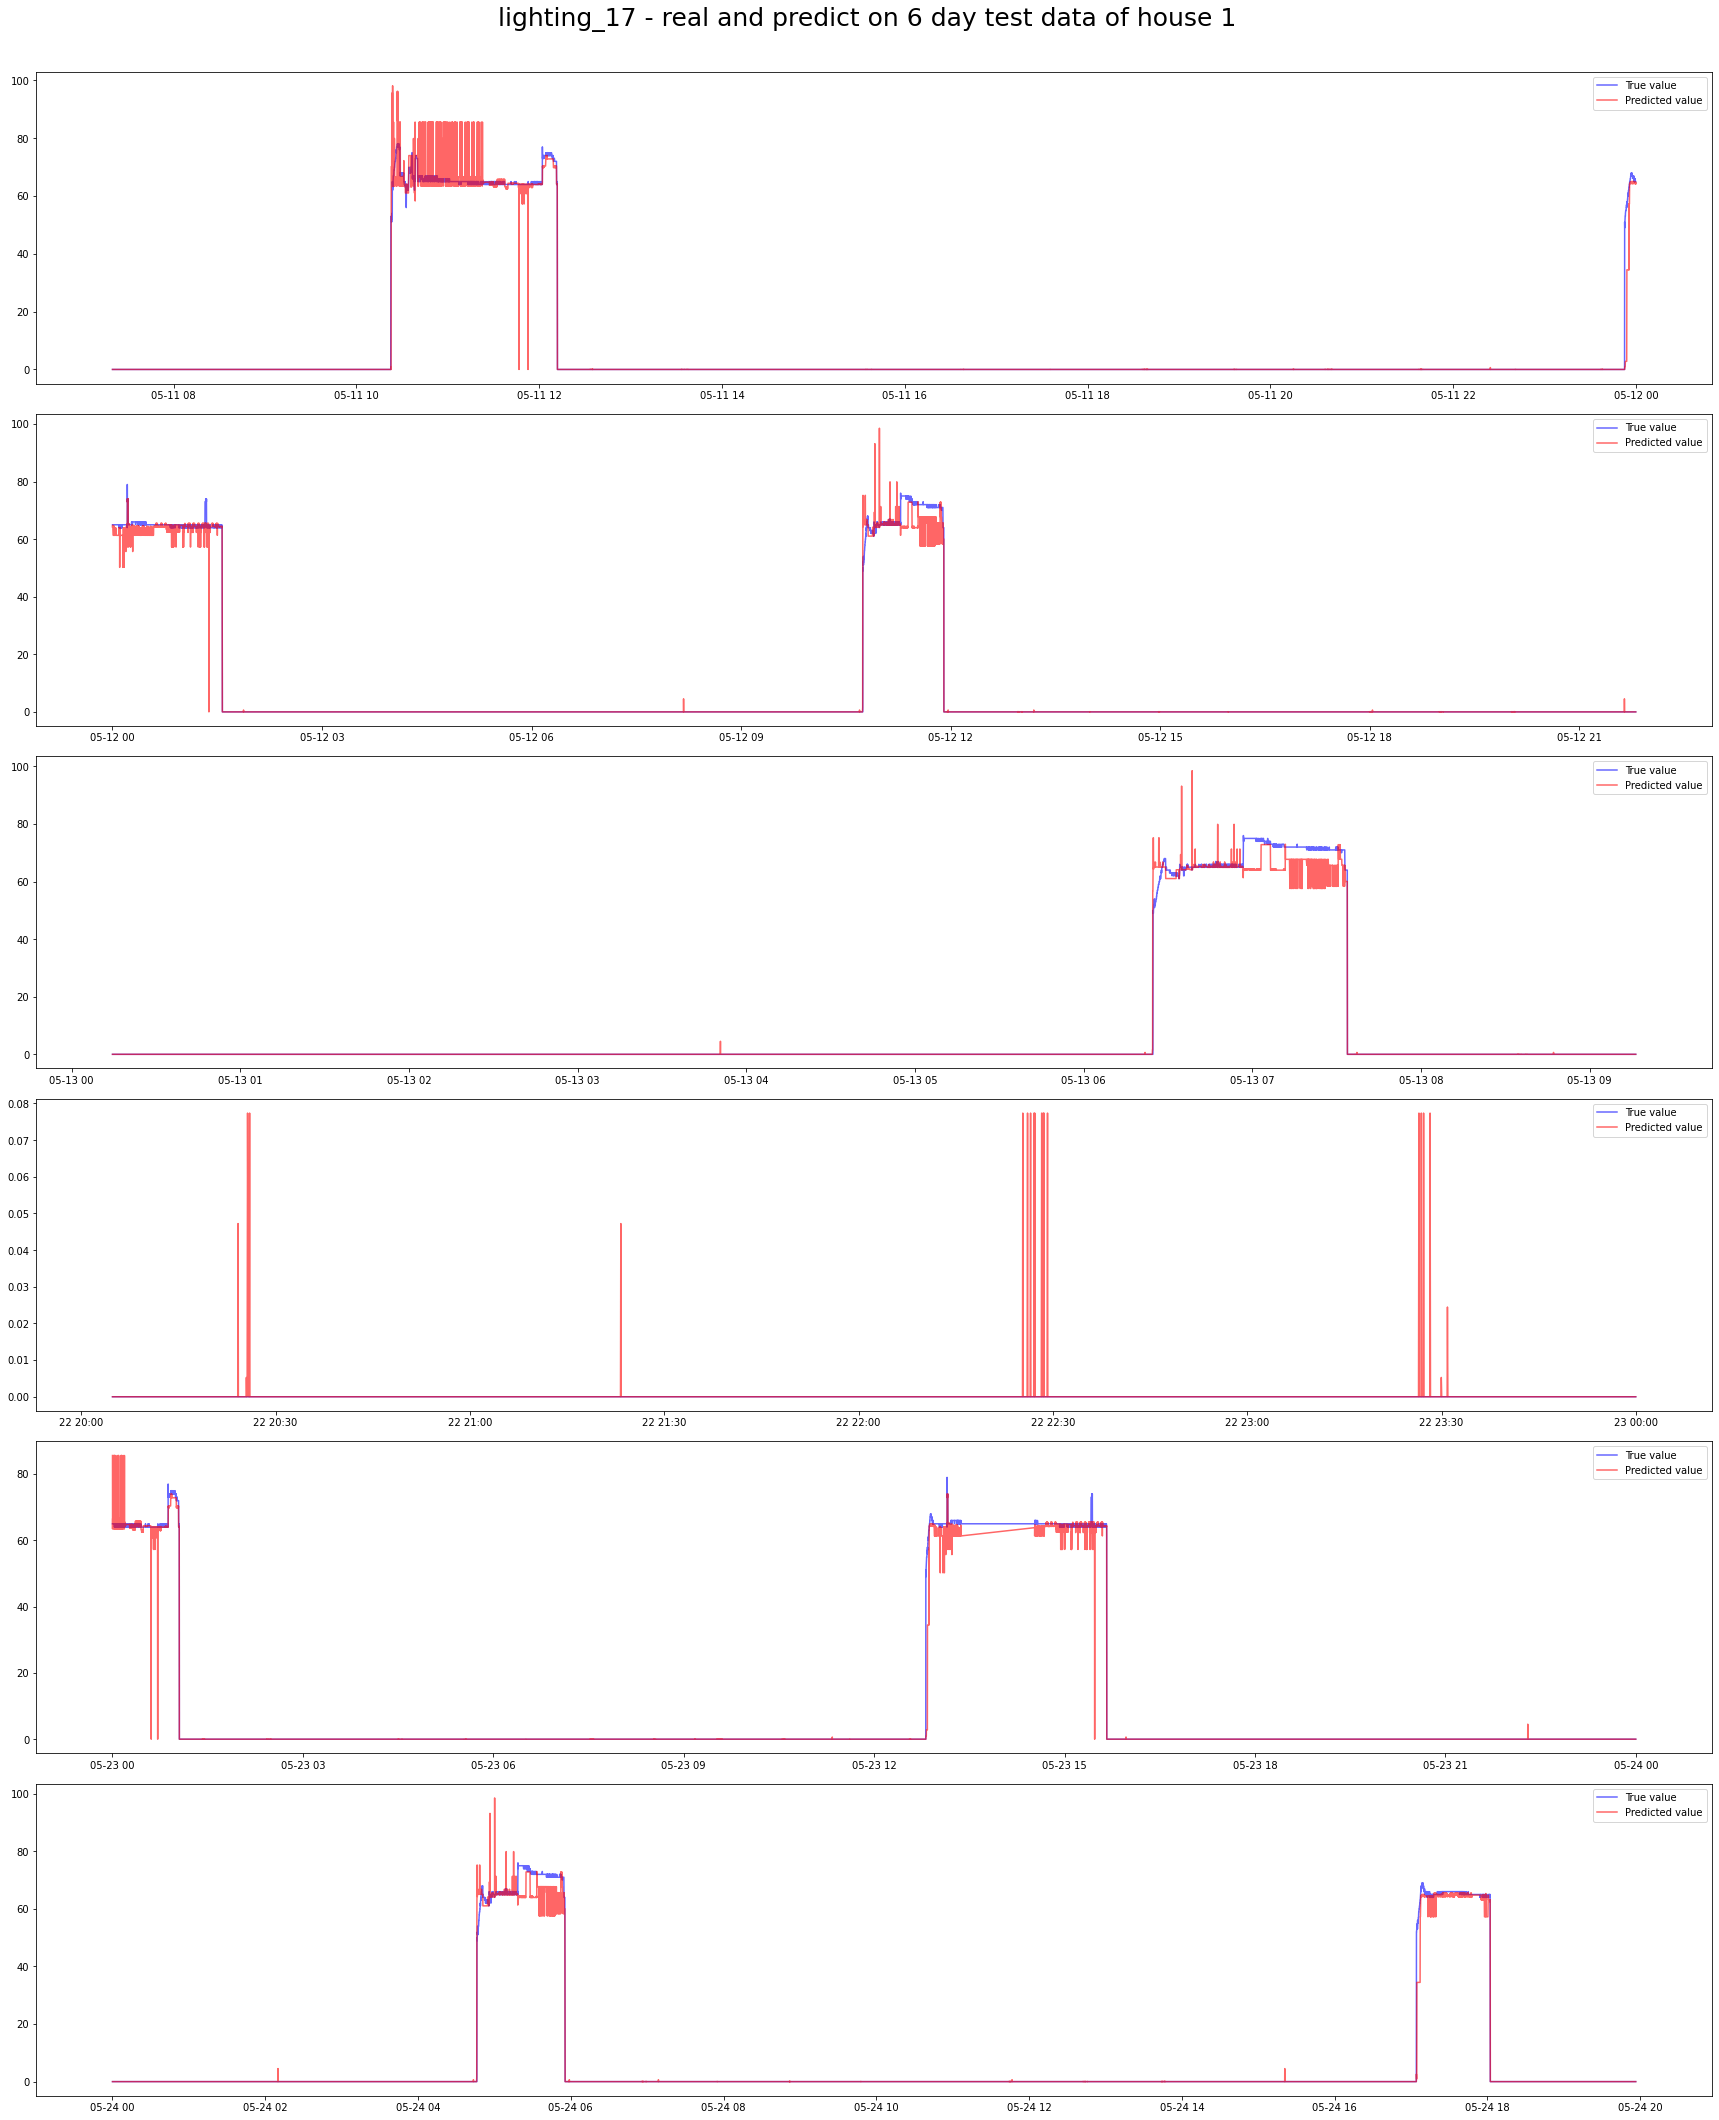

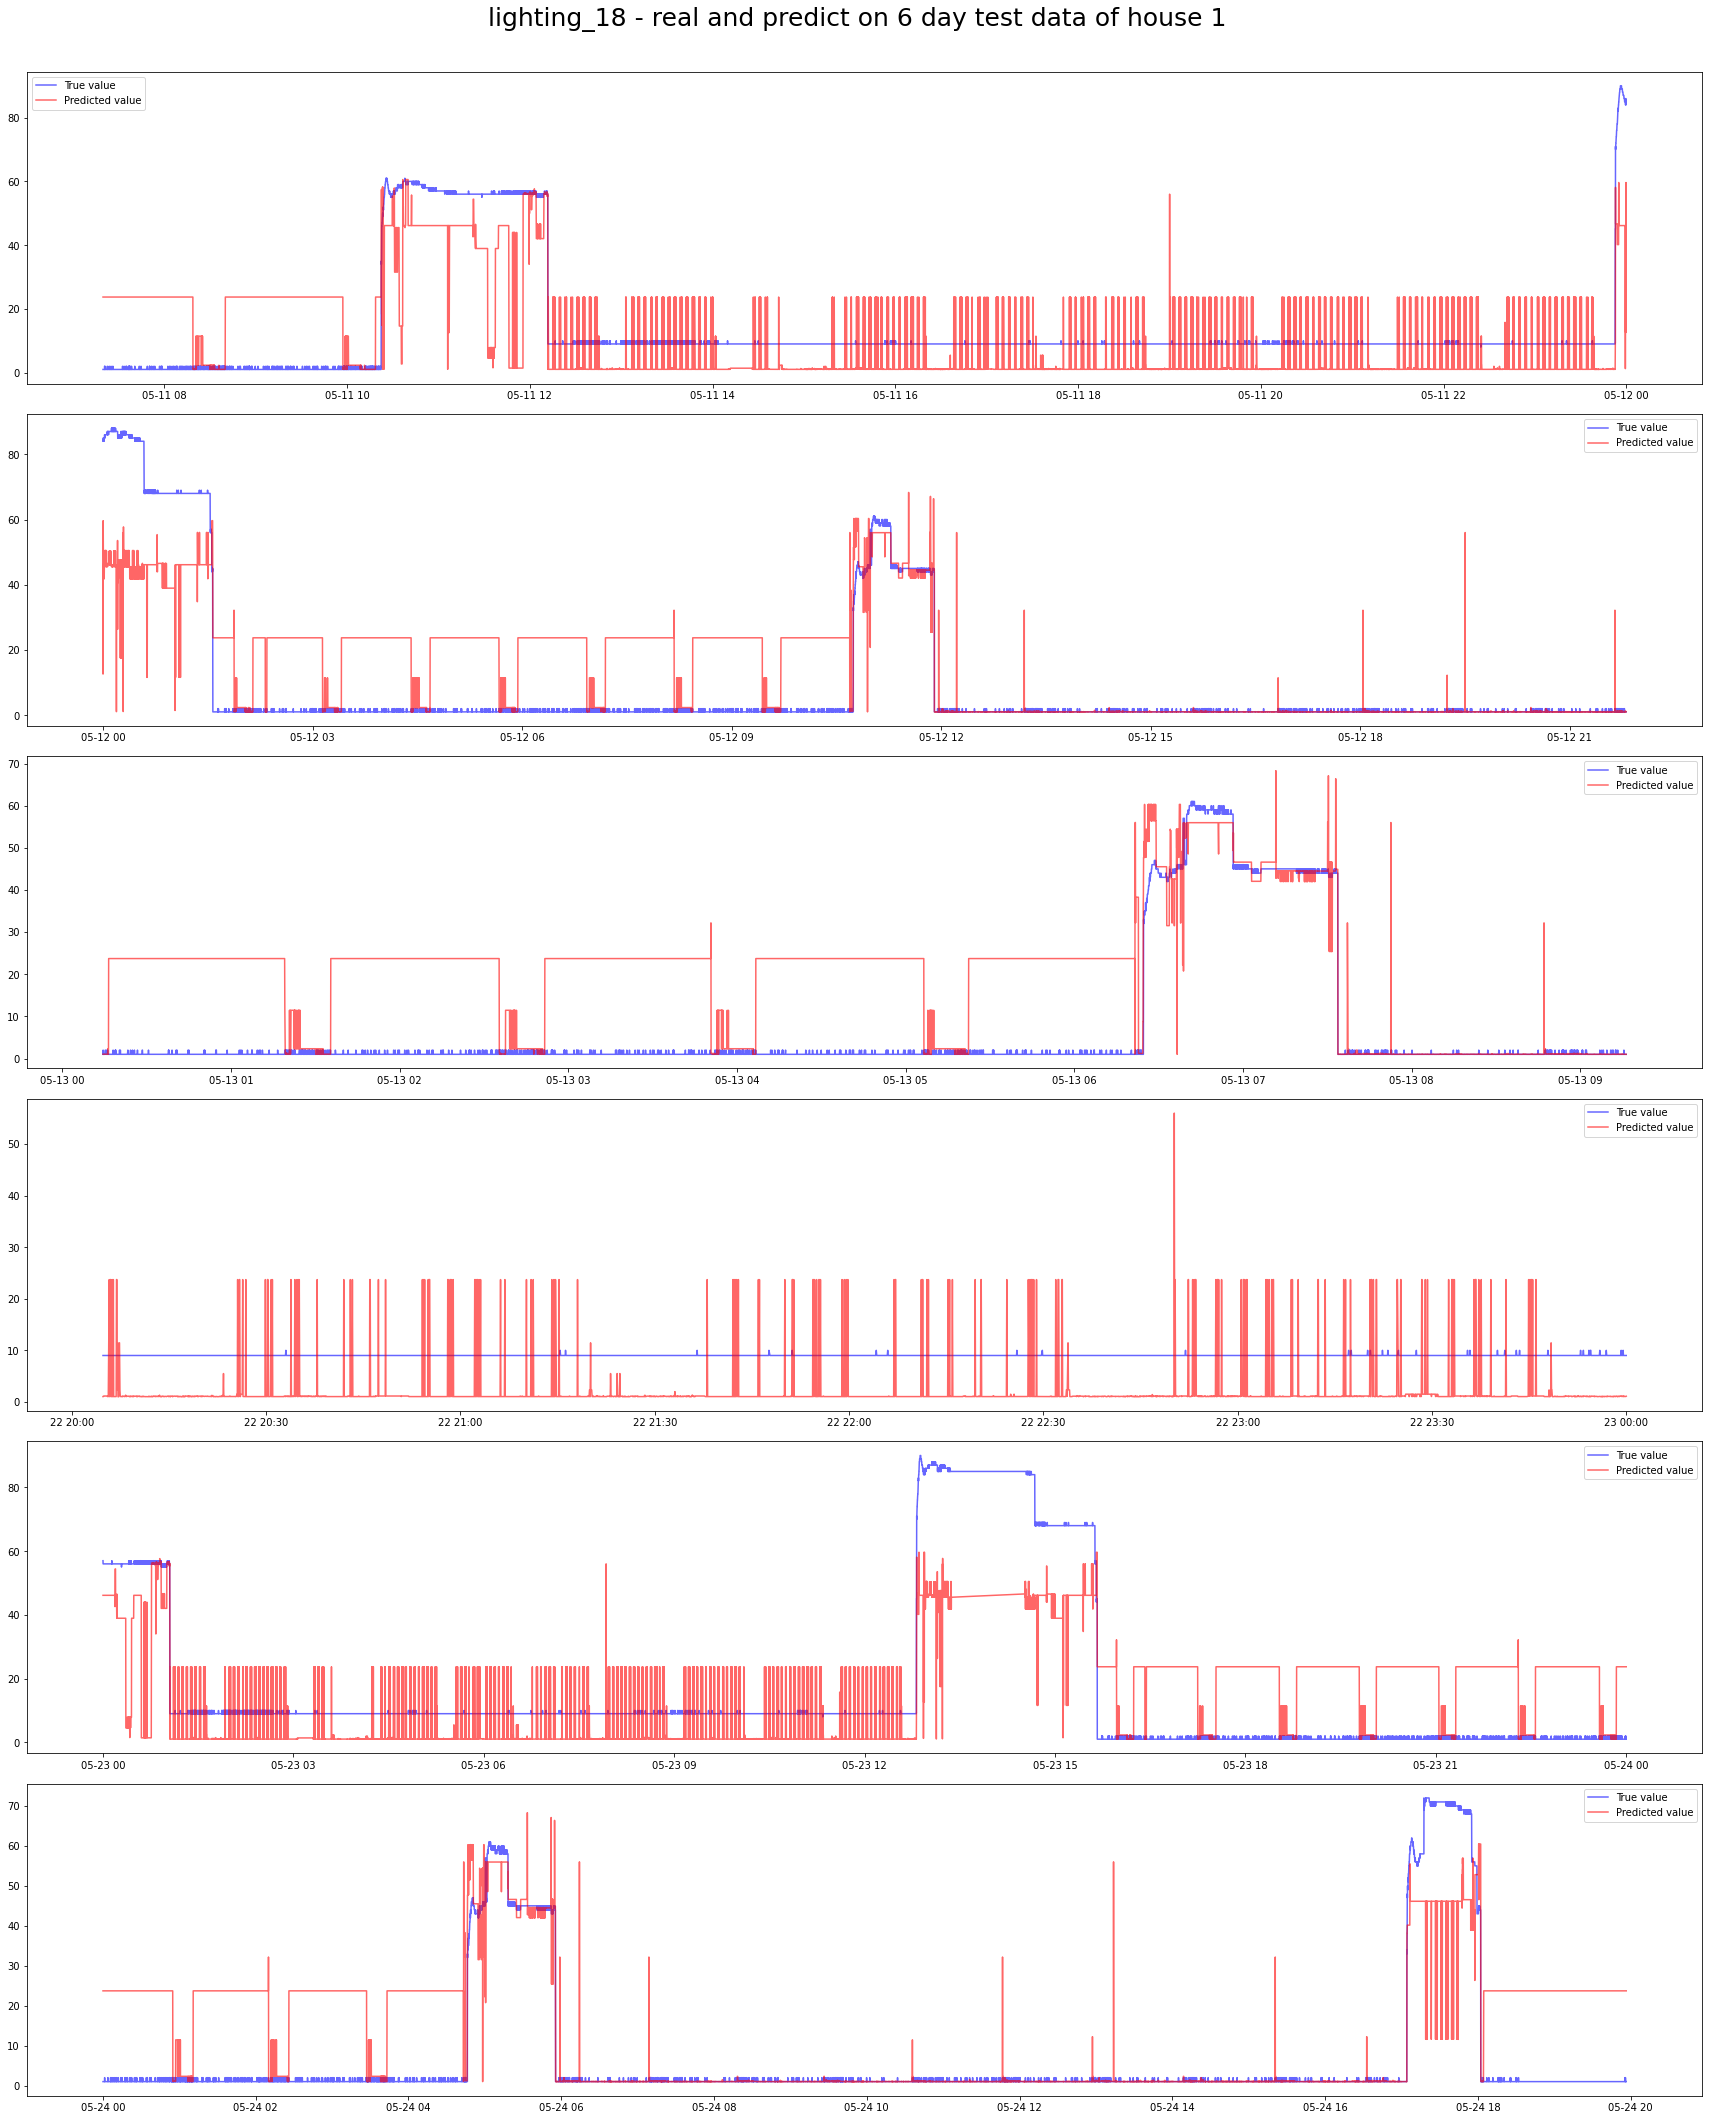

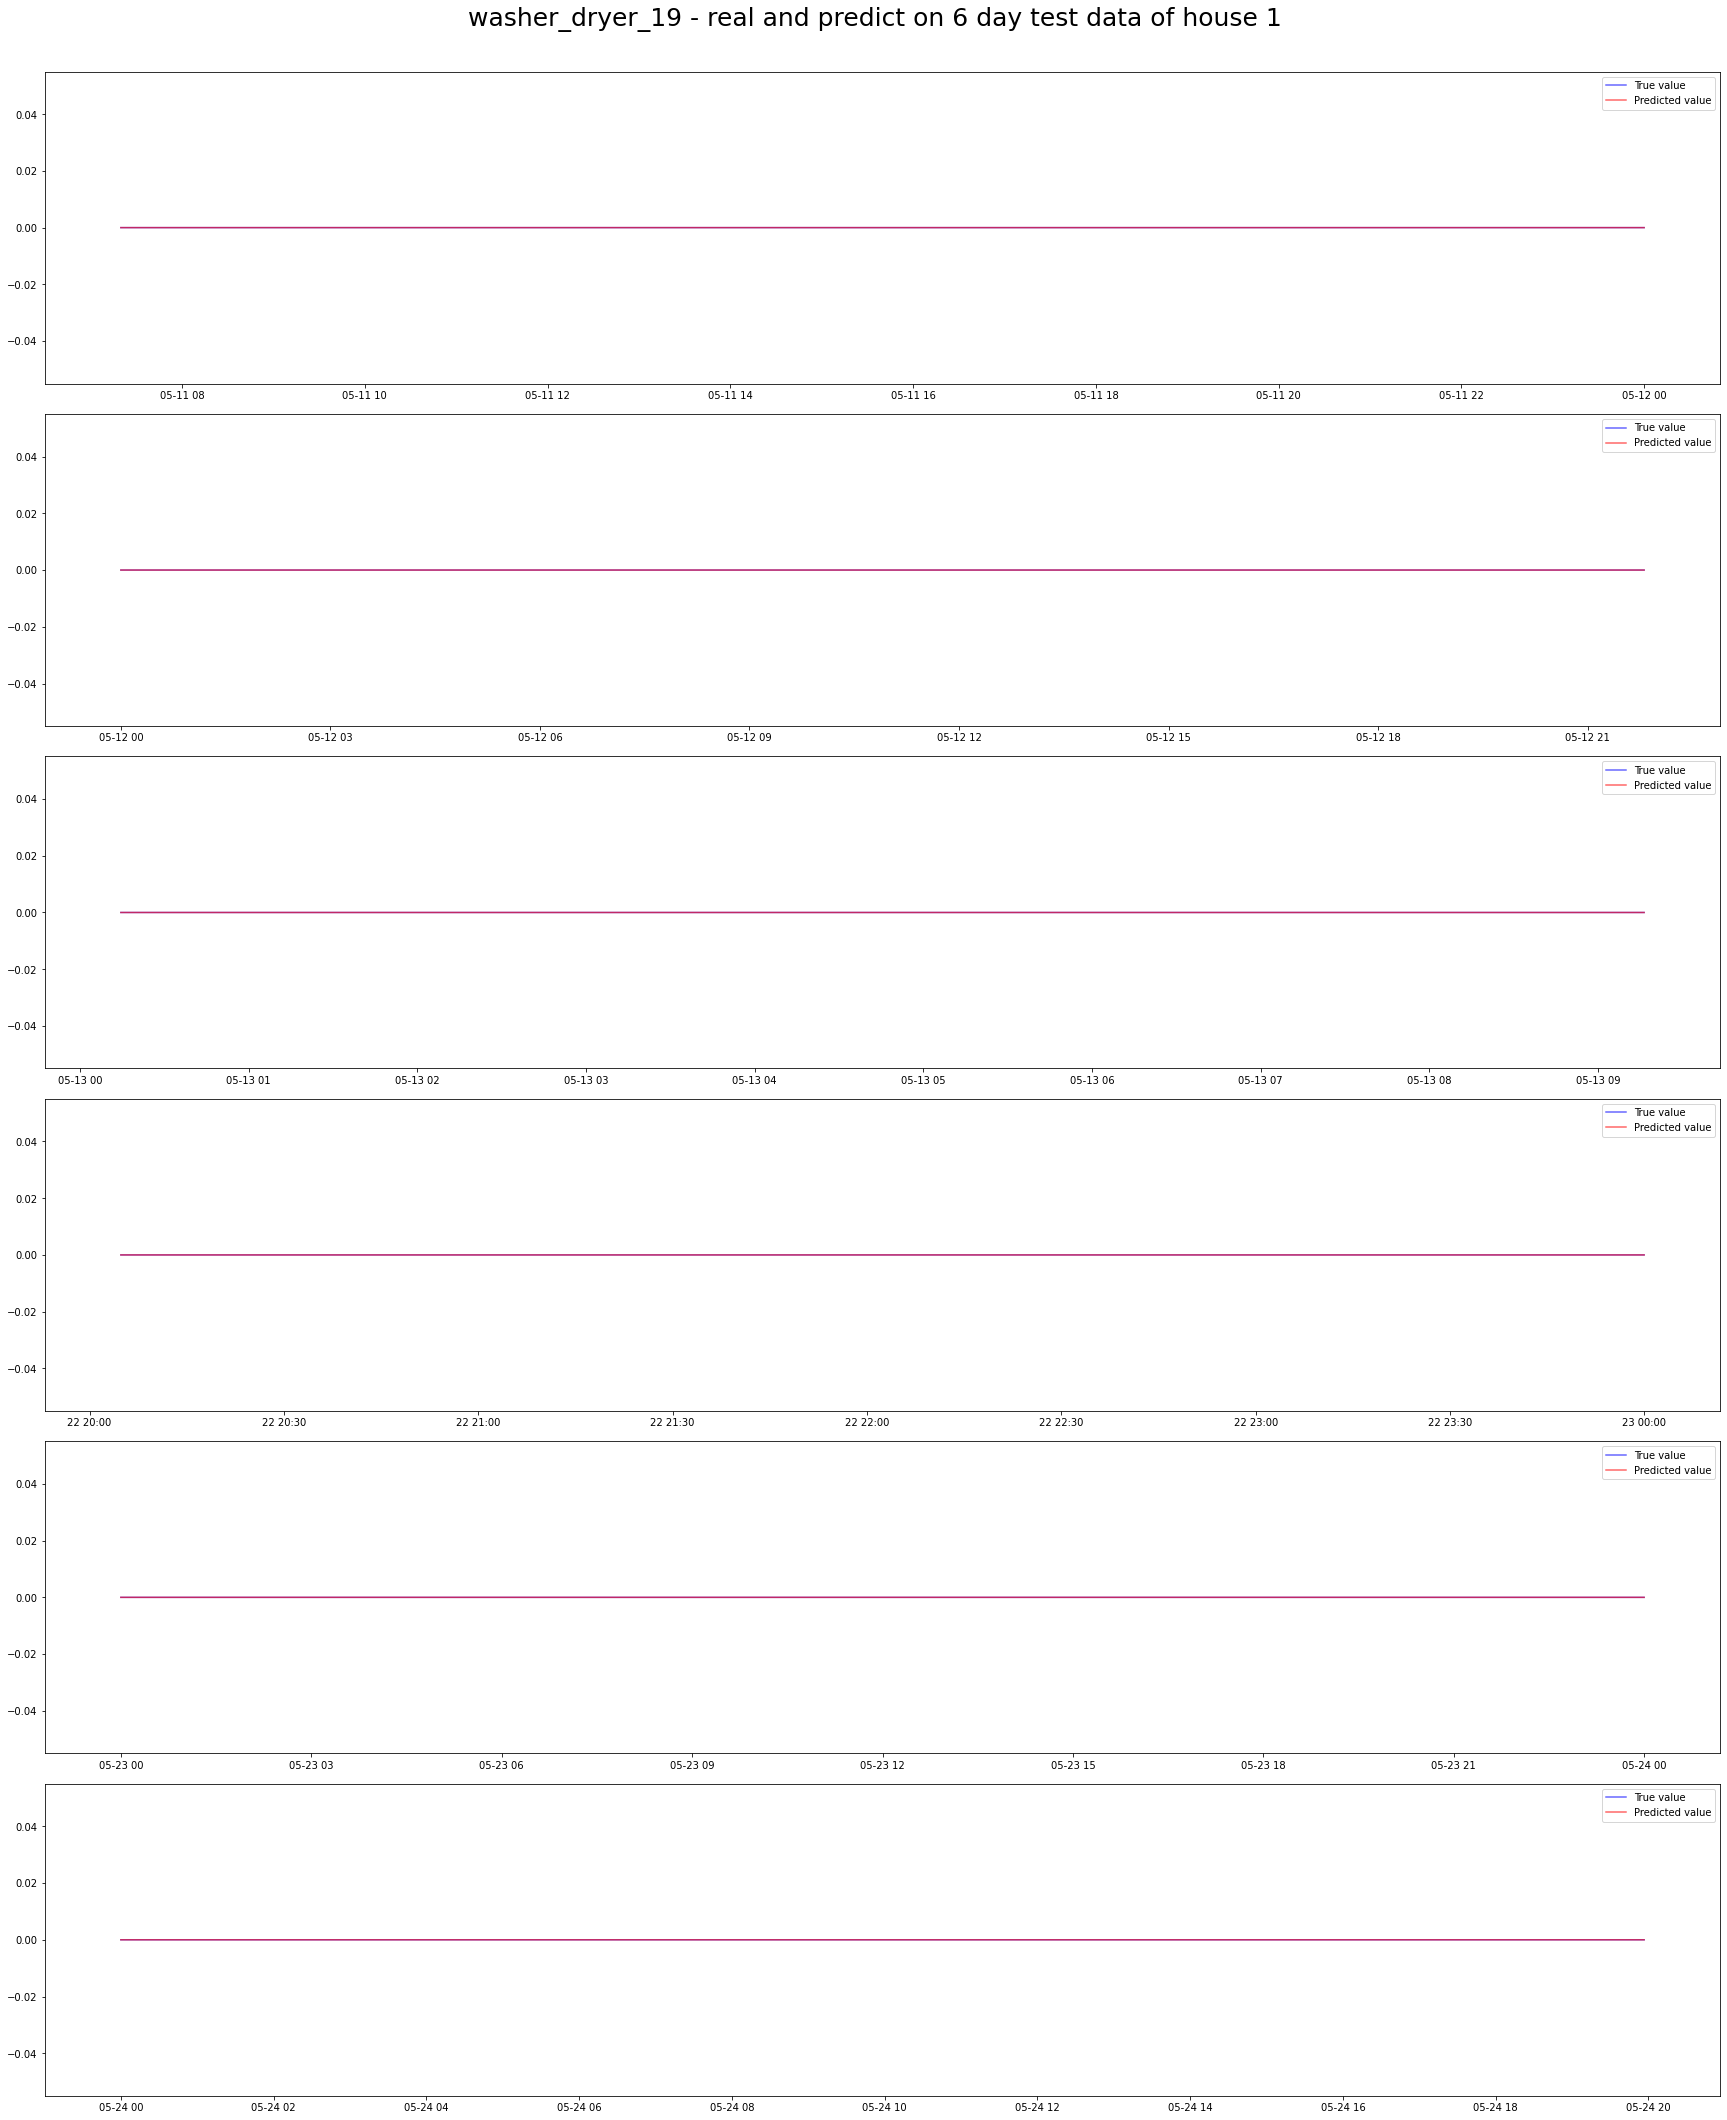

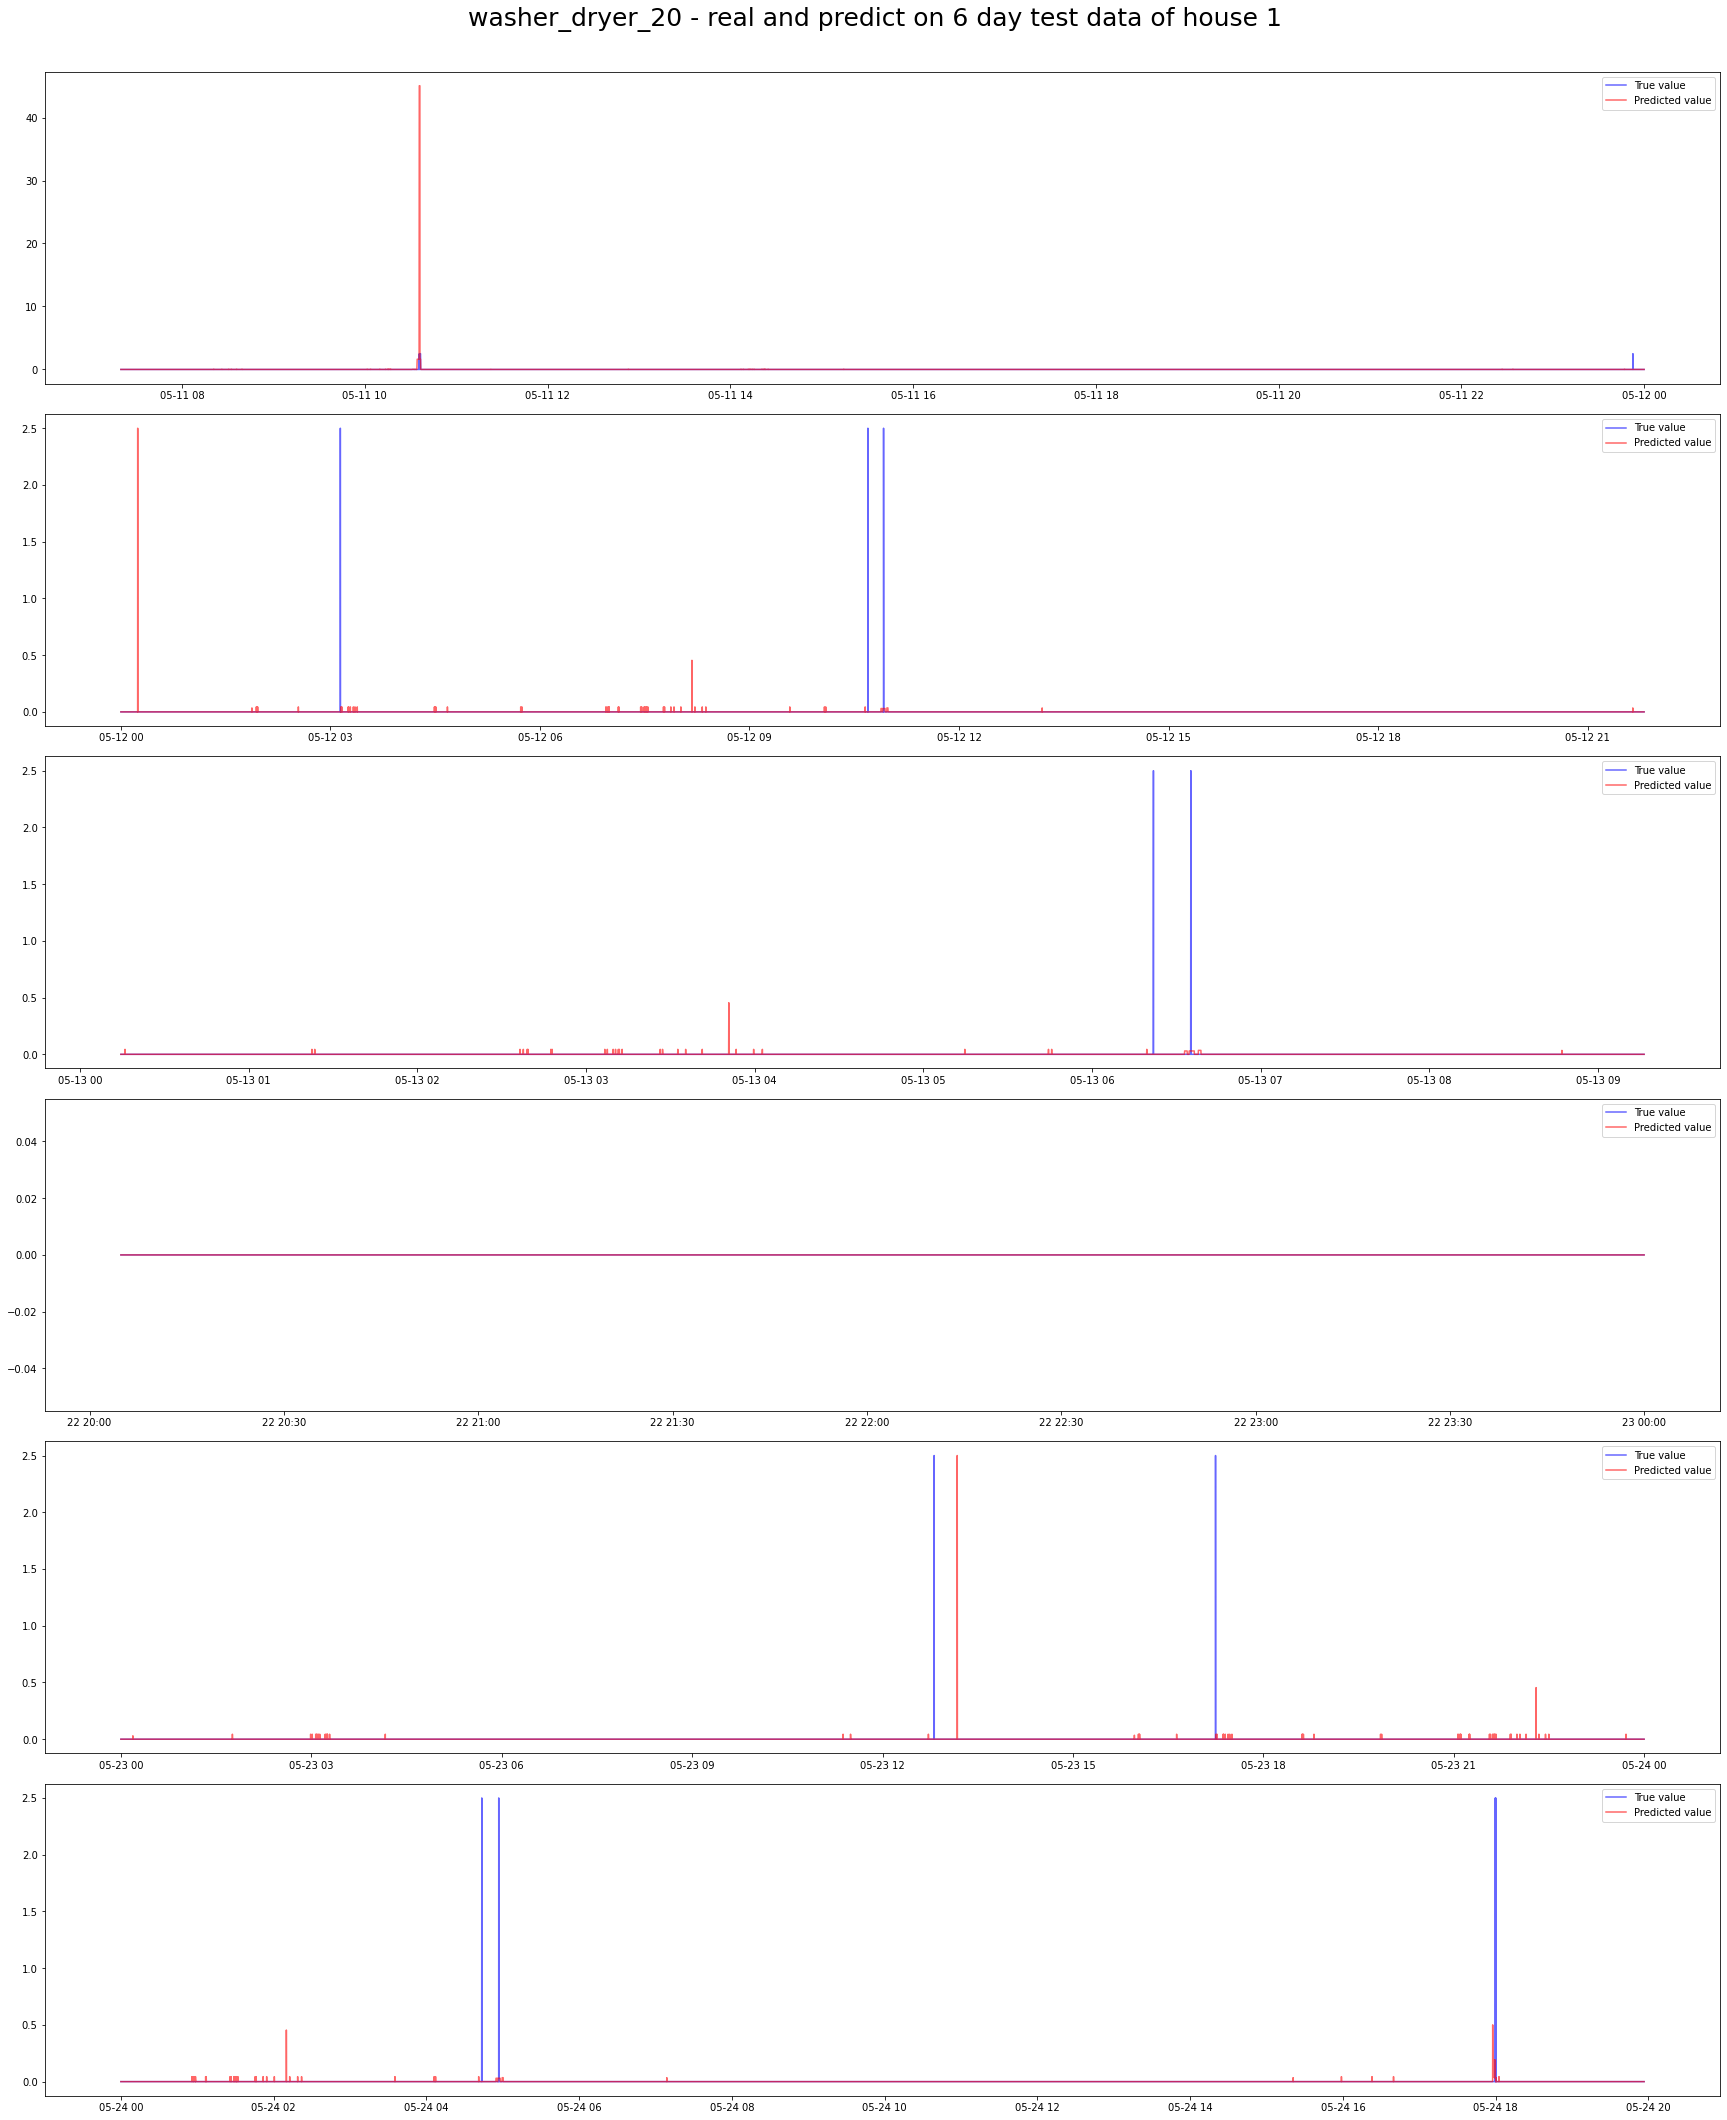

In [ ]:
for app in appliances:
    plot_each_app(df1_test, dates[1][17:], mul_pred[app], df1_test[app].values, 
                  '{} - real and predict on 6 day test data of house 1'.format(app))

歸納觀察到的幾個現象：
1.少用的電器預測效果差  
2.不知道確切負載電器是什麼的插座預測效果差  
3.使用習慣上很隨機的（如電燈）預測效果差  
4.用House 1的model來預測House 2的結果明顯很差  
因為用的是DTR，這個結果可以想像，因為DTR辦法看到整體用電scenario。這也代表其實DTR不適合拿來分析NILM，因為NILM存在的本質是：用有限的已知資料訊連出model，然後很好的disaggregate在不同環境下同種類電器的用電數據。

基於：  
1.用電數據是一種time series的資料，且   
2.觀察用電數據的變化來disaggregate個別電器用電是一種決策模型  
以下我們改用深度學習網路來看看是否有比較好的disaggregate效果。

In [ ]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
#from keras.optimizer import adam_v2 --> 會出現module沒辦法呼叫的錯誤 --> 改從tensorflow import
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [ ]:
#參考https://stackoverflow.com/questions/65573913/dense-layer-typeerror-init-missing-1-required-positional-argument-units
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(layers[i+1], input_shape=(layers[i],)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               768       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              5

In [ ]:
adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=512, verbose=1, epochs=100,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/100
282/282 [==============================] - 5s 10ms/step - loss: 12625.2969 - val_loss: 9771.0371
Epoch 2/100
282/282 [==============================] - 2s 8ms/step - loss: 11938.0742 - val_loss: 9503.2451
Epoch 3/100
282/282 [==============================] - 2s 8ms/step - loss: 11600.4717 - val_loss: 9526.8730
Epoch 4/100
282/282 [==============================] - 2s 9ms/step - loss: 11404.9453 - val_loss: 9623.2715
Epoch 5/100
282/282 [==============================] - 3s 9ms/step - loss: 11307.5293 - val_loss: 9701.8506
Epoch 6/100
282/282 [==============================] - 2s 8ms/step - loss: 10961.4961 - val_loss: 9607.5977
Epoch 7/100
282/282 [==============================] - 2s 8ms/step - loss: 10754.1592 - val_loss: 9645.4668
Epoch 8/100
282/282 [==============================] - 3s 9ms/step - loss: 10677.1475 - val_loss: 9619.9189
Epoch 9/100
282/282 [==============================] - 3s 9ms/step - loss: 10606.1807 - val_loss: 9711.9316
Epoch 10/100
282/282 [=====

In [ ]:
! cp /content/fc_refrig_h1_2.hdf5 '/content/data/MyDrive/110-1/物聯網/Final'

In [ ]:
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)

Mean square error on test set:  9942.230886125395
Mean absolute error on the test set:  51.37689732901171


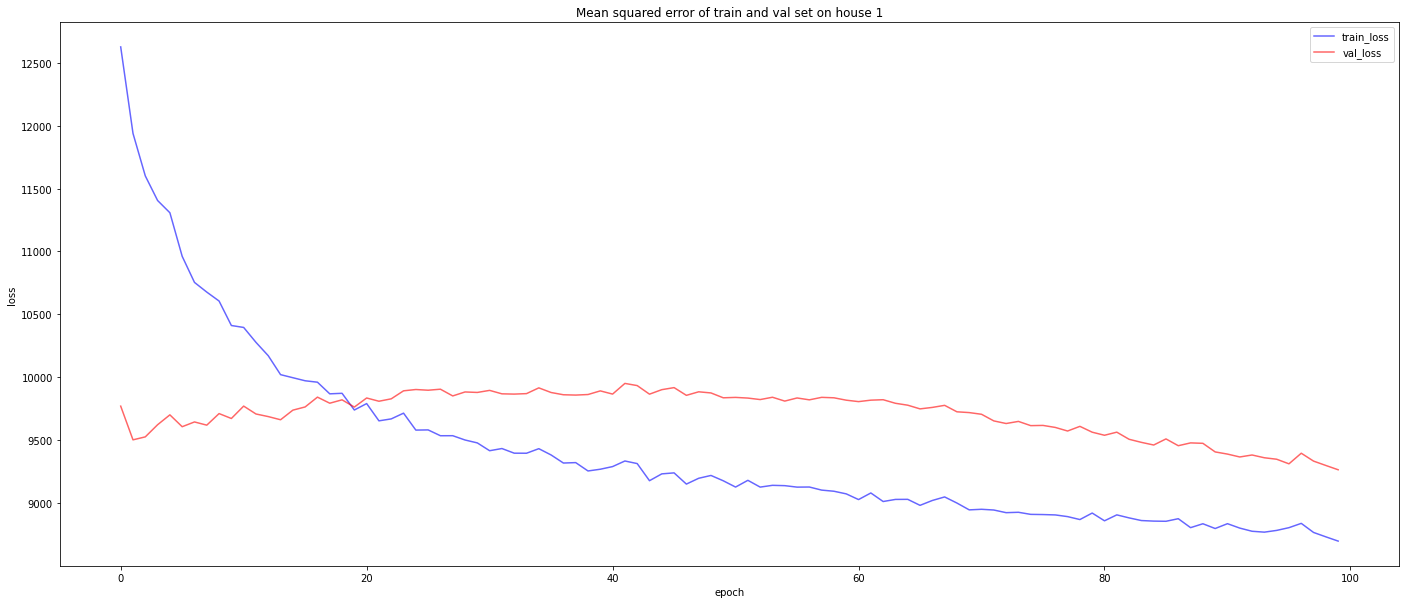

In [ ]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

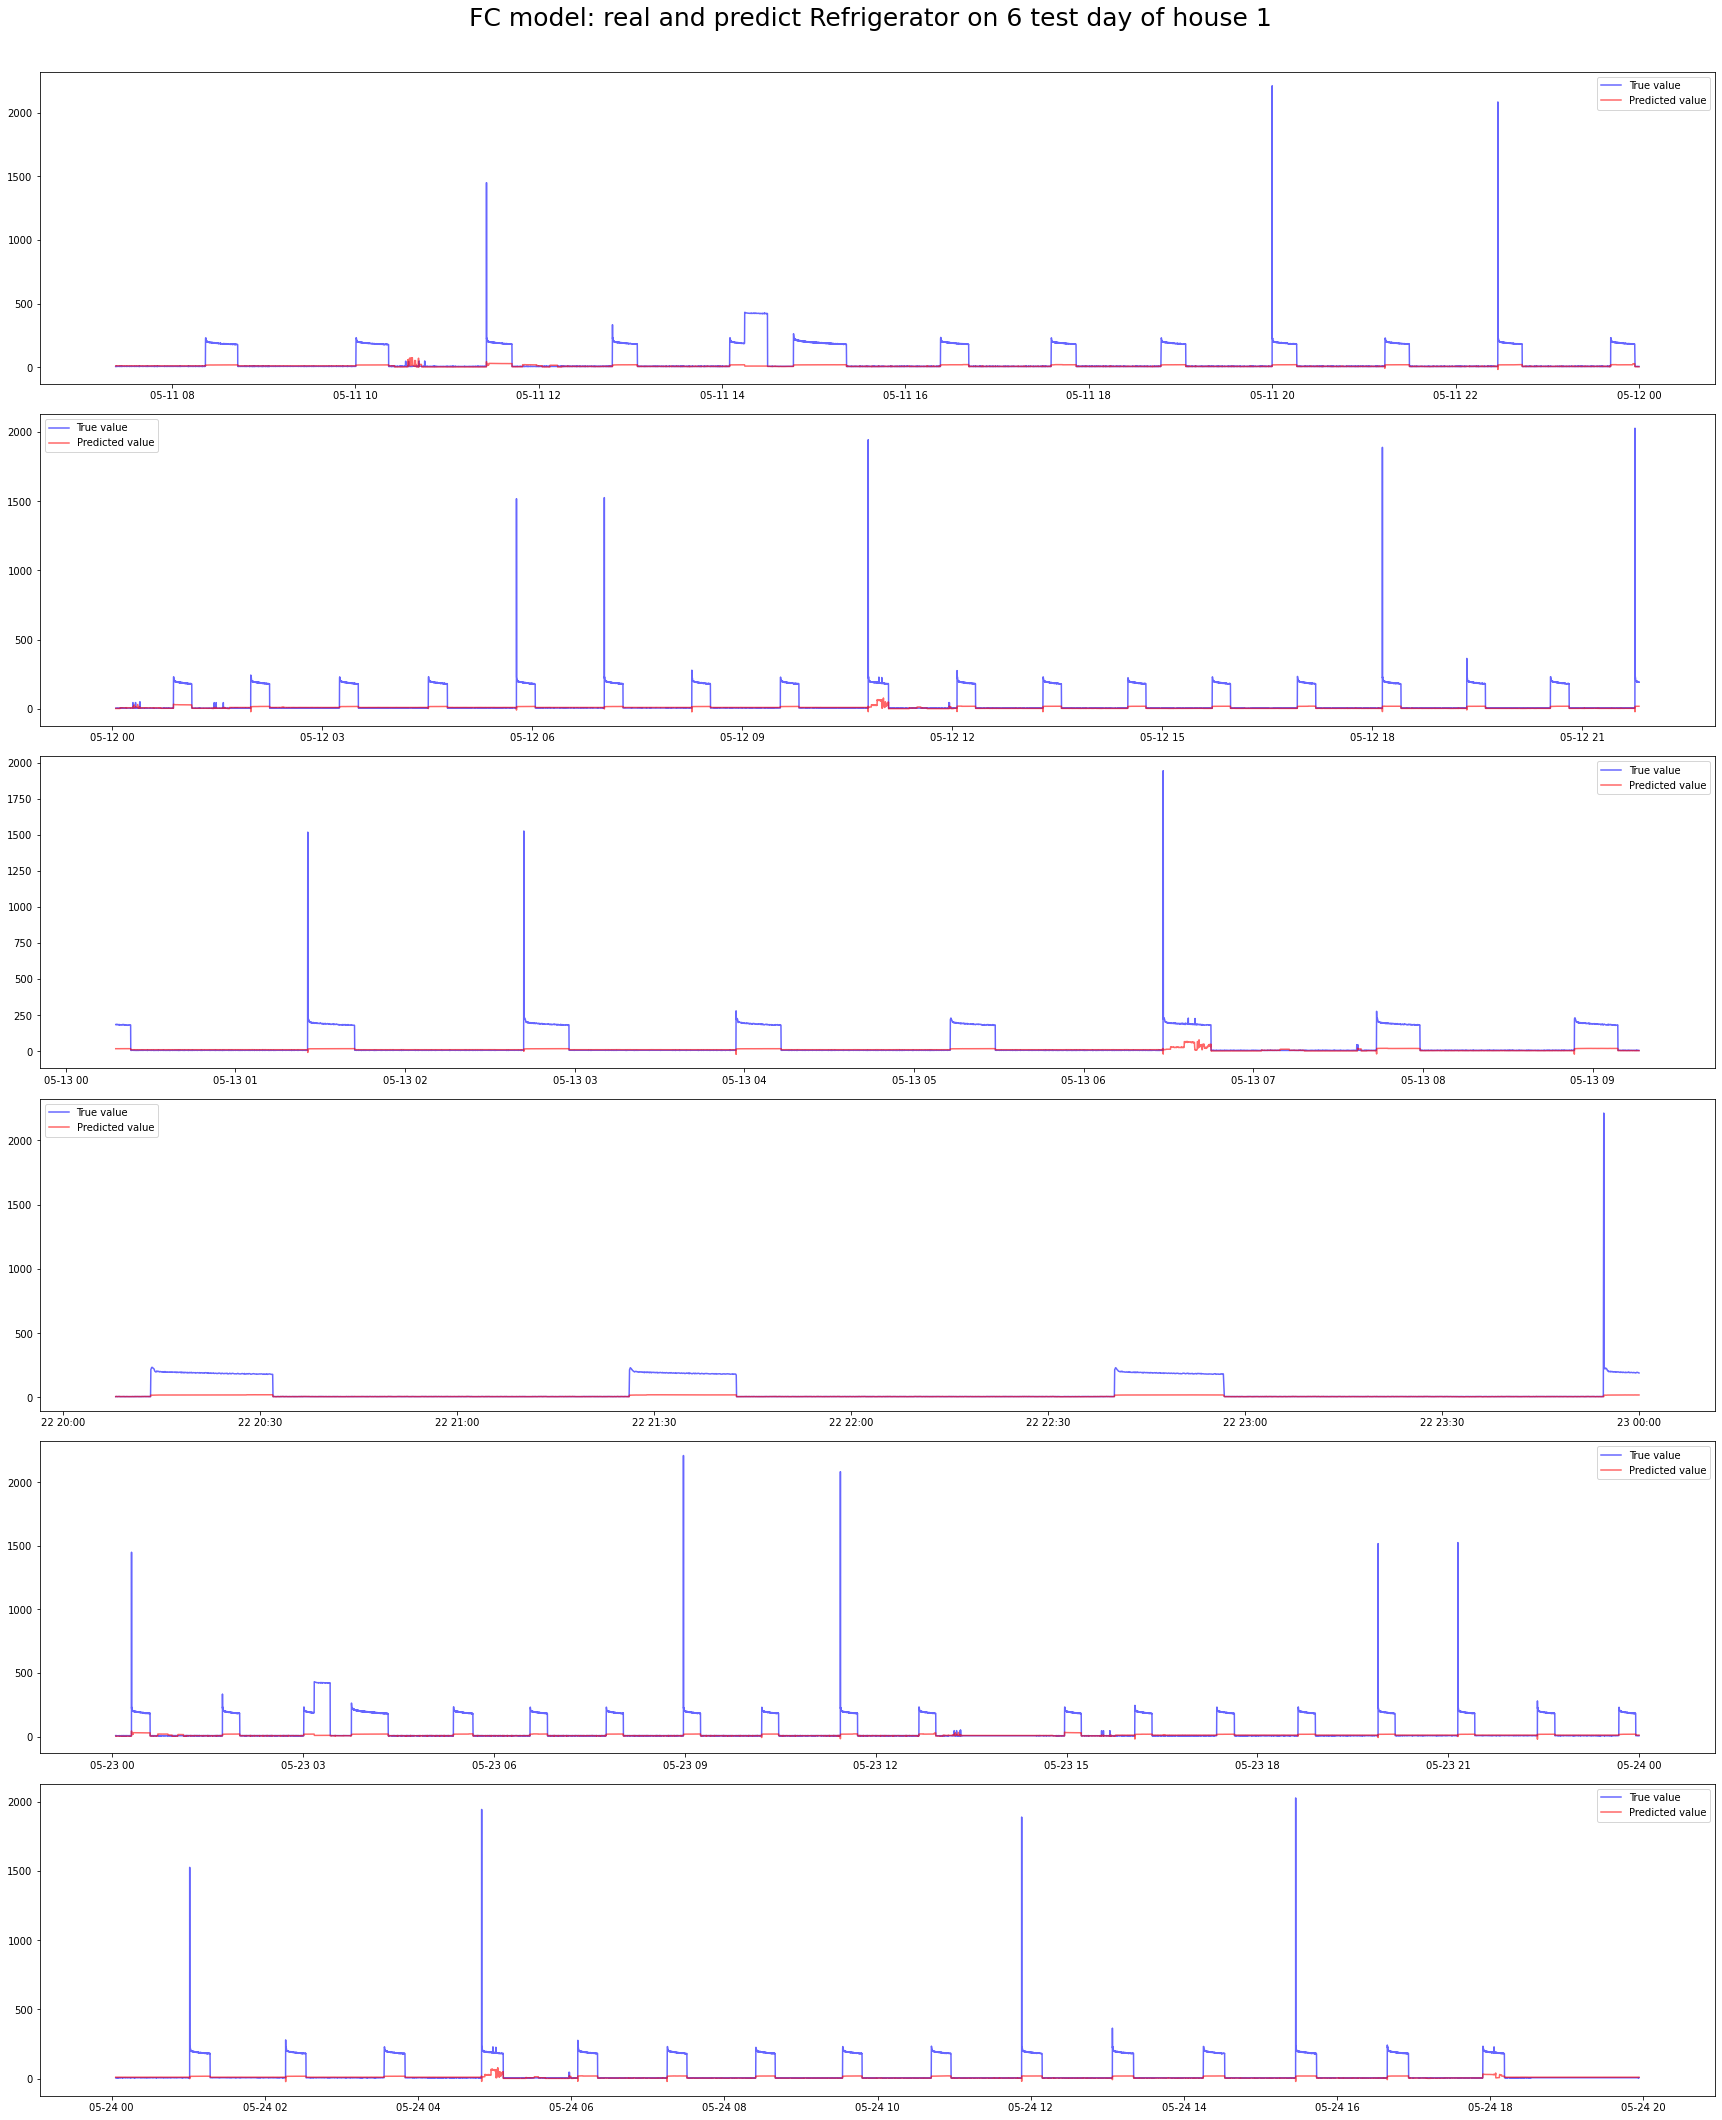

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

用House 2用電數據做測試

In [ ]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

Mean square error on test set:  13210.599897084914
Mean absolute error on the test set:  75.17200351829449


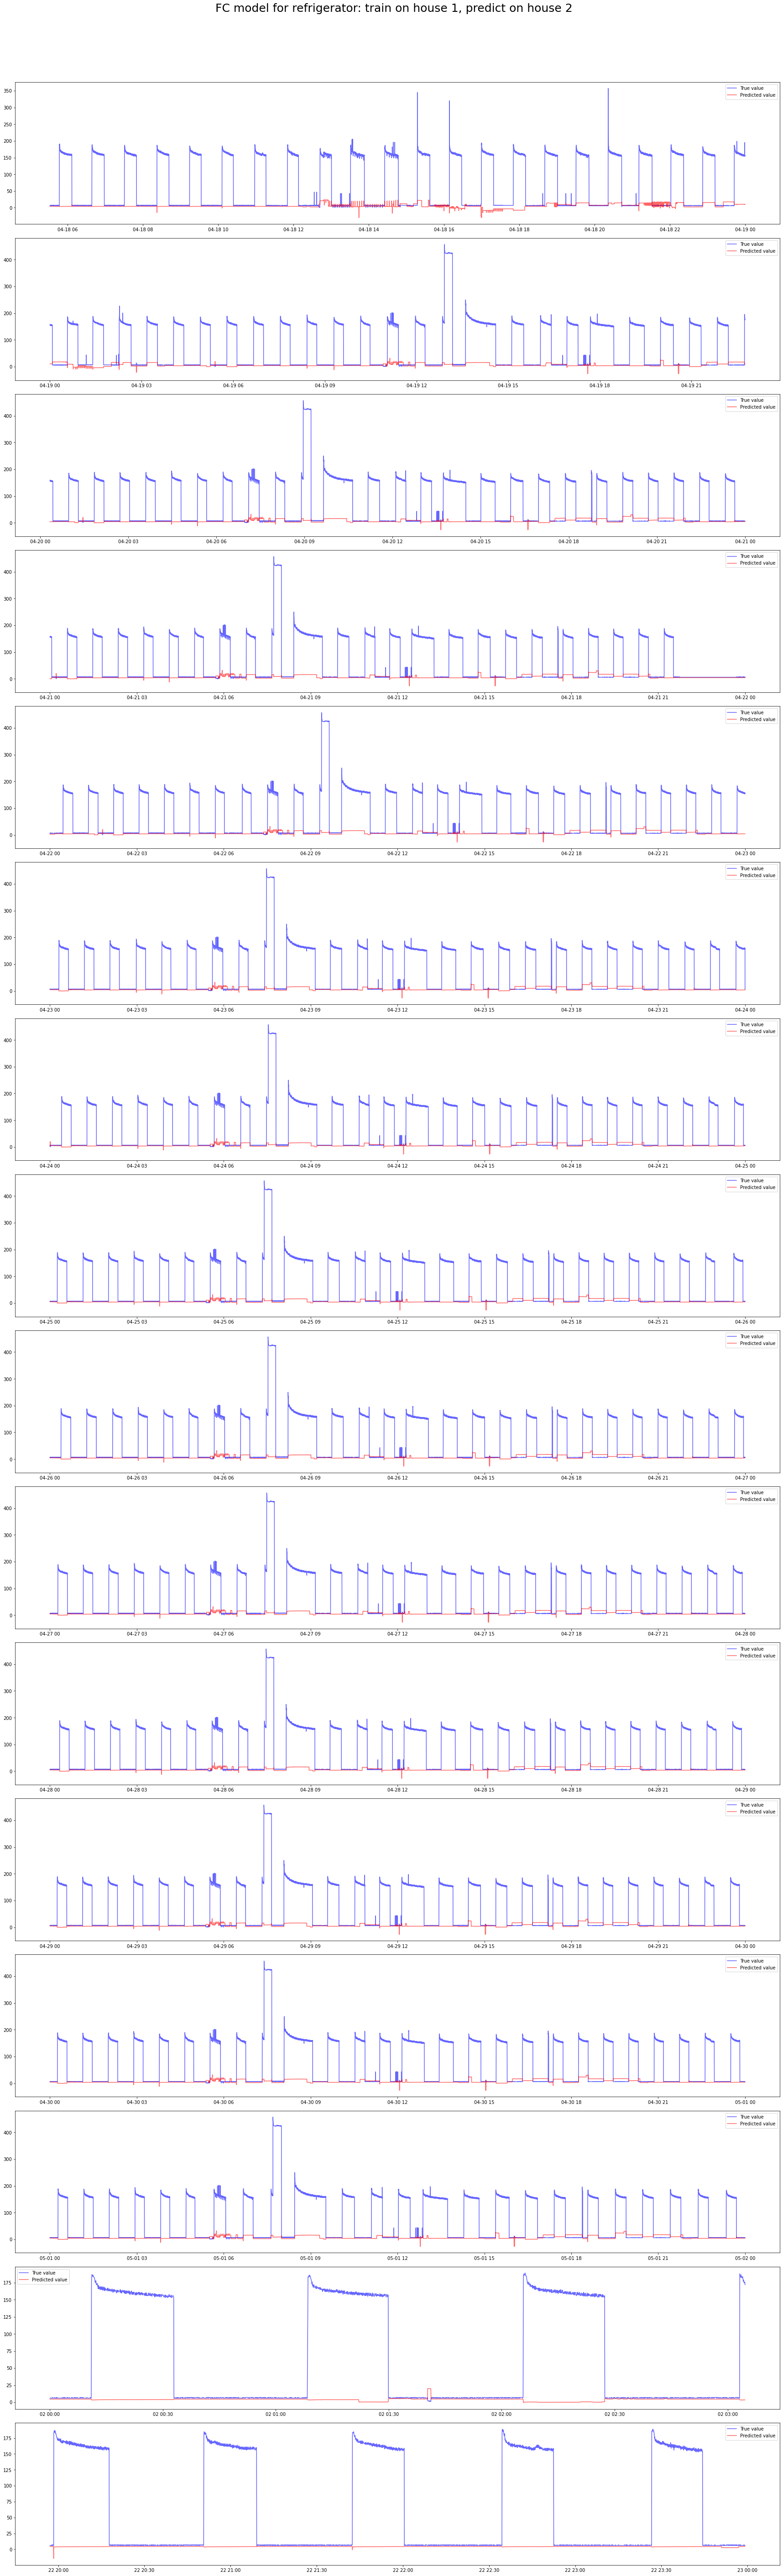

In [ ]:
plot_each_app(df[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

用50個連續的總用電數據來預測個別電器的用數據  
用在House 1訓練好的model來disaggregate House 2冰箱的用電數據

In [ ]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [ ]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:17], ['mains_1','mains_2'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][17:], ['mains_1','mains_2'], df[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  1718.488135099411
(318841, 50, 2) (318841, 18) (86757, 50, 2) (86757, 18)


In [ ]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25856     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

In [ ]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

(318841, 100) (318841,)


In [ ]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, epochs= 100,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/100
418/418 [==============================] - 4s 9ms/step - loss: 96729.8750 - val_loss: 13240.5508
Epoch 2/100
418/418 [==============================] - 4s 8ms/step - loss: 75784.6250 - val_loss: 10540.4844
Epoch 3/100
418/418 [==============================] - 4s 8ms/step - loss: 60687.4727 - val_loss: 10223.6670
Epoch 4/100
418/418 [==============================] - 4s 8ms/step - loss: 47102.6289 - val_loss: 10828.7041
Epoch 5/100
418/418 [==============================] - 3s 8ms/step - loss: 40282.3906 - val_loss: 10363.7715
Epoch 6/100
418/418 [==============================] - 3s 8ms/step - loss: 34753.3711 - val_loss: 9856.9648
Epoch 7/100
418/418 [==============================] - 3s 8ms/step - loss: 29735.9297 - val_loss: 9916.4502
Epoch 8/100
418/418 [==============================] - 4s 9ms/step - loss: 26100.8574 - val_loss: 9835.2148
Epoch 9/100
418/418 [==============================] - 4s 8ms/step - loss: 24654.8438 - val_loss: 9912.0547
Epoch 10/100
418/418 [=

In [ ]:
! cp /content/fc_refrig_h1.hdf5 '/content/data/MyDrive/110-1/物聯網/Final'

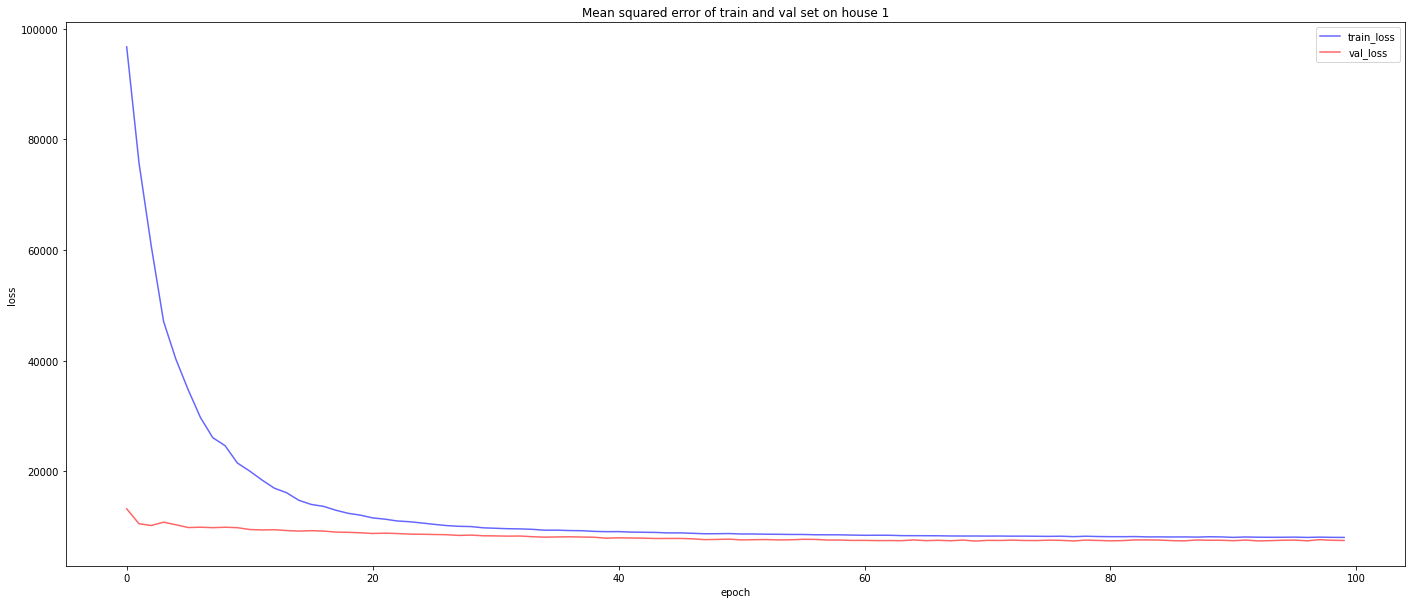

In [ ]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [ ]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(86757,)


In [ ]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

Mean square error on test set:  8502.557597013934
Mean absolute error on the test set:  47.080204231212406


把hidden layers的數目增加似乎能讓disaggreation更準確一點，但效果依然沒有任何實用價值。

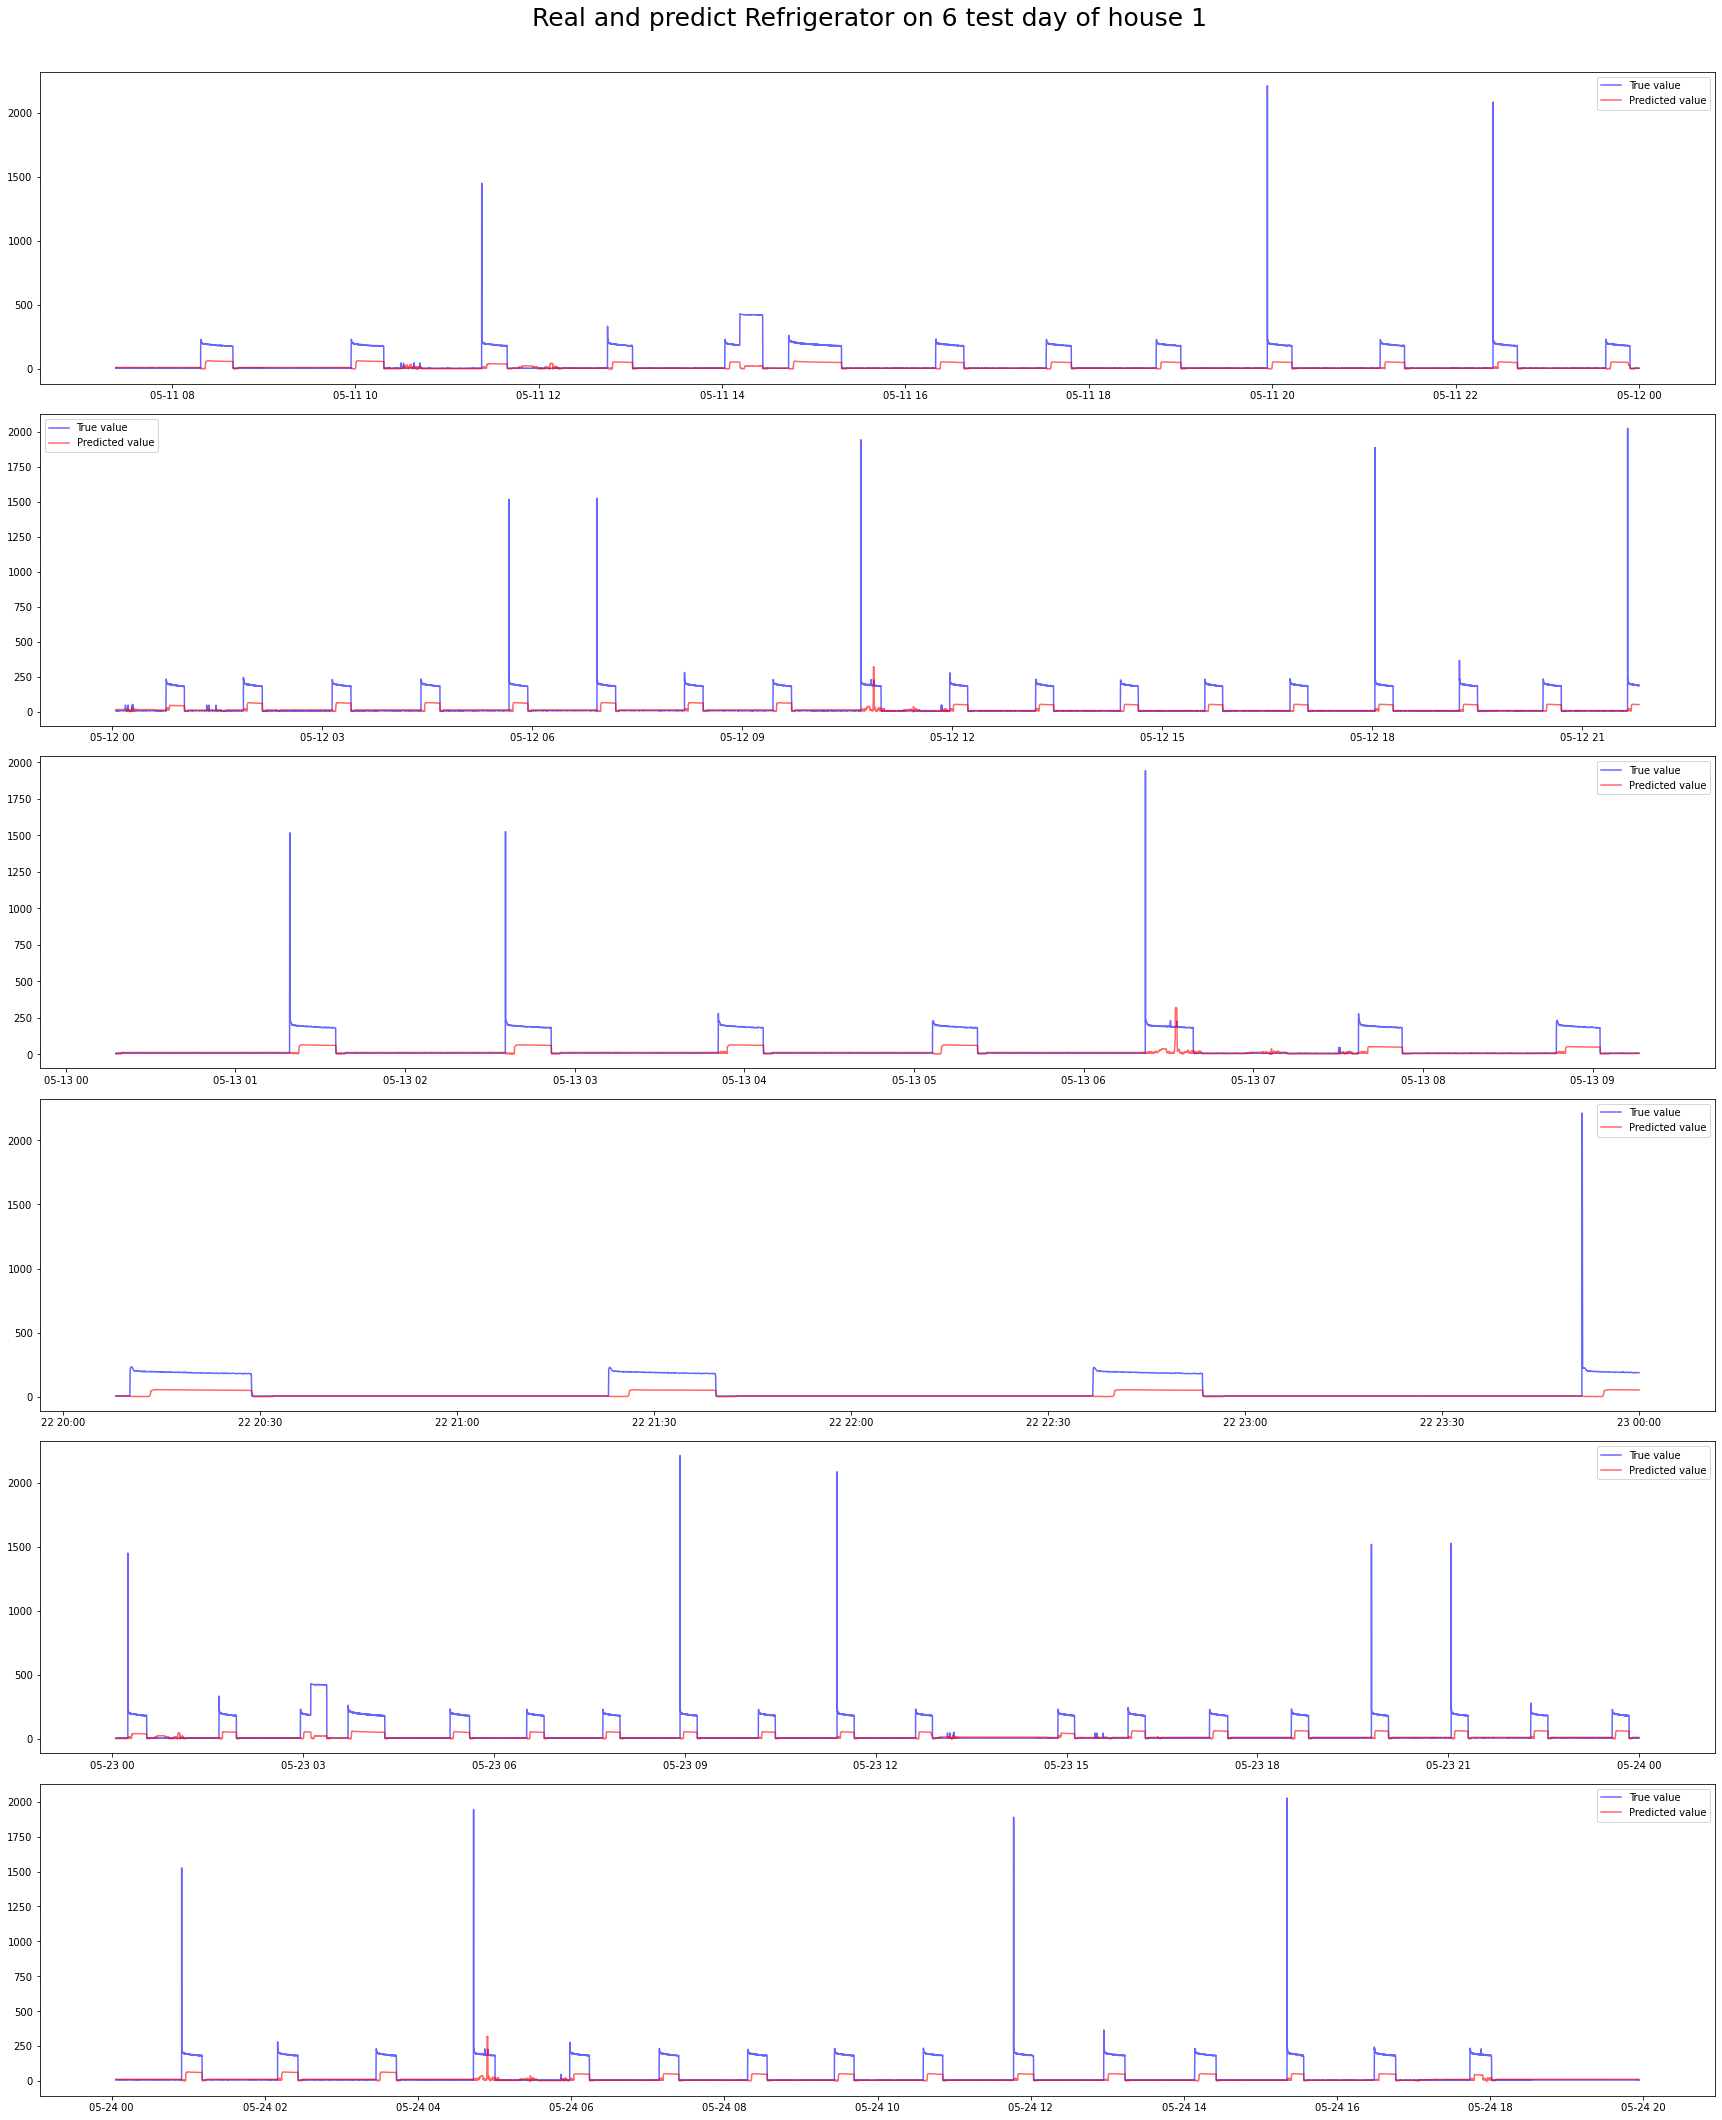

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

用House 2做測試

In [ ]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  1605.0401997566223
(316040, 100) (316040,)


In [ ]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

Mean square error on test set:  12314.82969632139
Mean absolute error on the test set:  72.77669577485109


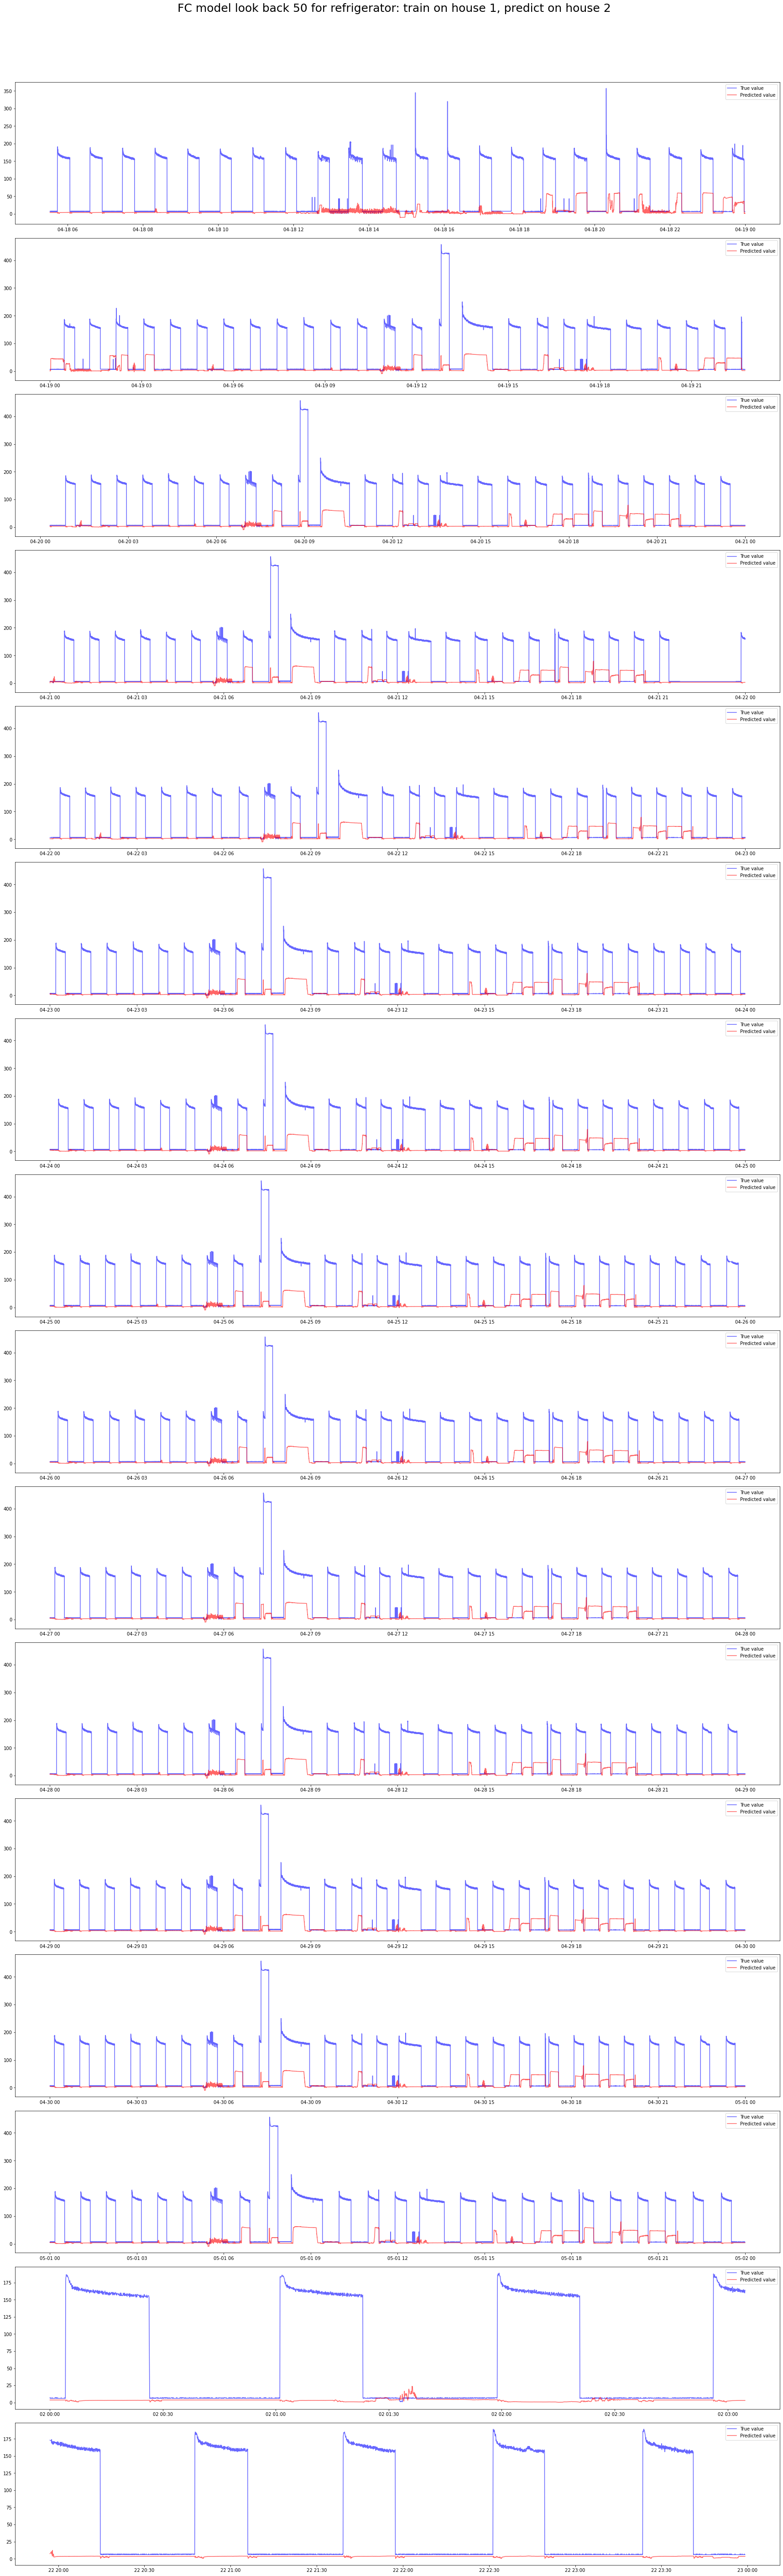

In [ ]:
plot_each_app(df[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

跟House 1類似，增加hidden layers也能讓House 2的預測結果稍微準一點。  
綜上觀察，單純套用一般的NN效果非常差，猜測主要的原因是因為我們沒有處理各個時點間用電數據的因果關係。  
在上一段討論到的兩個用電數據的特質：time series與數據間的決策（因果）關係，以下改用LSTM演算法來訓練模型。

In [ ]:
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
# from keras.models import Sequential
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model
# from keras.optimizers import adam_v2
# from keras import optimizers
# from keras.regularizers import l2

In [ ]:
def _getStepTrainTest(step_size, train_close, test_close):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range (step_size, (train_close.shape[0])): 
        x_train.append(train_close[i-step_size:i,0]) 
        y_train.append(train_close[i,0])
    x_train,y_train = np.array(x_train),np.array(y_train)
    x_train = np.expand_dims(x_train, axis = 1)
    for i in range (step_size, (test_close.shape[0])): 
        x_test.append(test_close[i-step_size:i,0]) 
    x_test = np.array(x_test)
    x_test = np.expand_dims(x_test, axis = 1)
    
    return x_train, y_train, x_test

In [ ]:
y_train1 = y_train1.reshape(-1,1)

In [ ]:
y_test1 = y_test1.reshape(-1,1)

In [ ]:
step_size = 1
x_train, y_train, x_test = _getStepTrainTest(step_size, y_train1, y_test1)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units =1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_9 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_10 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

In [ ]:
start = time.time()
adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            x_train,
            y_train,
            batch_size=32,
            verbose=1,
            epochs=10,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/10
4700/4700 [==============================] - 324s 66ms/step - loss: 4711.4922 - val_loss: 1302.1663
Epoch 2/10
4700/4700 [==============================] - 316s 67ms/step - loss: 1183.4955 - val_loss: 824.6233
Epoch 3/10
4700/4700 [==============================] - 316s 67ms/step - loss: 1084.4811 - val_loss: 826.1575
Epoch 4/10
4700/4700 [==============================] - 313s 67ms/step - loss: 1084.7599 - val_loss: 821.1171
Epoch 5/10
4700/4700 [==============================] - 315s 67ms/step - loss: 1078.7378 - val_loss: 822.9335
Epoch 6/10
4700/4700 [==============================] - 316s 67ms/step - loss: 1079.6471 - val_loss: 826.0577
Epoch 7/10
4700/4700 [==============================] - 317s 67ms/step - loss: 1080.5376 - val_loss: 824.4924
Epoch 8/10
4700/4700 [==============================] - 319s 68ms/step - loss: 1082.7202 - val_loss: 824.3260
Epoch 9/10
4700/4700 [==============================] - 317s 68ms/step - loss: 1077.8929 - val_loss: 822.1258
Epoch 10/

In [ ]:
! cp /content/lstm_model.hdf5 '/content/data/MyDrive/110-1/物聯網/Final'

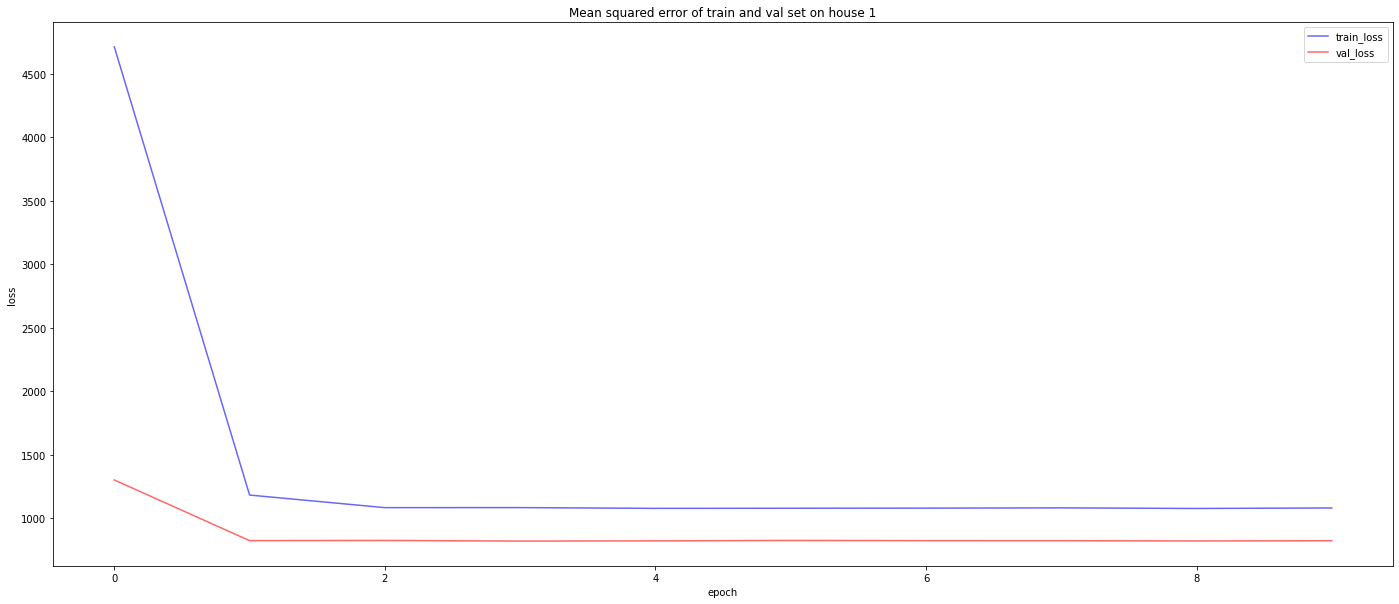

In [ ]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']


plot_losses(train_loss, val_loss)

10個Epochs就能將MSE降的比先前用的兩種方式都低的很多，看起來LSTM還算合適

In [ ]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(x_test)
print(pred_lstm.shape)

(87056, 1)


In [ ]:
y_test1[:-1].shape

(87056, 1)

In [ ]:
mse_loss_lstm = mse_loss(pred_lstm, y_test1[:-1])
mae_loss_lstm = mae_loss(pred_lstm, y_test1[:-1])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  997.3852261972069
Mean absolute error on the test set:  5.836136666280429


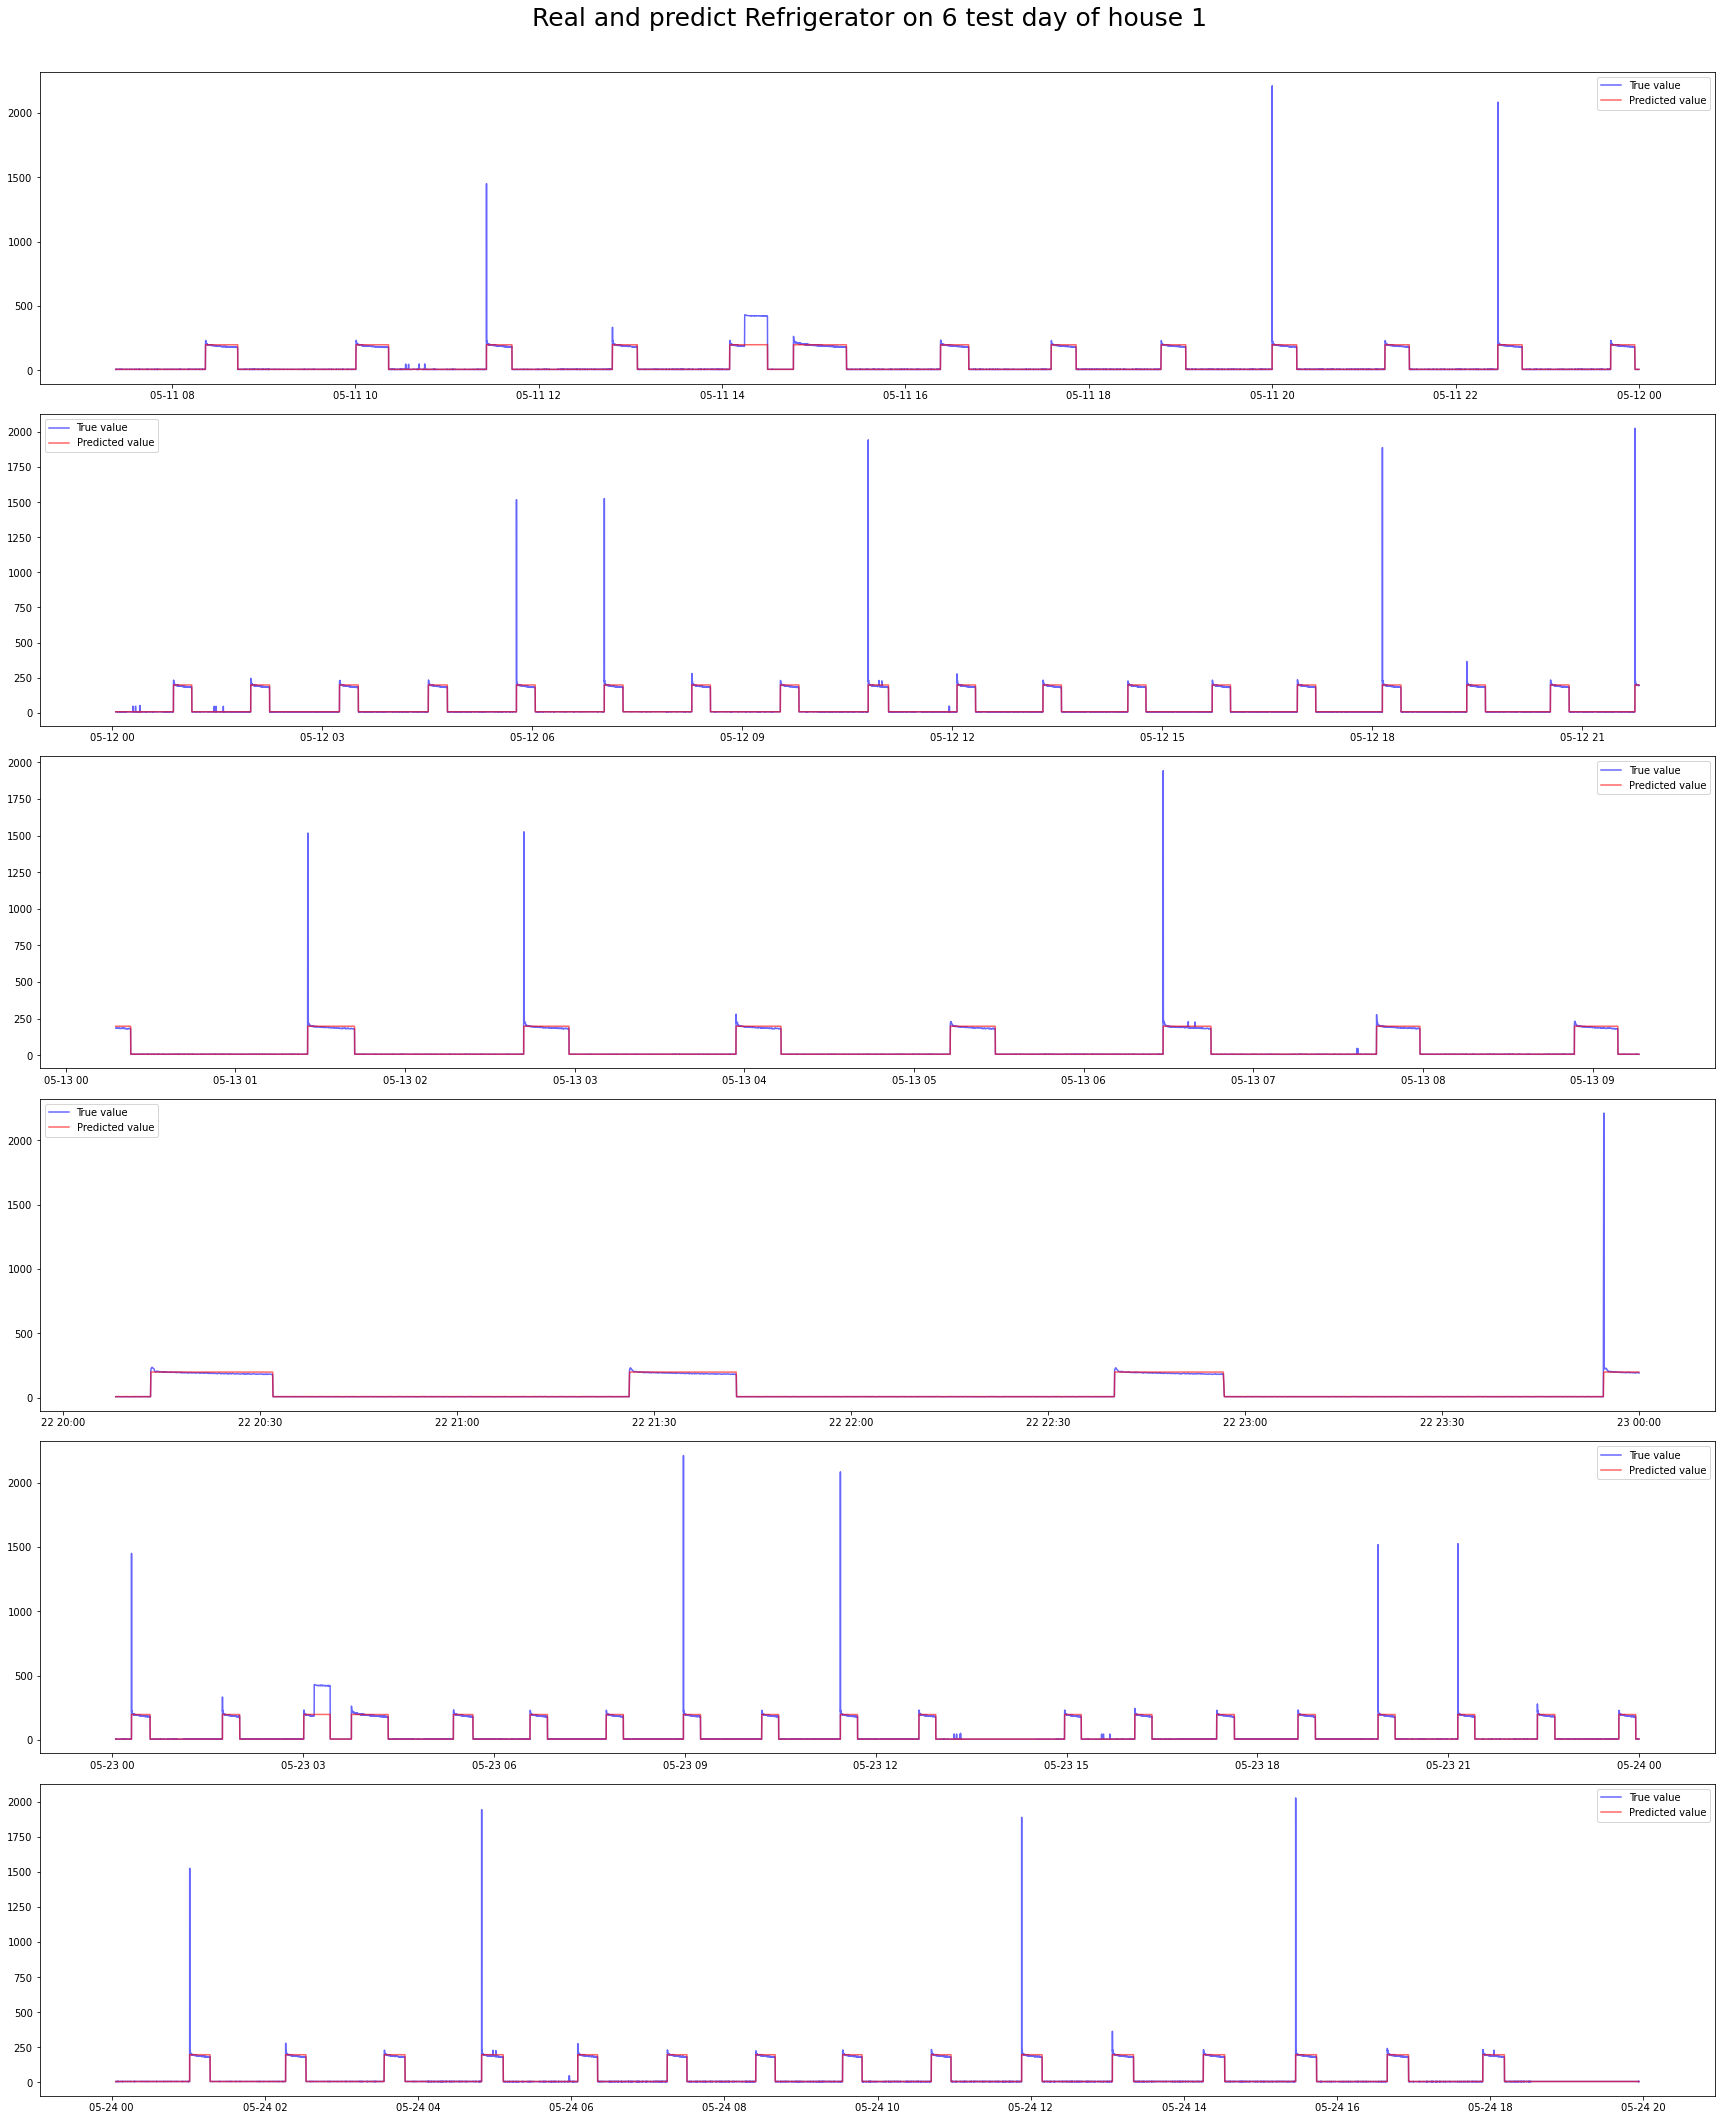

In [ ]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test1[:-1], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

In [ ]:
y_2 = y_2.reshape(-1,1)

In [ ]:
step_size = 1
x_train2, y_train2, x_test2 = _getStepTrainTest(step_size, y_2[:int(-0.2*len(y_2))],y_2[int(-0.2*len(y_2)):])

In [ ]:
y_2[int(-0.2*len(y_2)):].shape

(63208, 1)

In [ ]:
x_test2.shape

(63207, 1, 1)

In [ ]:
pred_lstm_h2 = model.predict(x_test2)

In [ ]:
pred_lstm_h2.shape

(63207, 1)

In [ ]:
y_2[int(-0.2*len(y_2)):-1].shape

(63207, 1)

In [ ]:
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2[int(-0.2*len(y_2)):-1])
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2[int(-0.2*len(y_2)):-1])
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  1594.3928615329617
Mean absolute error on the test set:  20.190989855616124


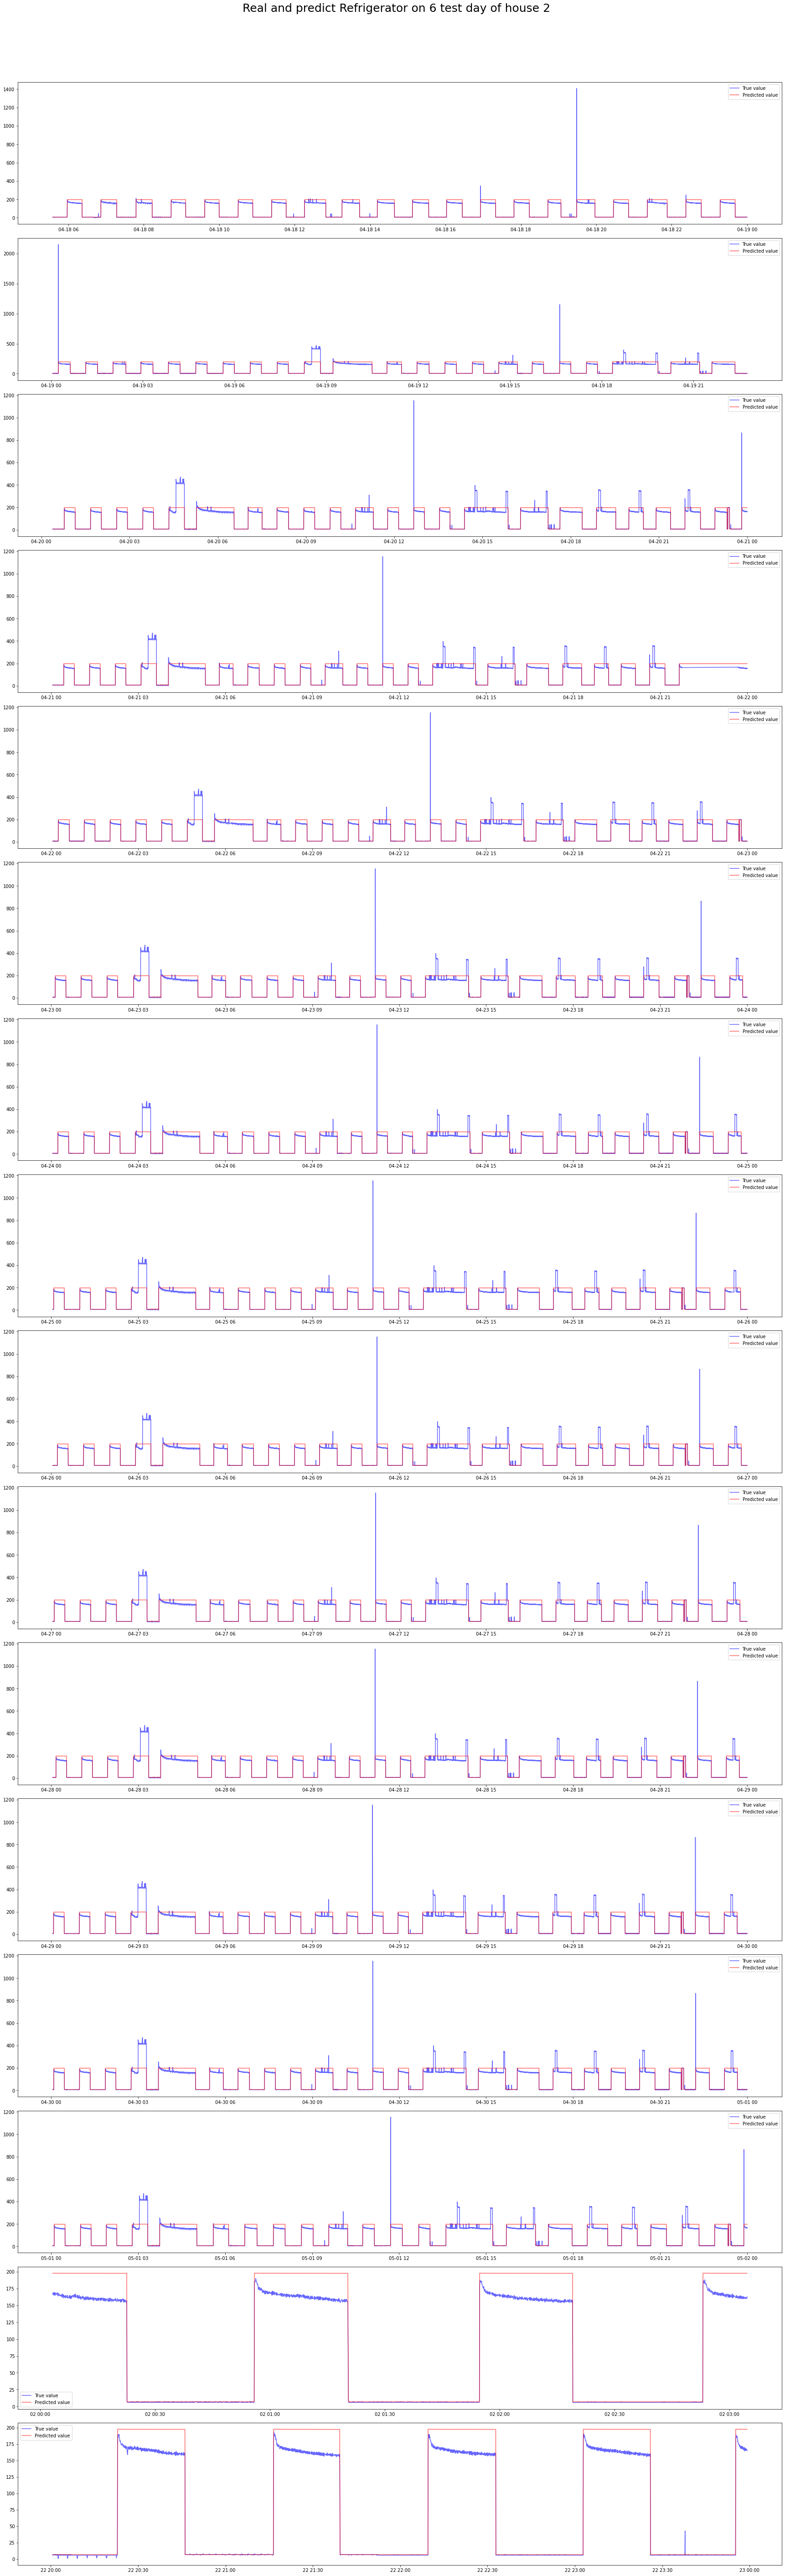

In [ ]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2[int(-0.2*len(y_2)):], 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)